## Target configuration

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-11-08 14:28:23,801 INFO    : root         : Using LISA logging configuration:
2017-11-08 14:28:23,802 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
%matplotlib inline

import os
import json

import devlib
from env import TestEnv

import trappy
# Support for trace events analysis
from trace import Trace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from wlgen import RTA, Periodic, Ramp

In [3]:
res_dir = '/home/leoy/work2/hikey960/wa_hikey960/uibench_ts/uibench_InvalidateActivity_1_1'
trace_file = os.path.join(res_dir, "trace.dat")

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'hikey960',
    
    # Device serial ID
    # Not required if there is only one device connected to your computer
    "device"       : "270182BA020B1AA2",
    
    "ANDROID_HOME" : "/home/leoy/Work/tools/lisa-mainline/tools/android-sdk-linux",
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "taskset_test",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',
        'cpuidle'
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench'],
}

In [5]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}


In [6]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


# CPU Frequency Analysis

2017-11-08 14:28:32,400 INFO    : Analysis     : CPU00 average frequency: 1.131 GHz
2017-11-08 14:28:32,550 INFO    : Analysis     : CPU01 average frequency: 1.131 GHz
2017-11-08 14:28:32,679 INFO    : Analysis     : CPU02 average frequency: 1.131 GHz
2017-11-08 14:28:32,833 INFO    : Analysis     : CPU03 average frequency: 1.131 GHz
2017-11-08 14:28:32,970 INFO    : Analysis     : CPU04 average frequency: 1.374 GHz
2017-11-08 14:28:33,117 INFO    : Analysis     : CPU05 average frequency: 1.374 GHz
2017-11-08 14:28:33,288 INFO    : Analysis     : CPU06 average frequency: 1.374 GHz
2017-11-08 14:28:33,453 INFO    : Analysis     : CPU07 average frequency: 1.374 GHz


{0: 1.1313457452684548,
 1: 1.1313169301951669,
 2: 1.1313077903371249,
 3: 1.1312996419288139,
 4: 1.3735809168709951,
 5: 1.3735724617361462,
 6: 1.3735672068497171,
 7: 1.3735616481870994}

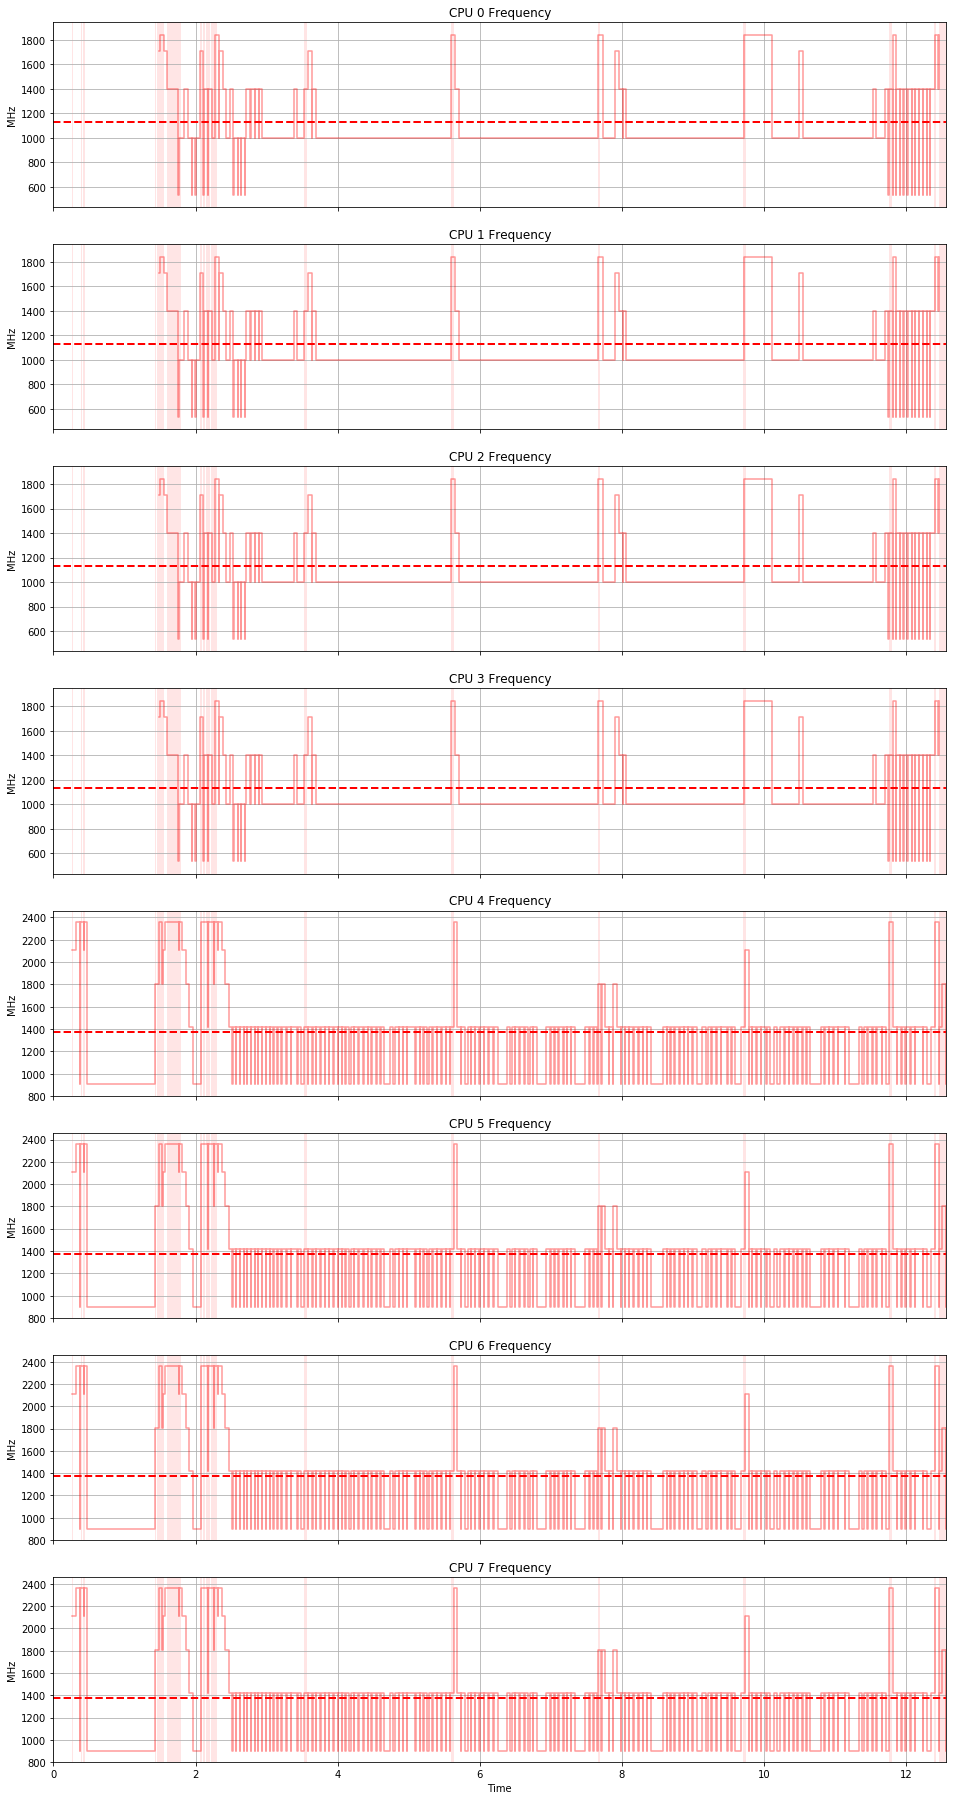

In [7]:
trace.analysis.frequency.plotCPUFrequencies()

2017-11-08 14:28:50,569 INFO    : Analysis     : LITTLE cluster average frequency: 1.131 GHz
2017-11-08 14:28:50,574 INFO    : Analysis     : big    cluster average frequency: 1.374 GHz
2017-11-08 14:28:50,579 INFO    : root         : Plotting cluster frequencies for [sched]...


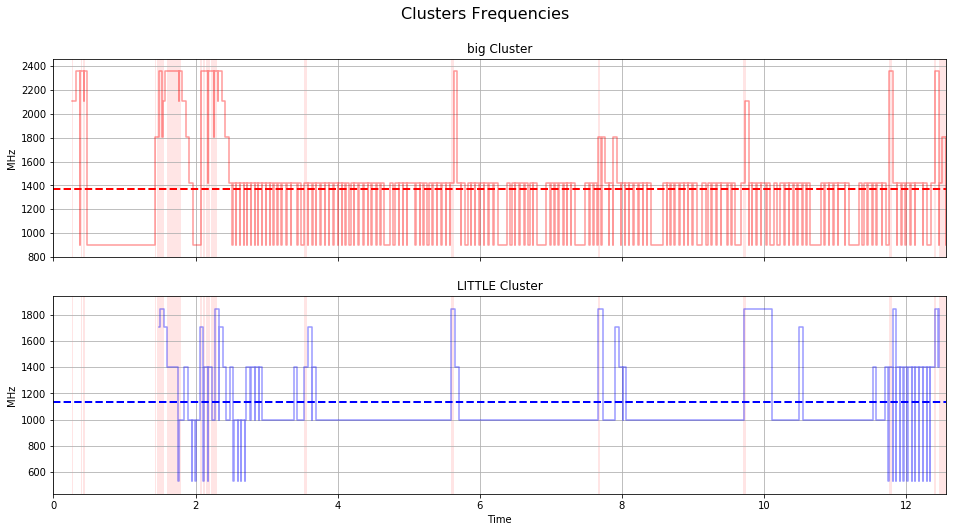

In [8]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

# CPU Task Placement Analysis

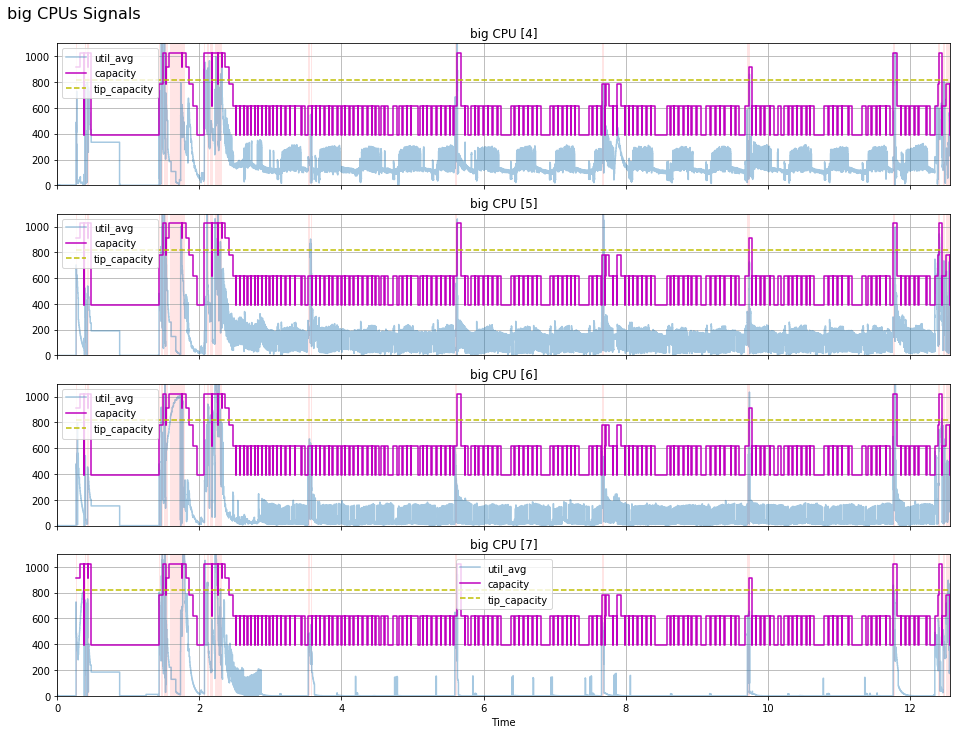

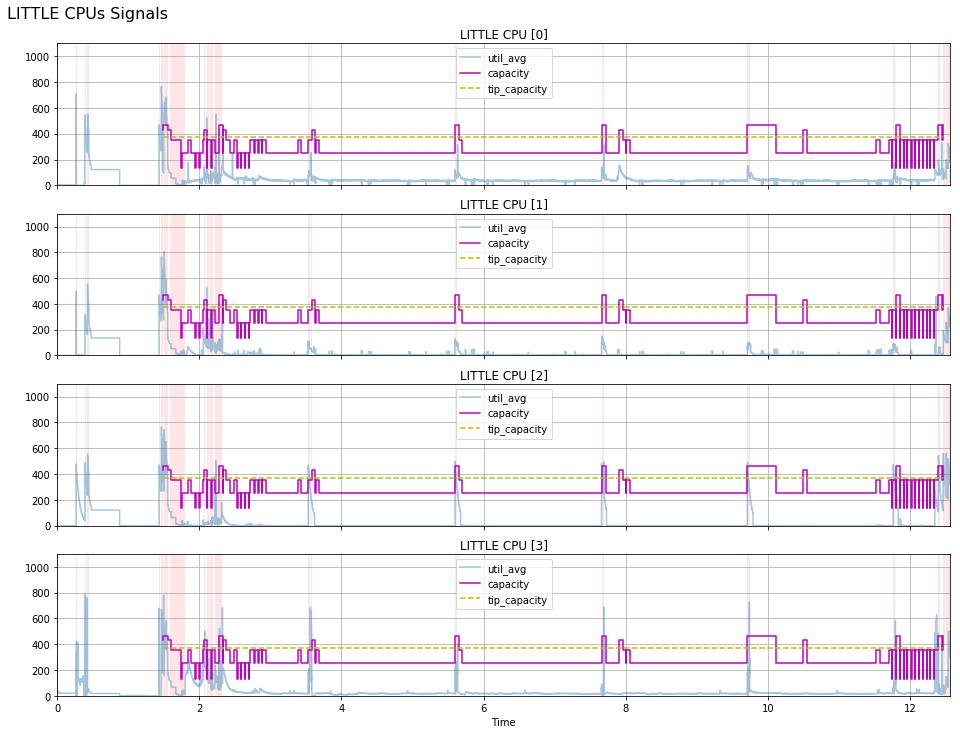

In [9]:
trace.analysis.cpus.plotCPU()

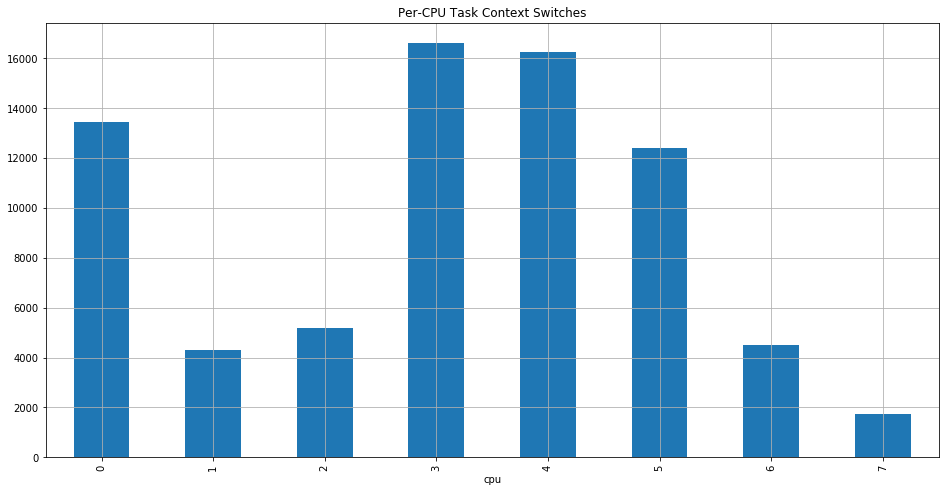

In [10]:
trace.analysis.cpus.plotContextSwitch()

In [11]:
import re

def plotTaskPlacement():
    df = trace.data_frame.trace_event('sched_switch')

    # Don't count idle thread switching
    df = df[df['next_pid'] != 0]

    # Kernel has several per CPU tasks, scheduler cannot
    # place these tasks onto other CPUs but only affinitied CPU
    per_cpu_tasks = [ "swapper", "rcu_preempt", "kschedfreq", "kworker"]
    per_cpu_tasks_pattern = '|'.join(map(re.escape, per_cpu_tasks))

    per_cpu_task_df = df[df['next_comm'].str.contains(per_cpu_tasks_pattern)]
    normal_task_df = df[~df['next_comm'].str.contains(per_cpu_tasks_pattern)]

    # We have 8 CPUs
    cpus = range(8)

    data = {
        'per_cpu_task_df': [len(per_cpu_task_df[per_cpu_task_df['__cpu'] == cpu]) for cpu in cpus],
        'normal_task_df': [len(normal_task_df[normal_task_df['__cpu'] == cpu]) for cpu in cpus]
    }
    df = pd.DataFrame(data, columns = ['per_cpu_task_df', 'normal_task_df'])

    ax = df.plot.bar(title="Per-CPU Task Placement Statistics",
                                 legend=True,
                                 figsize=(16, 8), stacked=True)
    ax.grid()

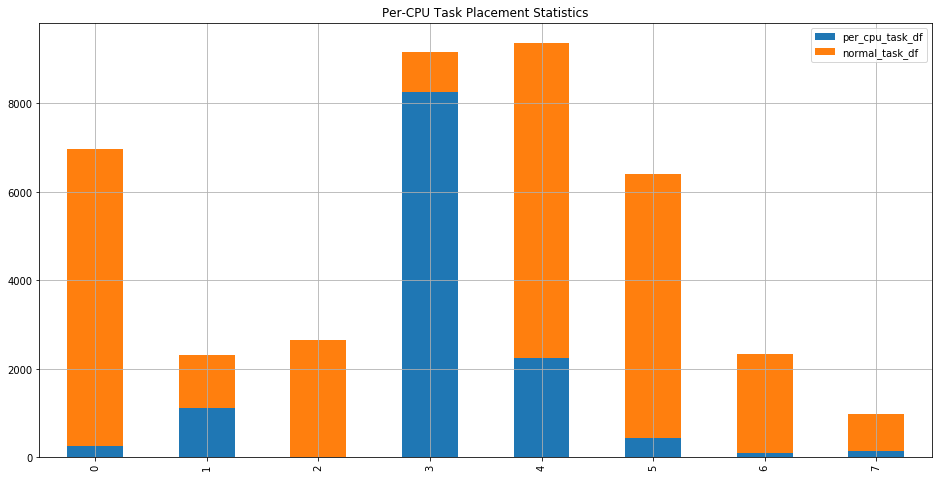

In [12]:
plotTaskPlacement()

# Task scheduling latency

In [13]:
"""
Plot scheduling latency for tasks with same task name

In the system there have some tasks have the same name
but with different PID; e.g. RenderThread, mali GPU
related threads.

This function passes the 'task_name' then it will find
the corresponding PID for tasks and plot scheduling
latency with analysis function plotLatency().
"""
def plot_task_scheduling_latency(task_name):
    for name in trace.getTasks().values():
        if task_name in name:
            for pid in trace.getTaskByName(name):
                trace.analysis.latency.plotLatency(pid)

2017-11-08 14:29:04,787 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:04,972 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:29:05,016 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:29:05,019 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:29:05,022 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:29:06,717 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:06,719 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:06,721 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:06,723 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:06,728 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:07,057 INFO    : Analysis     : Found:  1338 WAKEUP latencies
2017-11-0

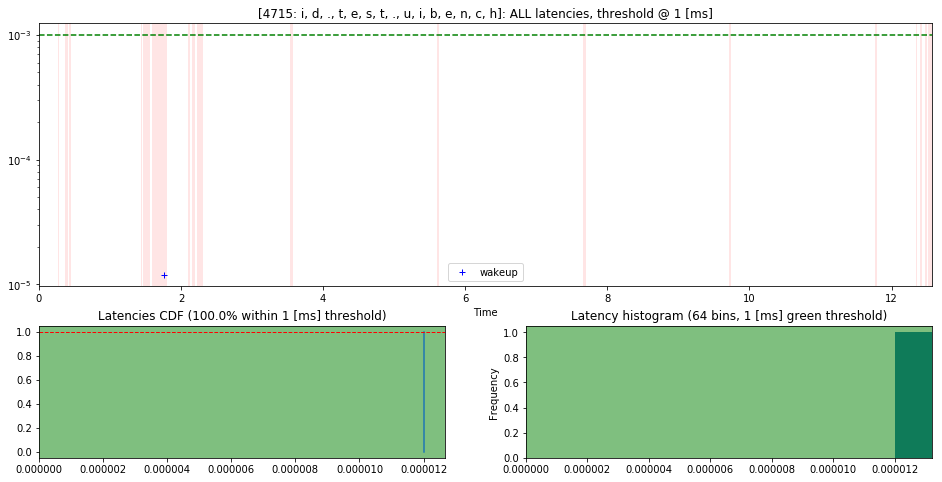

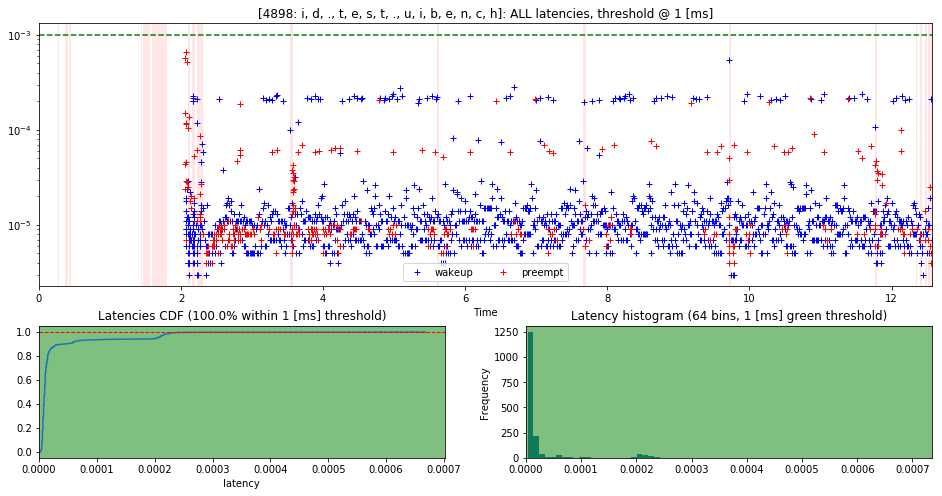

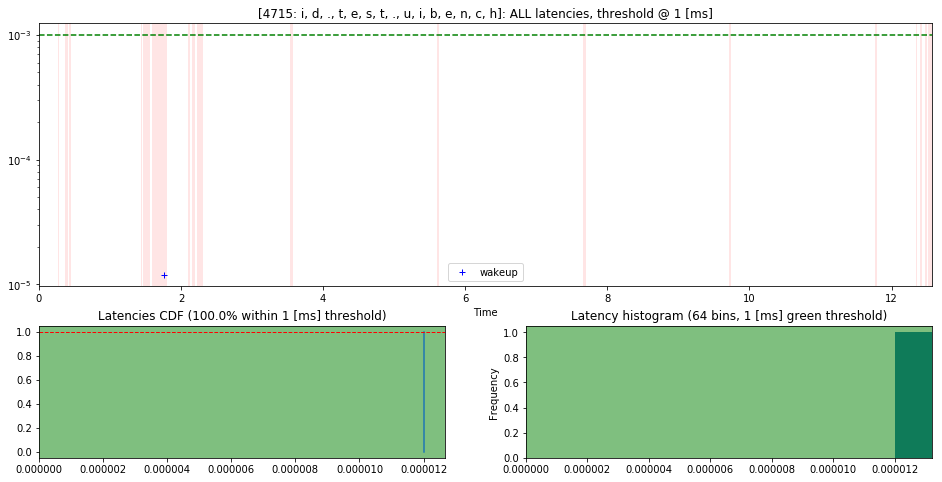

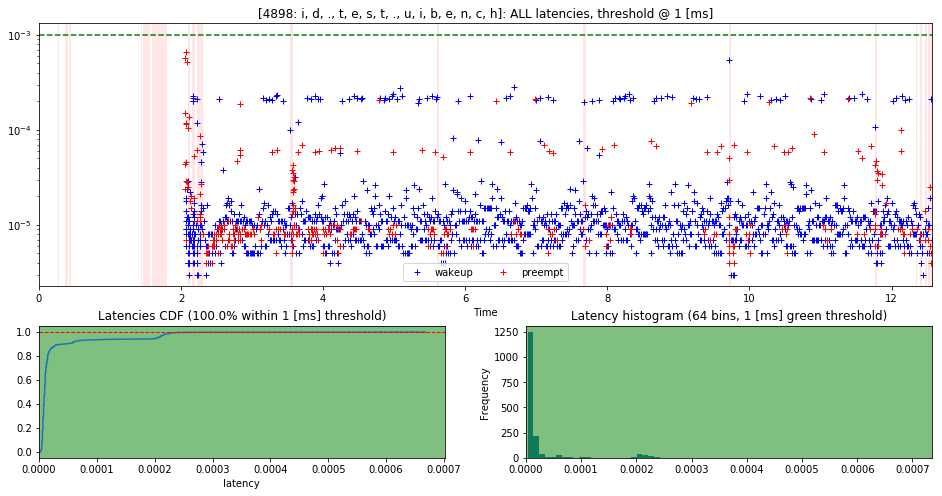

In [14]:
plot_task_scheduling_latency("id.test.uibench")

2017-11-08 14:29:14,835 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:14,848 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:14,851 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:14,862 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:15,341 INFO    : Analysis     : Found:  4426 WAKEUP latencies
2017-11-08 14:29:15,389 INFO    : Analysis     : Found:   134 PREEMPT latencies
2017-11-08 14:29:15,391 INFO    : Analysis     : Total:  4560 latency events
2017-11-08 14:29:15,396 INFO    : Analysis     : 99.9 % samples below 1 [ms] threshold
2017-11-08 14:29:16,763 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:16,765 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:16,771 INFO    : Analysis     : Parsing sched_switch states assuming ker

2017-11-08 14:29:40,326 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:29:41,595 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:41,597 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:41,606 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:41,667 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:29:42,265 INFO    : Analysis     : Found:  2681 WAKEUP latencies
2017-11-08 14:29:42,436 INFO    : Analysis     : Found:    21 PREEMPT latencies
2017-11-08 14:29:42,439 INFO    : Analysis     : Total:  2702 latency events
2017-11-08 14:29:42,443 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:29:44,786 INFO    : Analysis     : Found:  4426 WAKEUP latencies
2017-11-08 14:29:44,968 INFO    : Analysis     : Found:   134 PREEMPT latencies
2017-11-08 14:29:44,970 INFO    : Ana

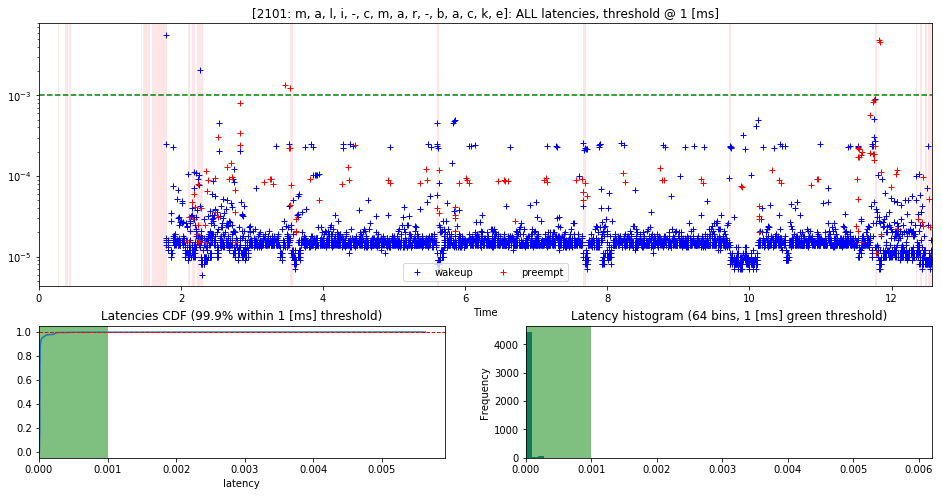

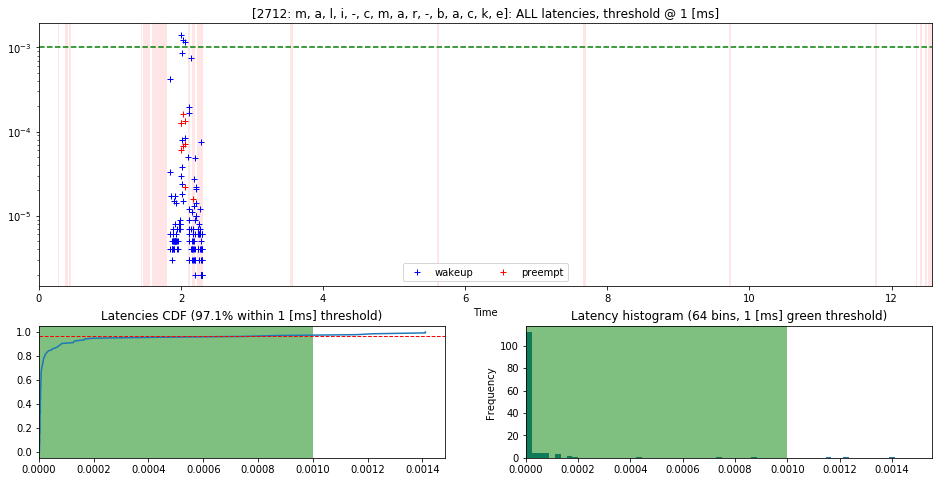

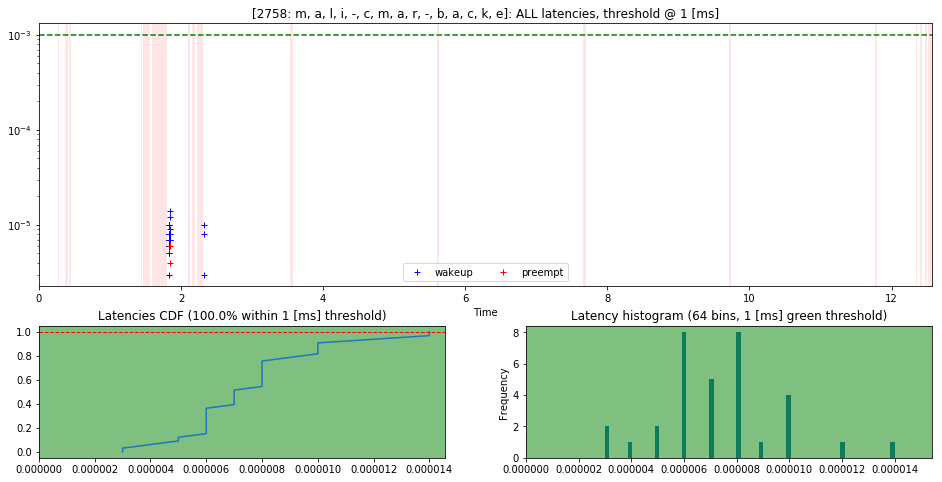

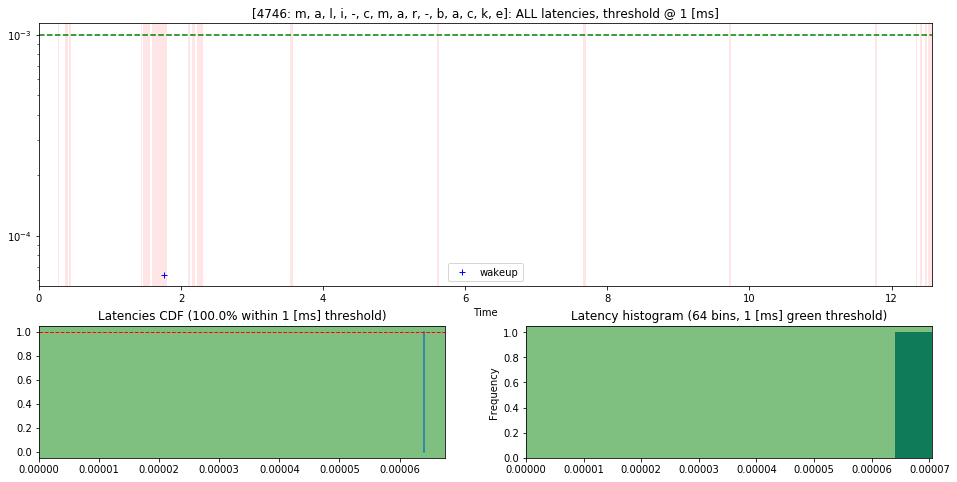

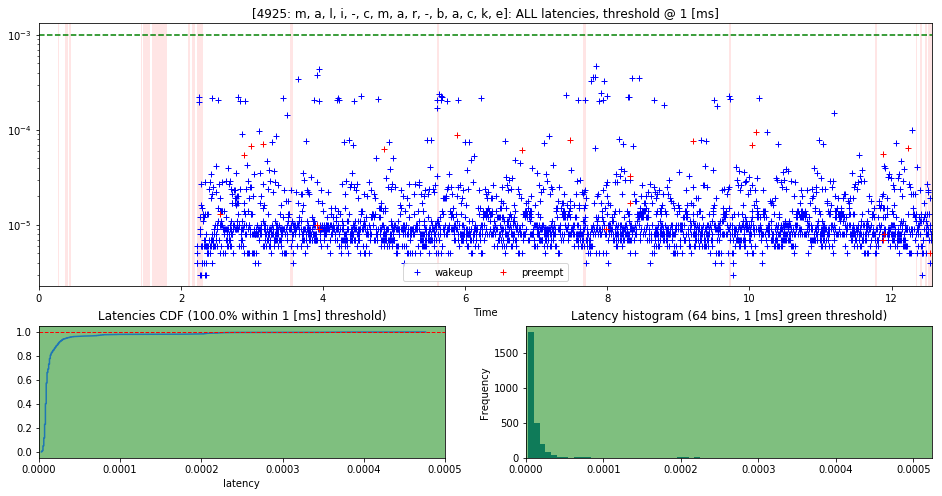

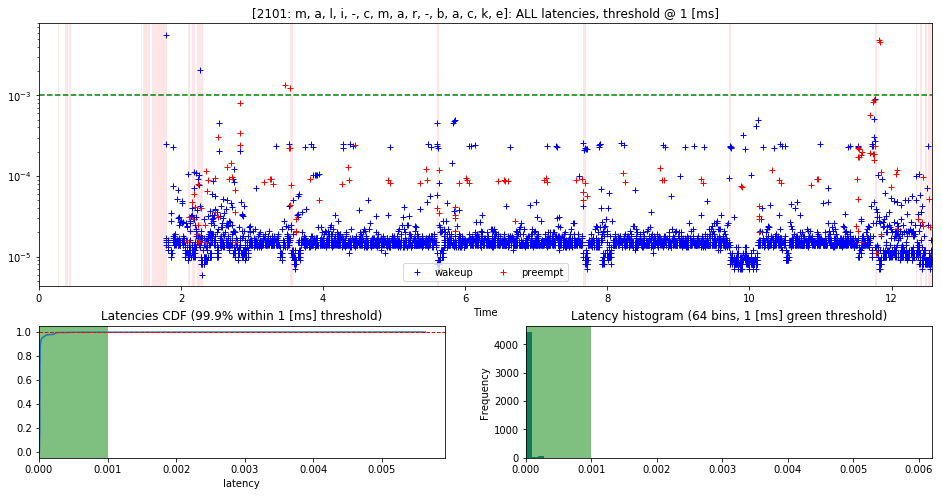

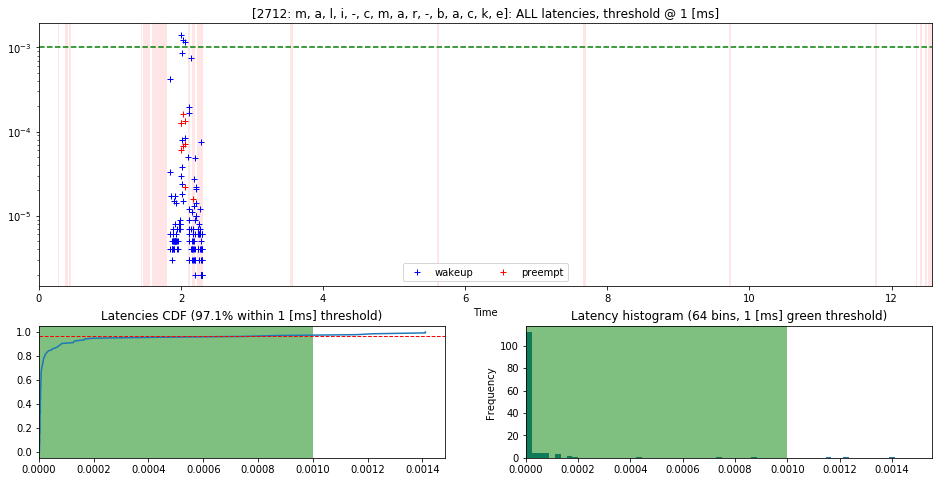

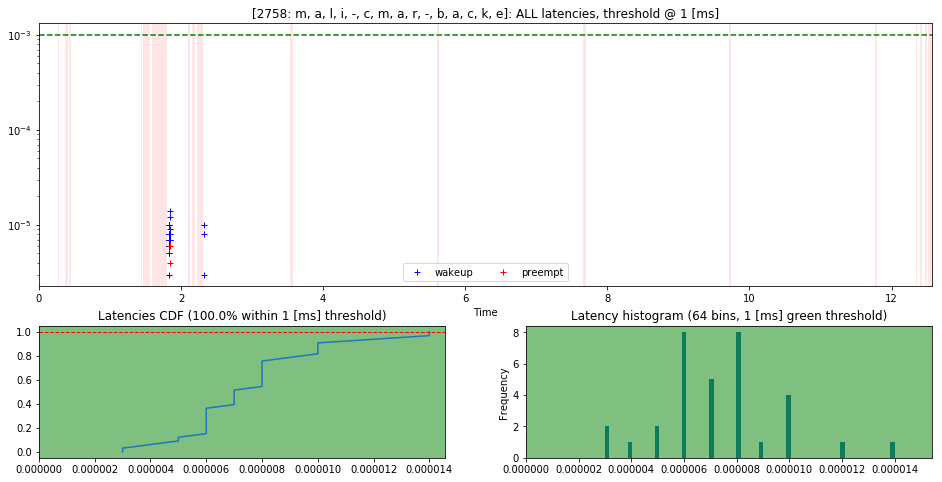

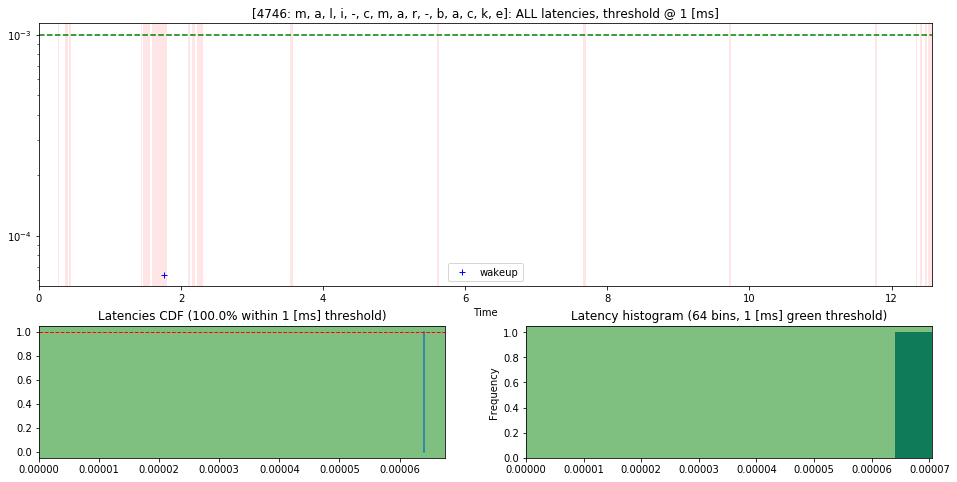

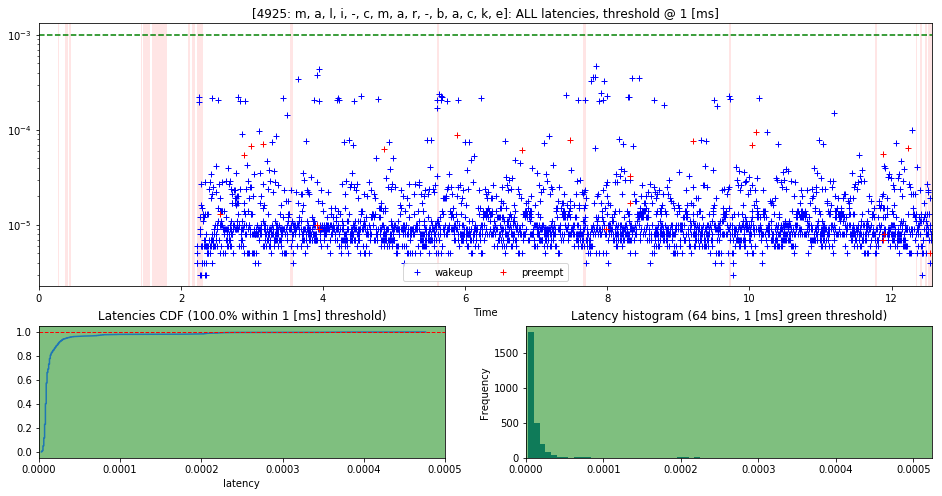

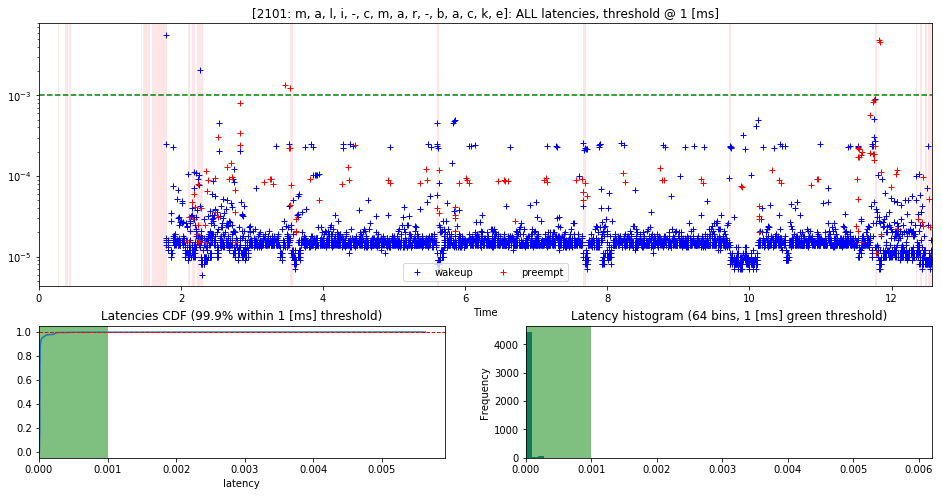

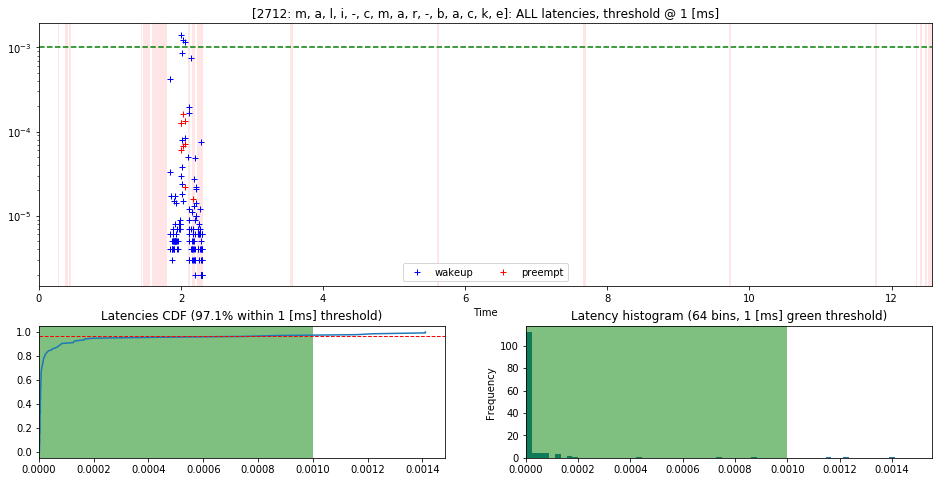

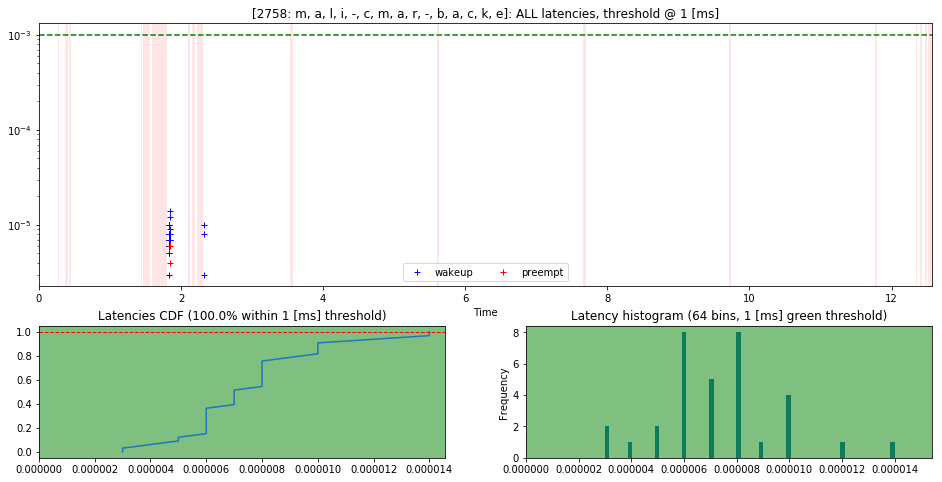

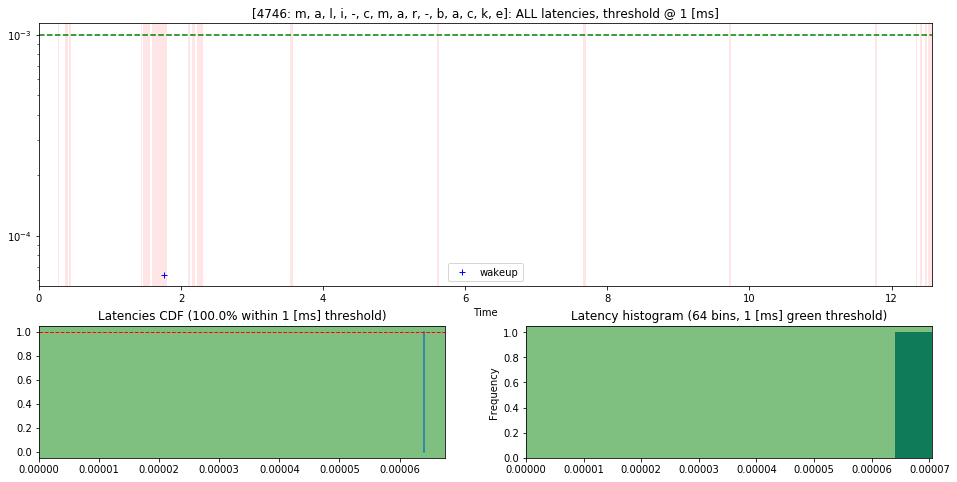

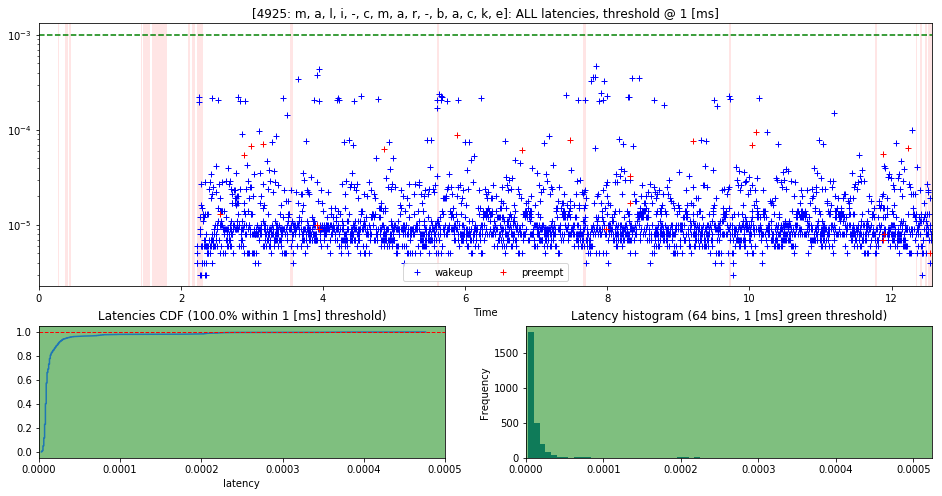

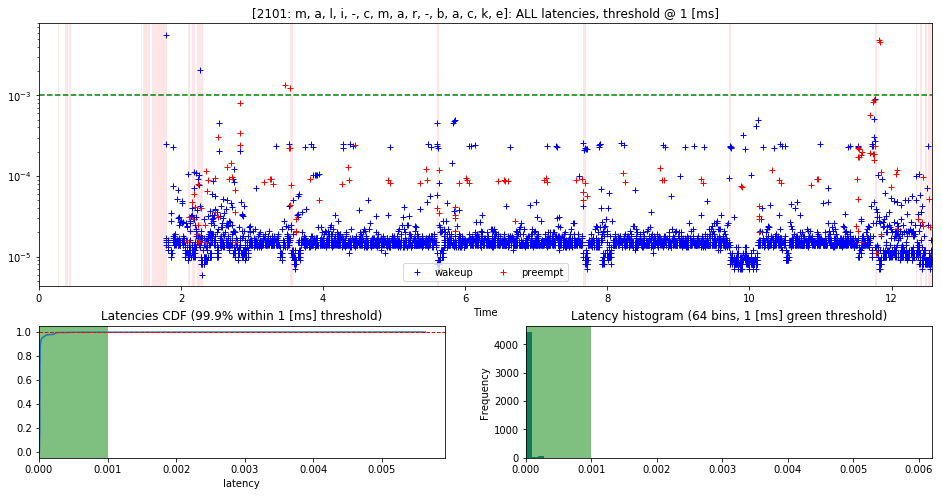

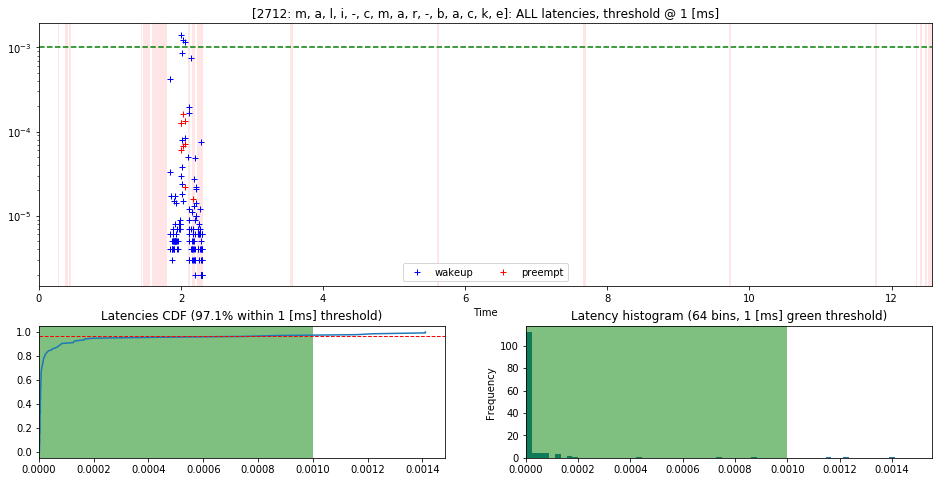

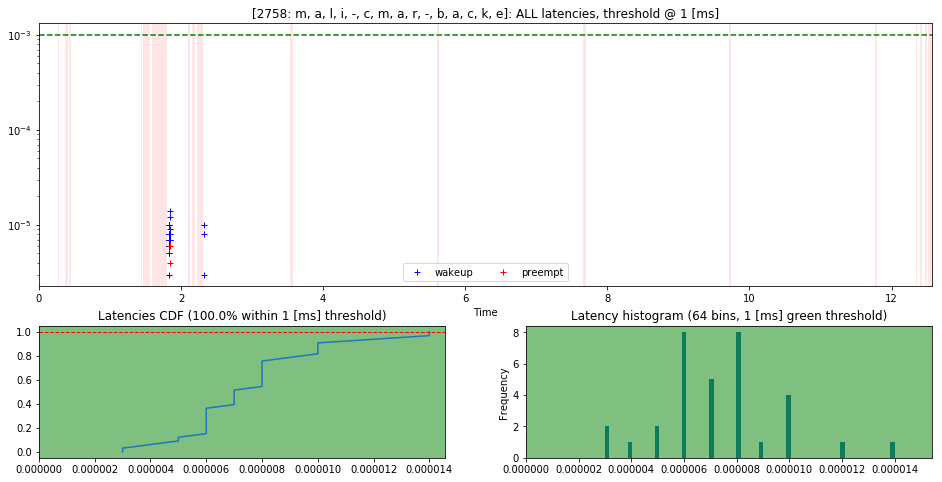

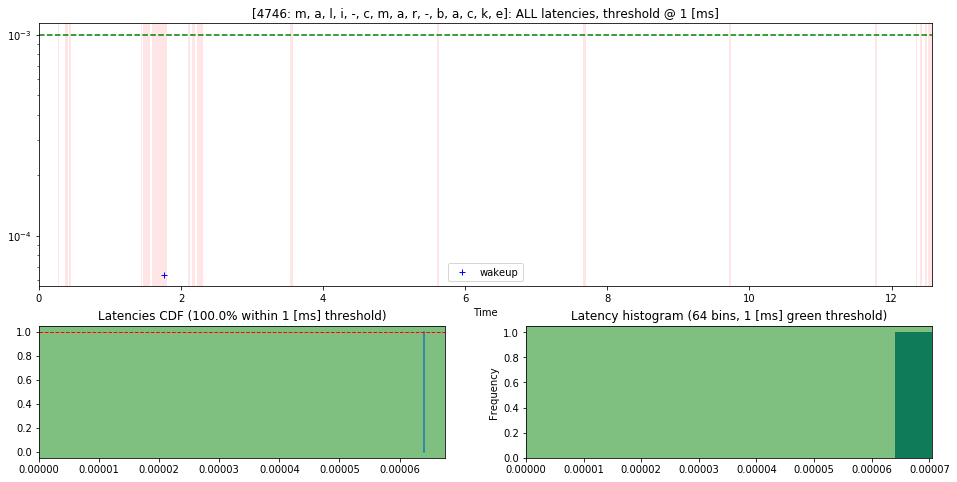

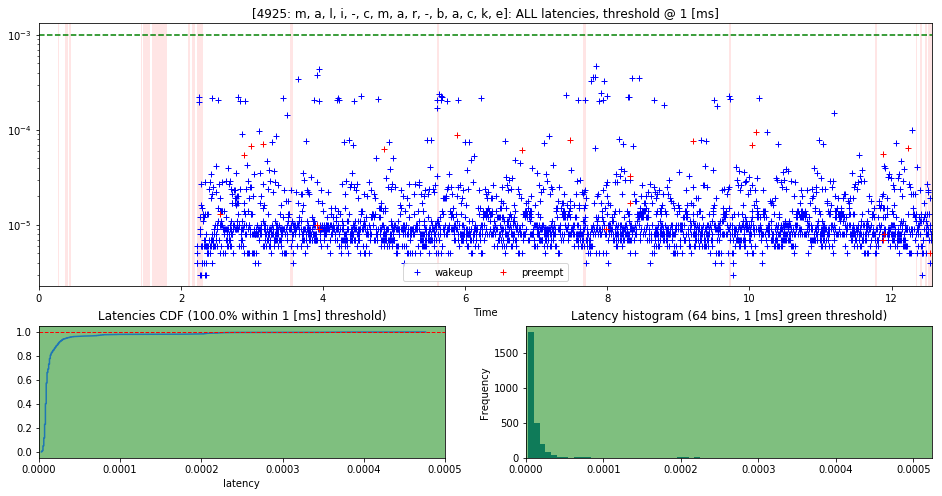

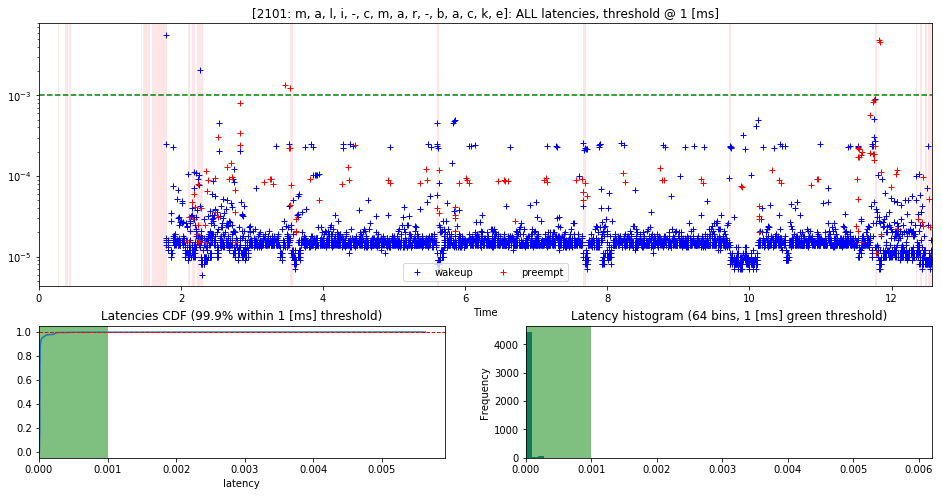

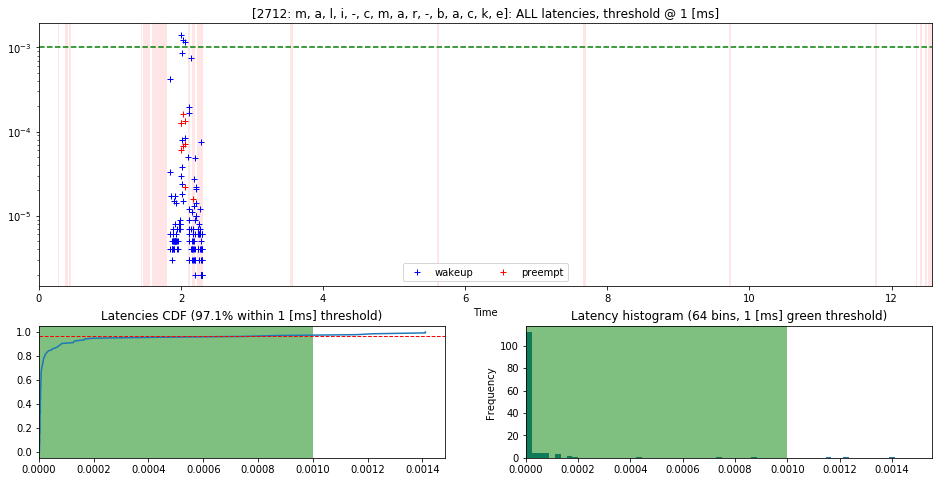

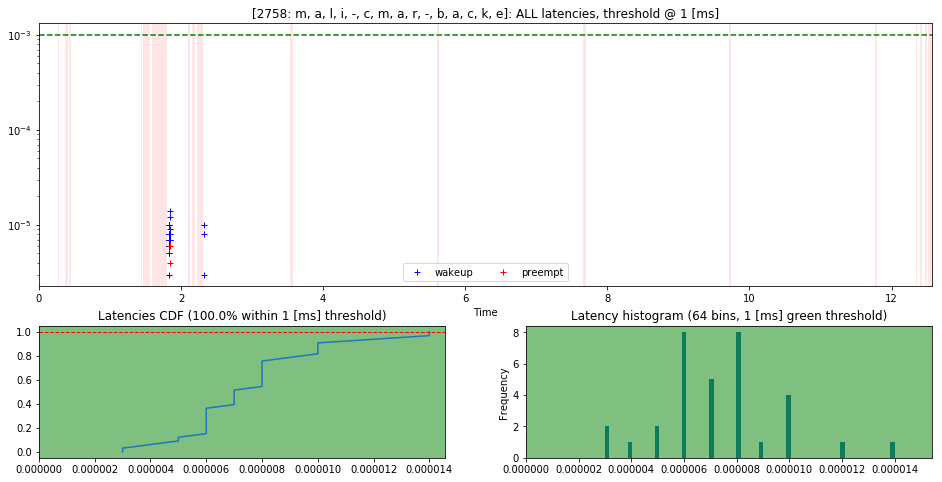

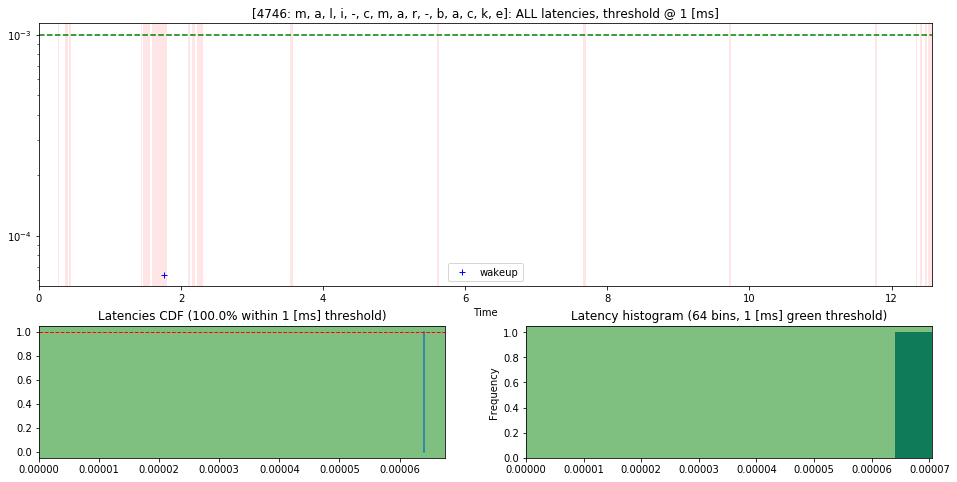

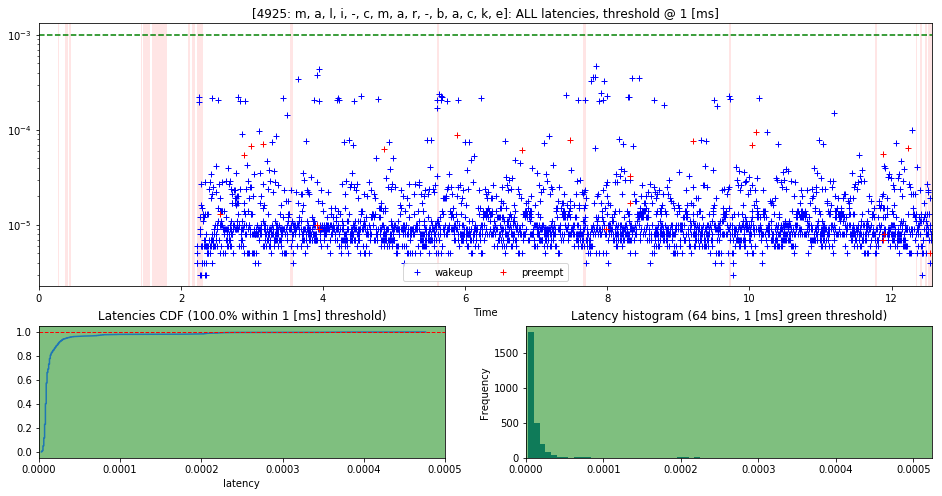

In [15]:
plot_task_scheduling_latency("mali-cmar-backe")

2017-11-08 14:30:23,314 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:23,315 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:23,800 INFO    : Analysis     : Found:   107 WAKEUP latencies
2017-11-08 14:30:23,853 INFO    : Analysis     : Found:     2 PREEMPT latencies
2017-11-08 14:30:23,856 INFO    : Analysis     : Total:   109 latency events
2017-11-08 14:30:23,861 INFO    : Analysis     : 98.2 % samples below 1 [ms] threshold
2017-11-08 14:30:25,114 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:25,292 INFO    : Analysis     : Found:    12 WAKEUP latencies
2017-11-08 14:30:25,352 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:30:25,354 INFO    : Analysis     : Total:    12 latency events
2017-11-08 14:30:25,358 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:30:26,686 INFO    : Analysis     : Parsing sc

2017-11-08 14:30:55,188 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:55,811 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:30:56,009 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:30:56,011 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:30:56,015 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:30:57,313 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:57,315 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:57,329 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:30:57,969 INFO    : Analysis     : Found:   104 WAKEUP latencies
2017-11-08 14:30:58,176 INFO    : Analysis     : Found:     1 PREEMPT latencies
2017-11-08 14:30:58,179 INFO    : Analysis     : Total:   105 latency events
2017-11-08 14:30:58,182 INFO    : Analysis     :

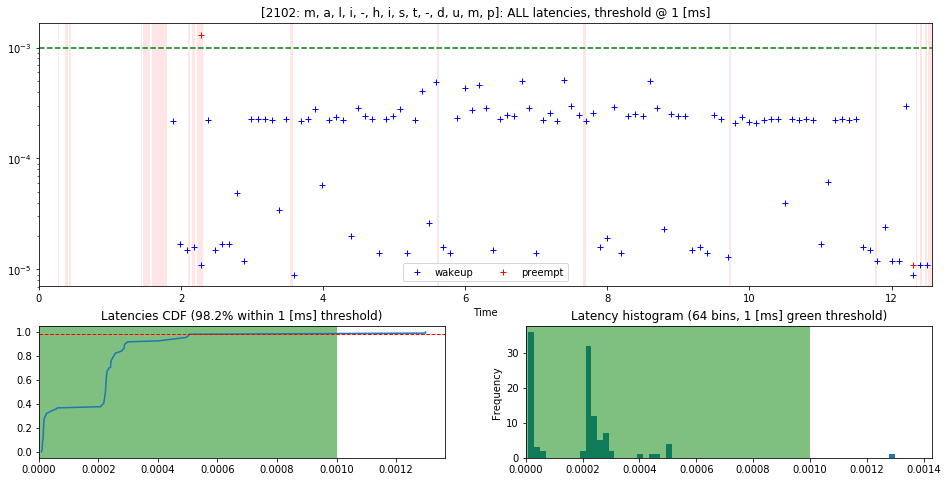

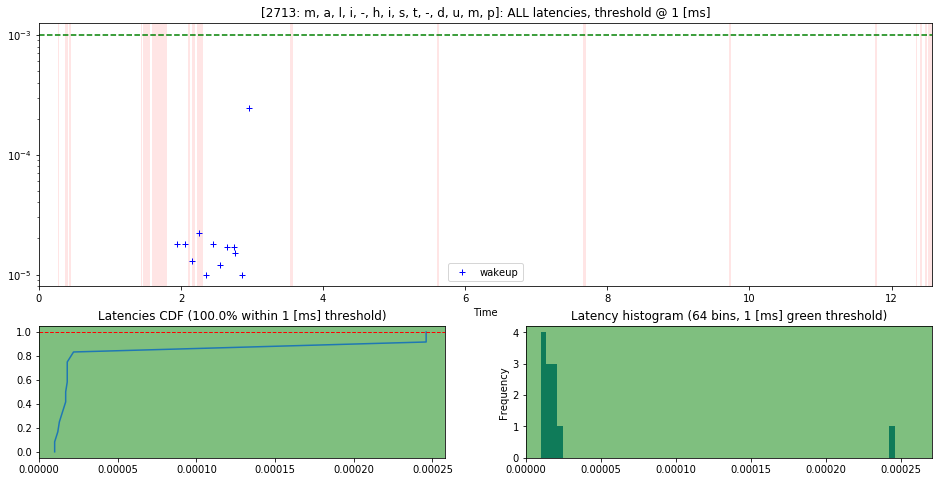

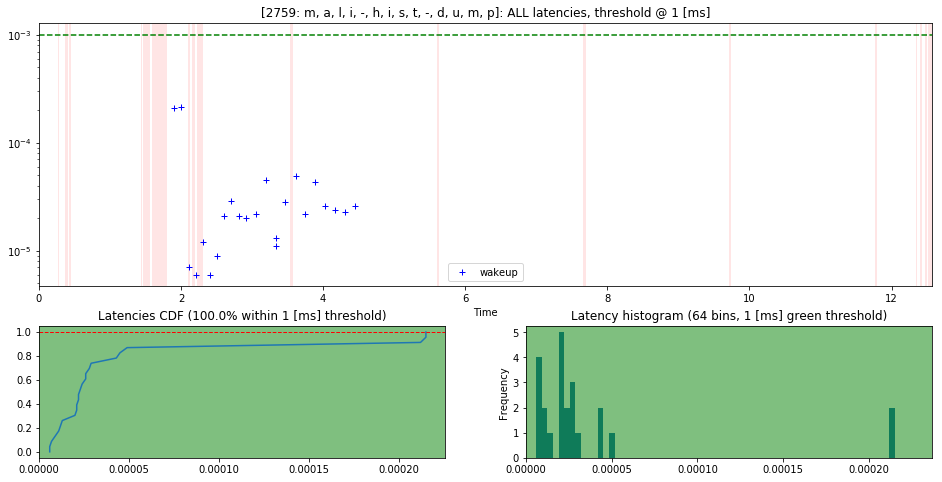

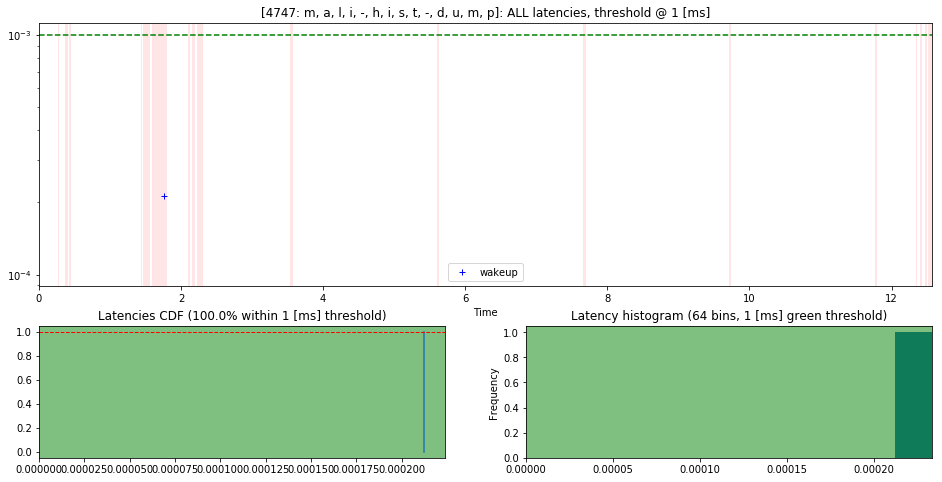

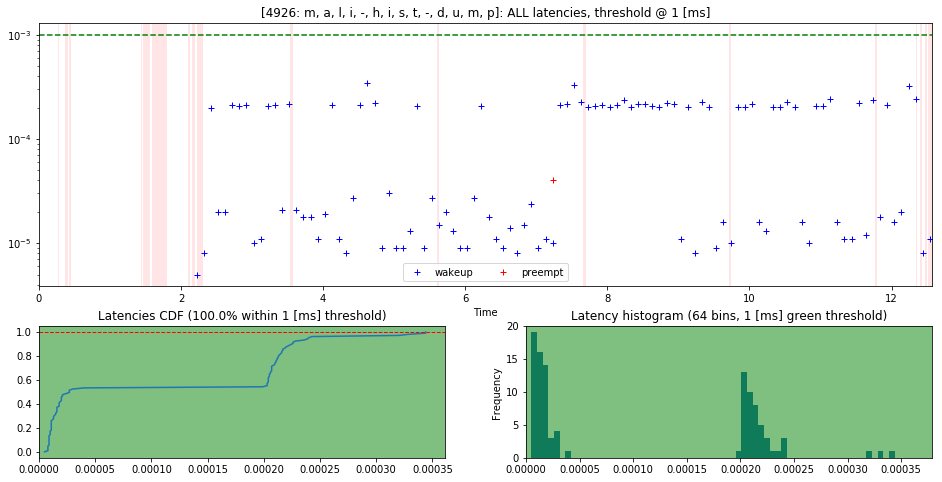

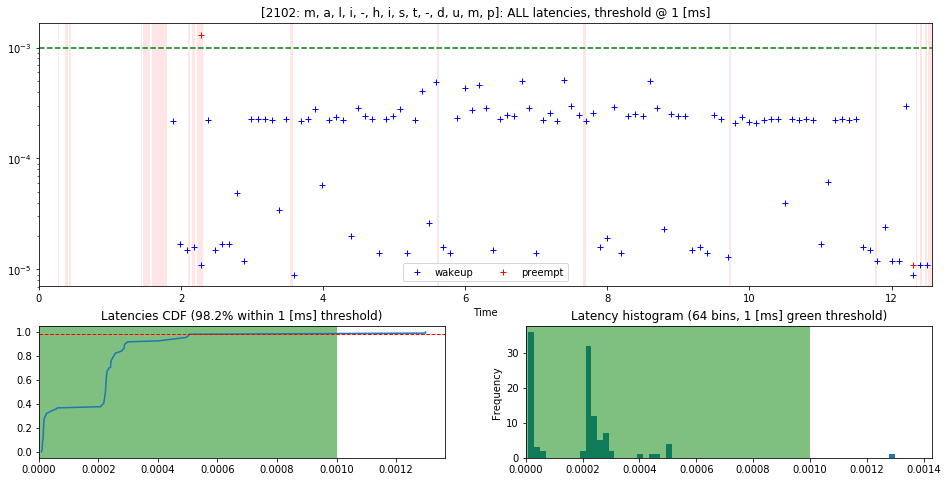

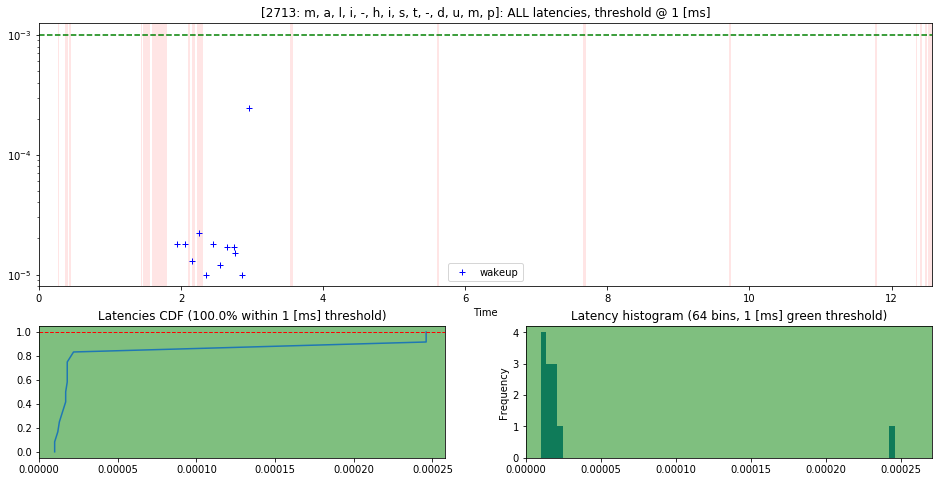

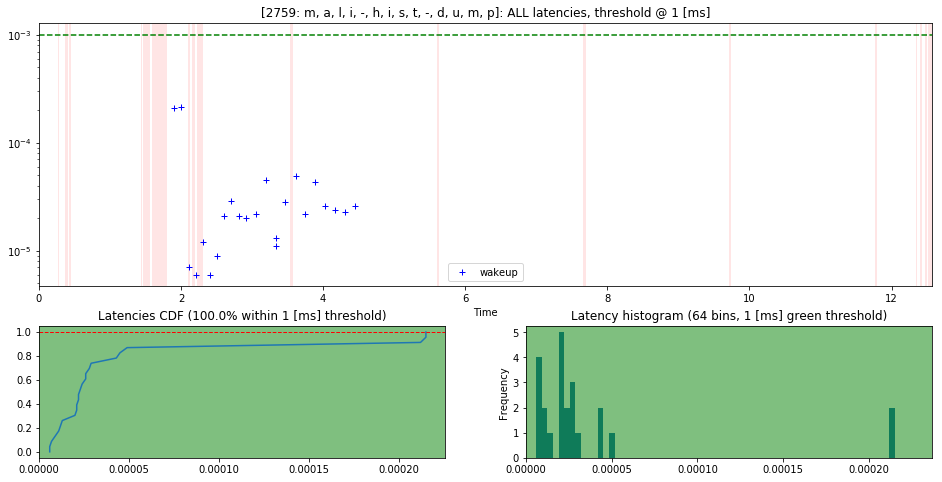

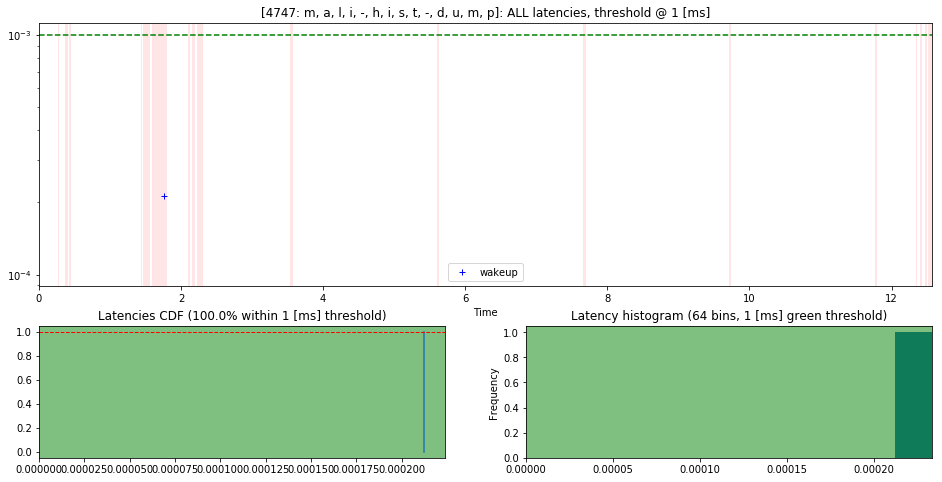

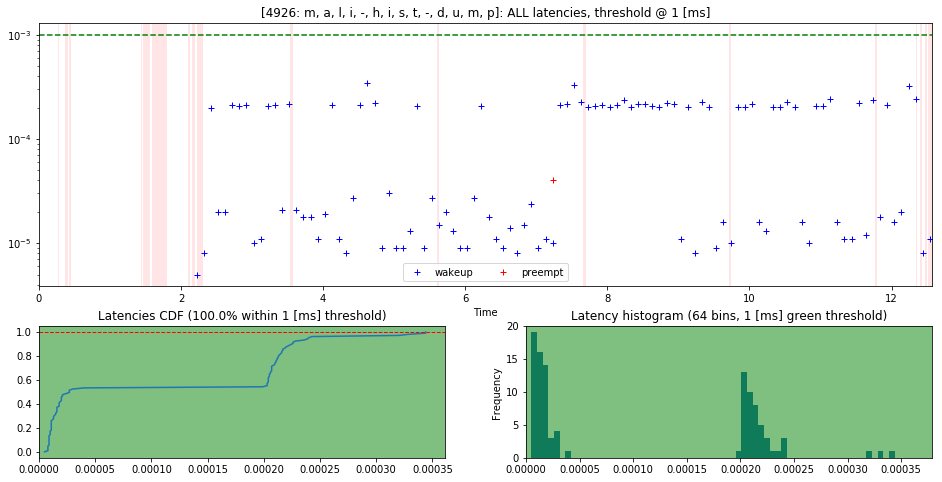

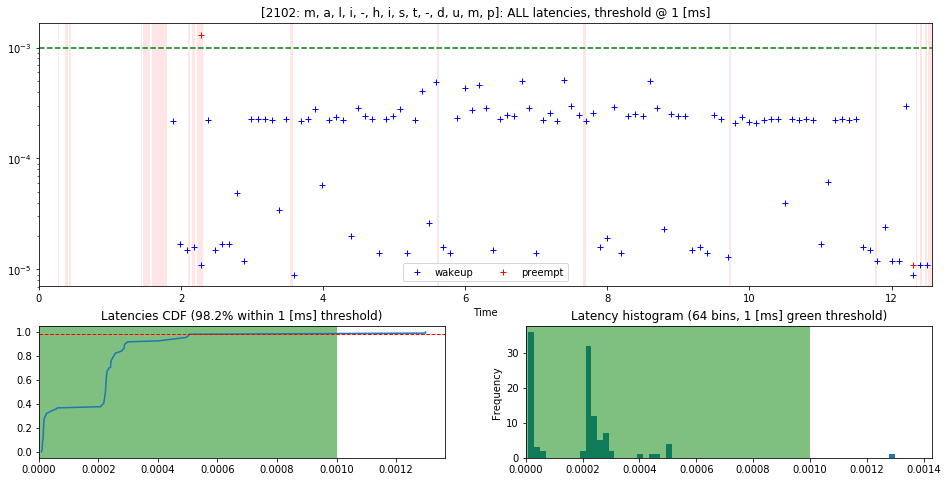

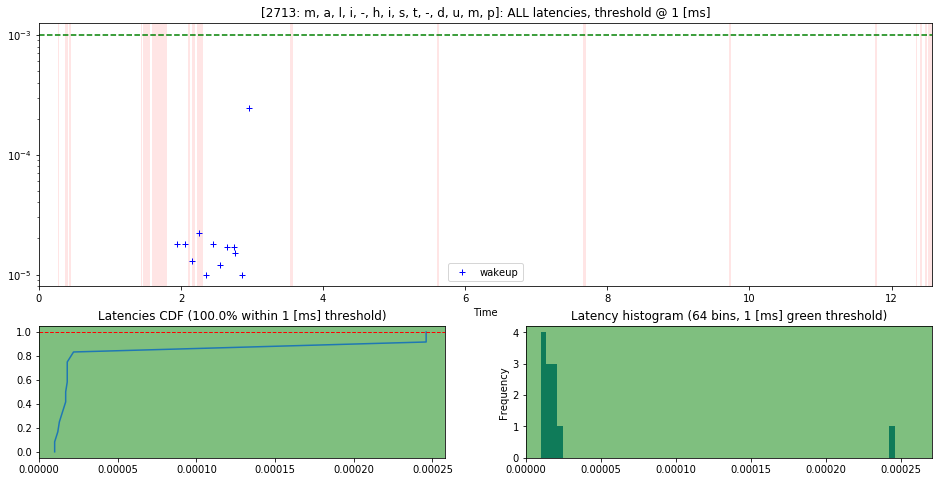

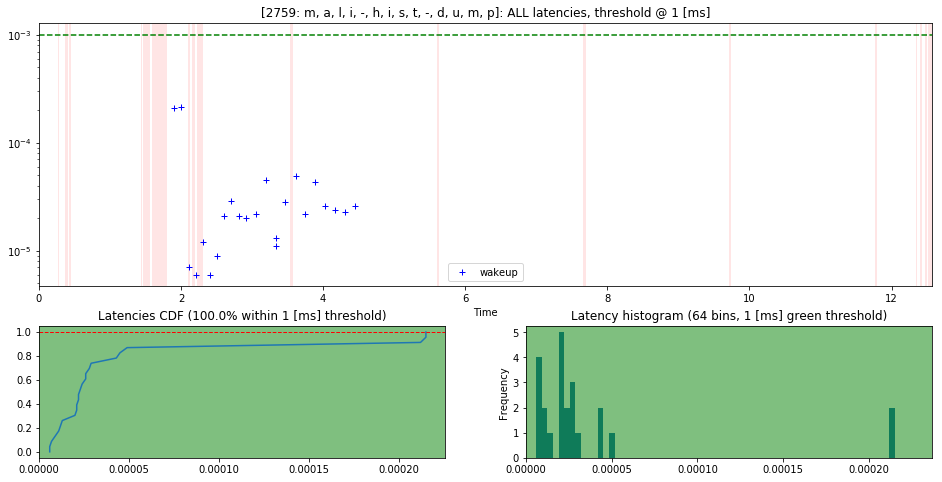

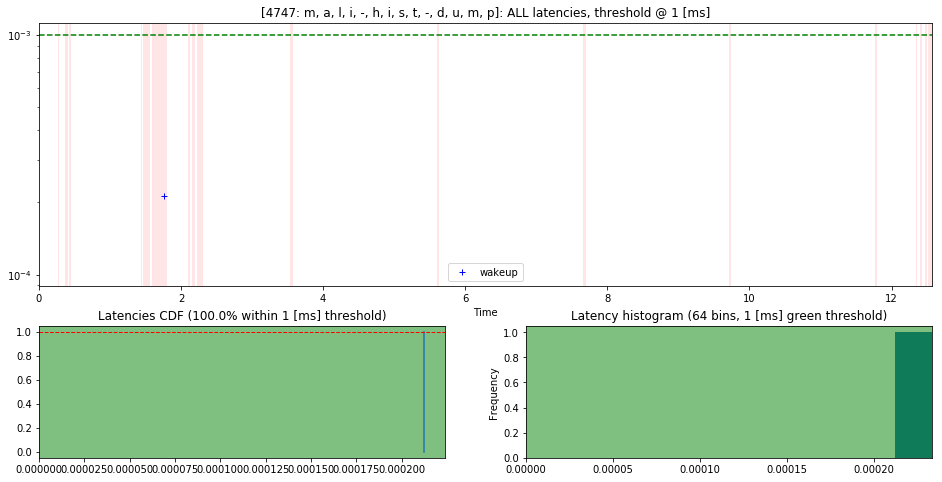

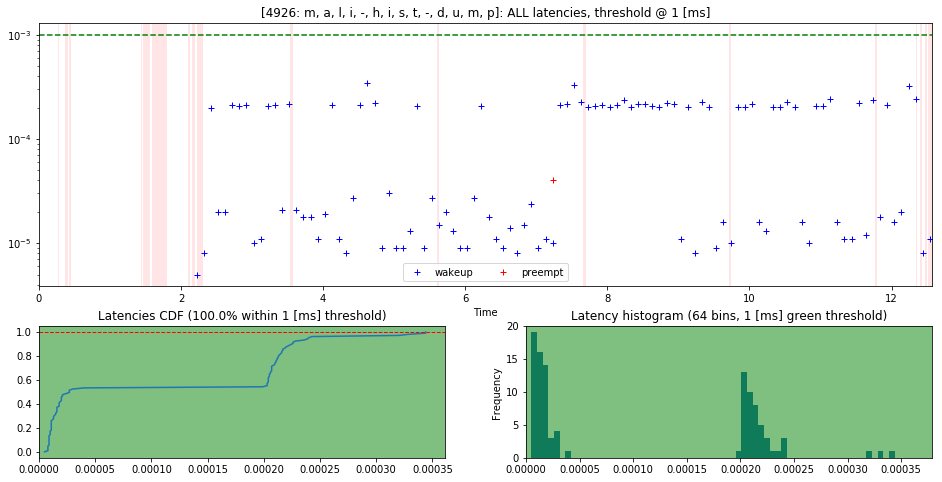

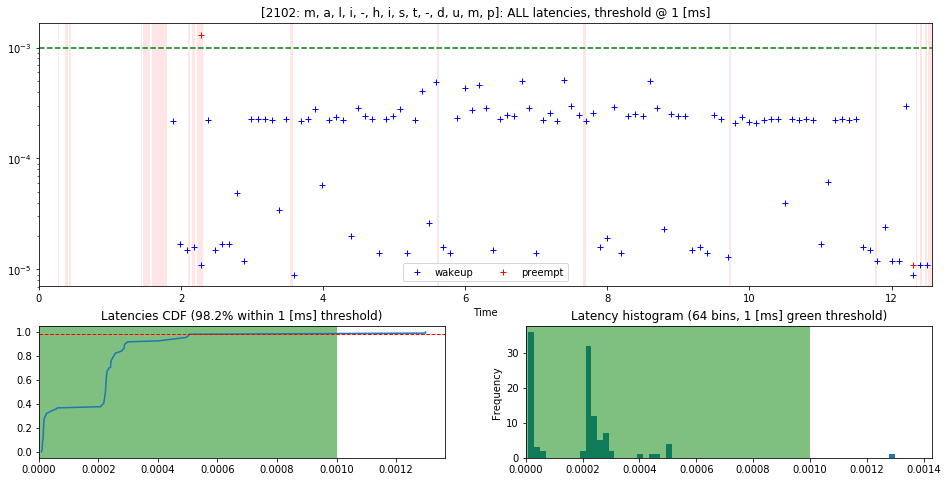

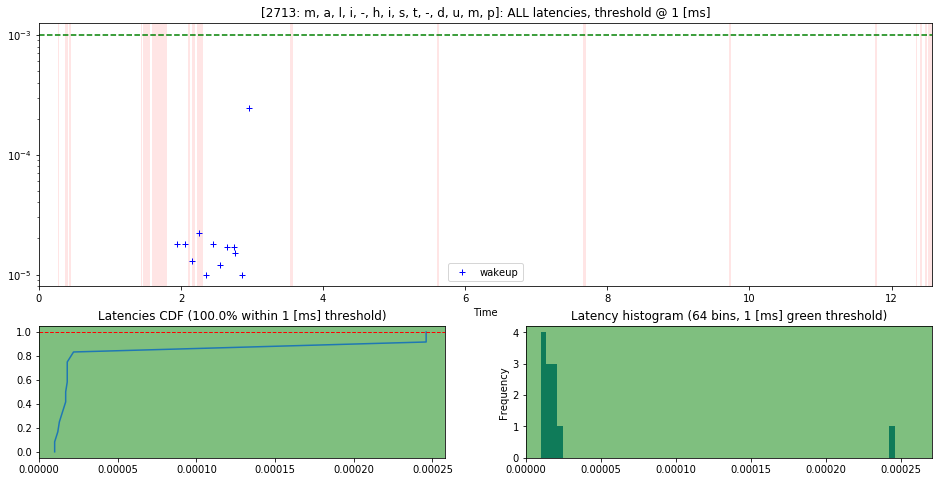

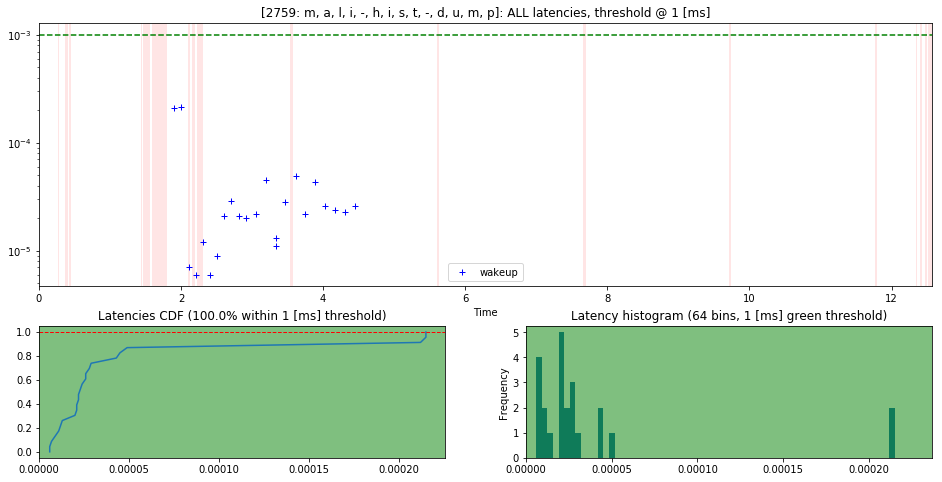

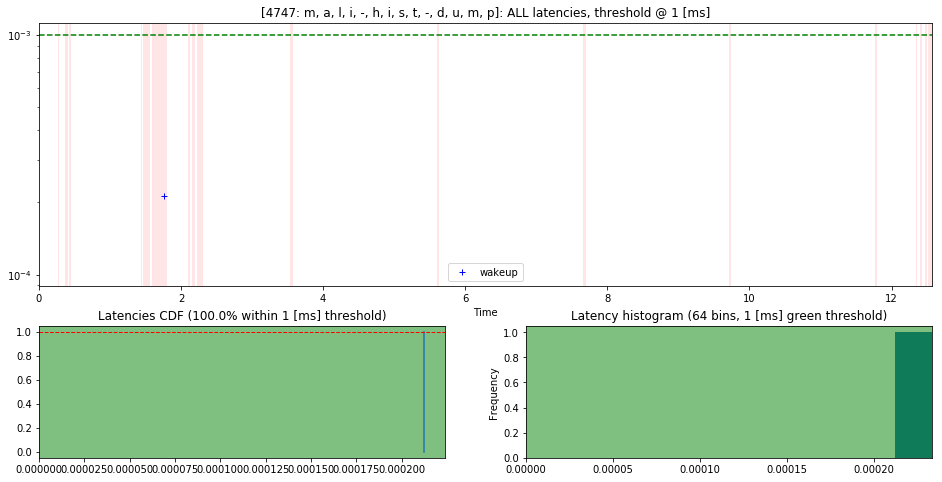

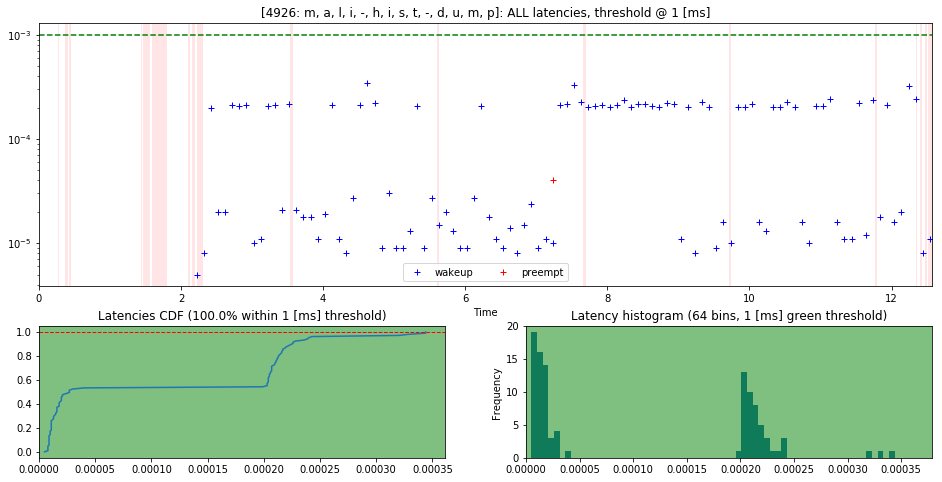

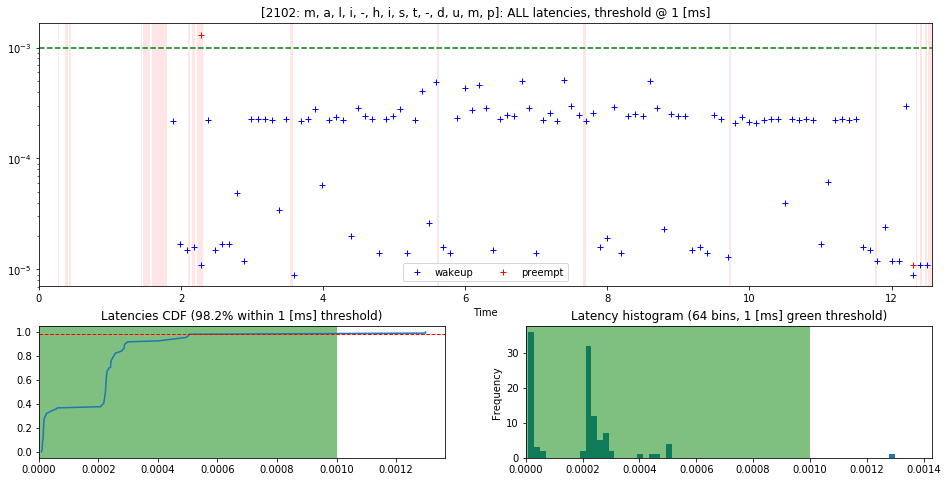

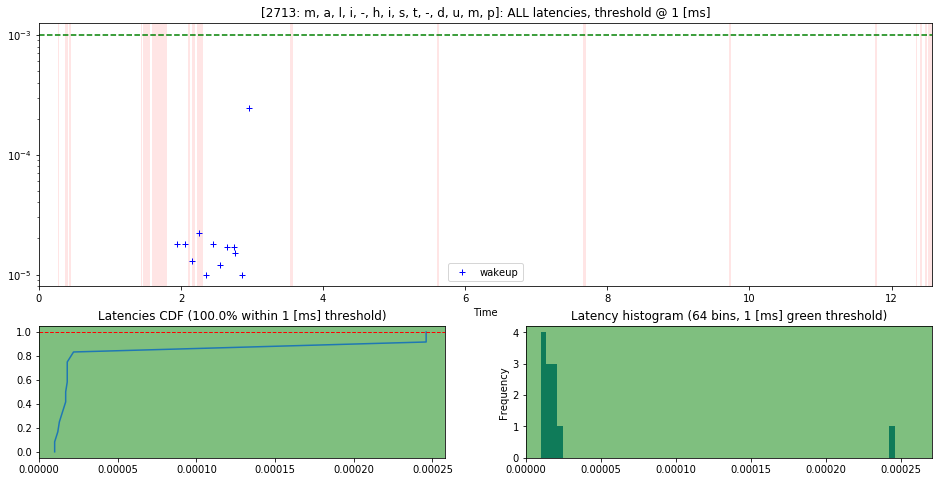

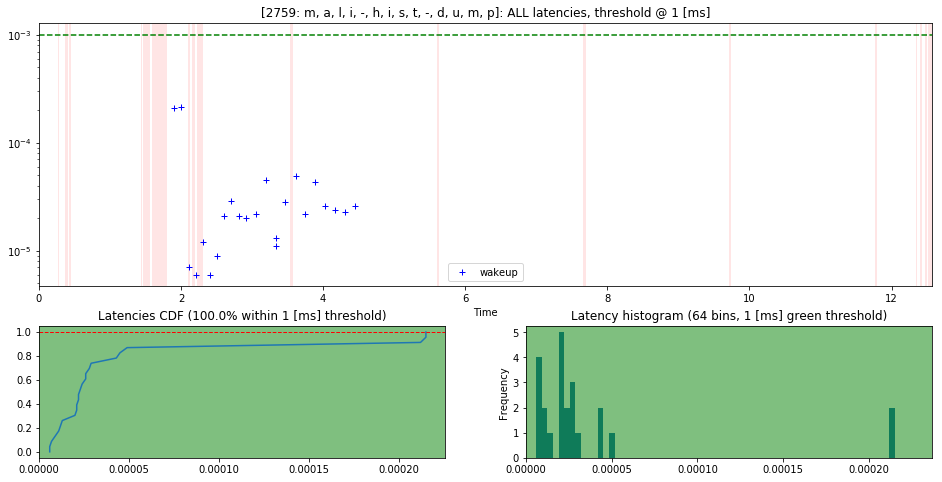

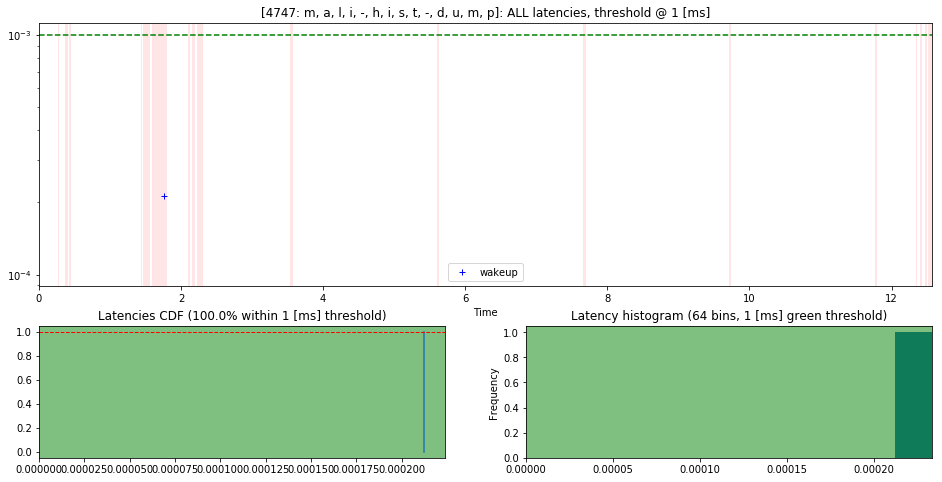

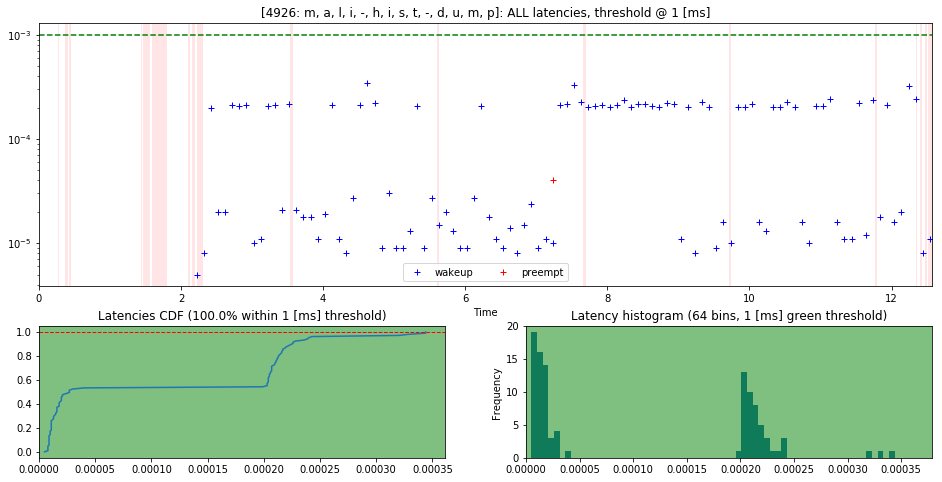

In [16]:
plot_task_scheduling_latency("mali-hist-dump")

2017-11-08 14:31:24,451 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:24,924 INFO    : Analysis     : Found:   108 WAKEUP latencies
2017-11-08 14:31:24,972 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:31:24,975 INFO    : Analysis     : Total:   108 latency events
2017-11-08 14:31:24,979 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:31:26,256 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:26,259 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:26,447 INFO    : Analysis     : Found:    14 WAKEUP latencies
2017-11-08 14:31:26,503 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:31:26,505 INFO    : Analysis     : Total:    14 latency events
2017-11-08 14:31:26,509 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:31:27,588 INFO    : Analysis     : Parsing s

2017-11-08 14:31:54,844 INFO    : Analysis     : Found:    24 WAKEUP latencies
2017-11-08 14:31:55,043 INFO    : Analysis     : Found:     4 PREEMPT latencies
2017-11-08 14:31:55,045 INFO    : Analysis     : Total:    28 latency events
2017-11-08 14:31:55,054 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:31:56,477 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:57,116 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:31:57,326 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:31:57,329 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:31:57,333 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:31:58,399 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:58,401 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:31:58,406 INFO    : Analysis     : Parsing s

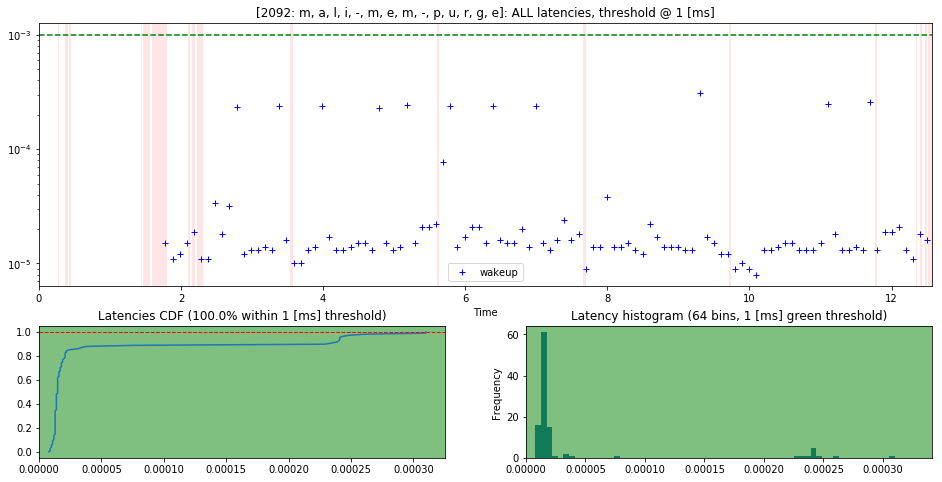

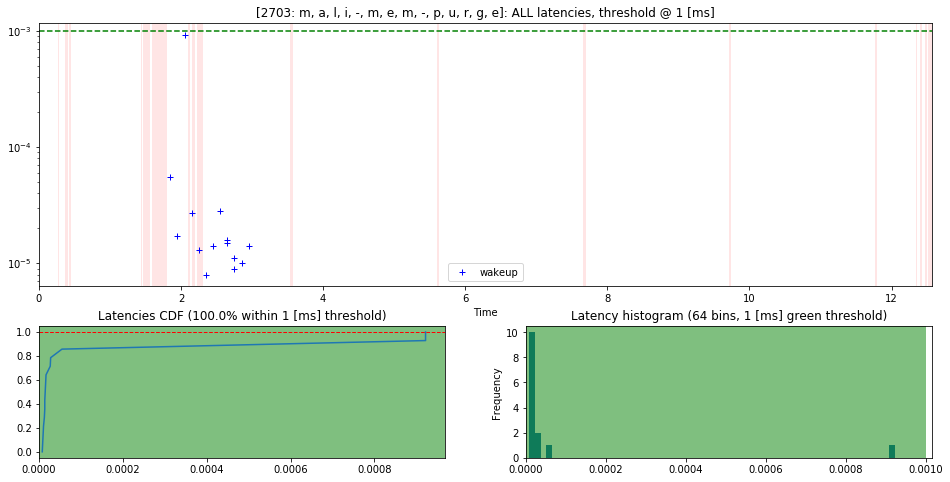

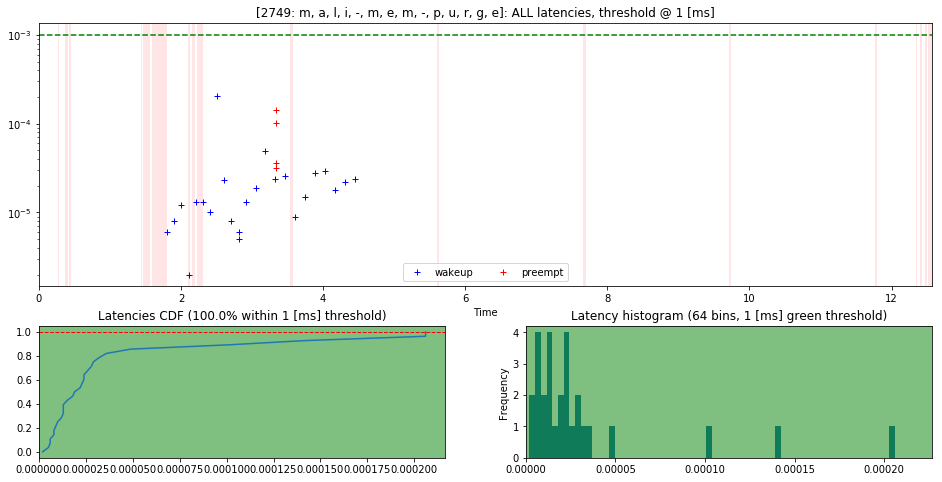

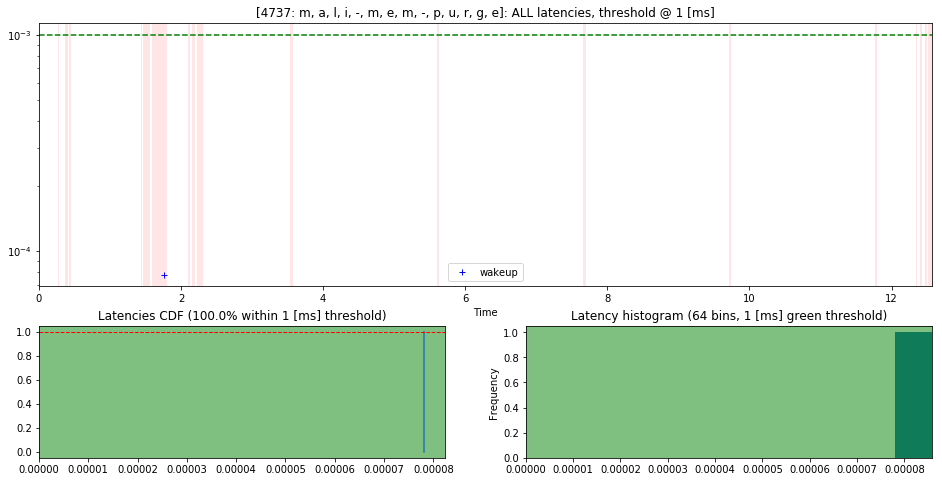

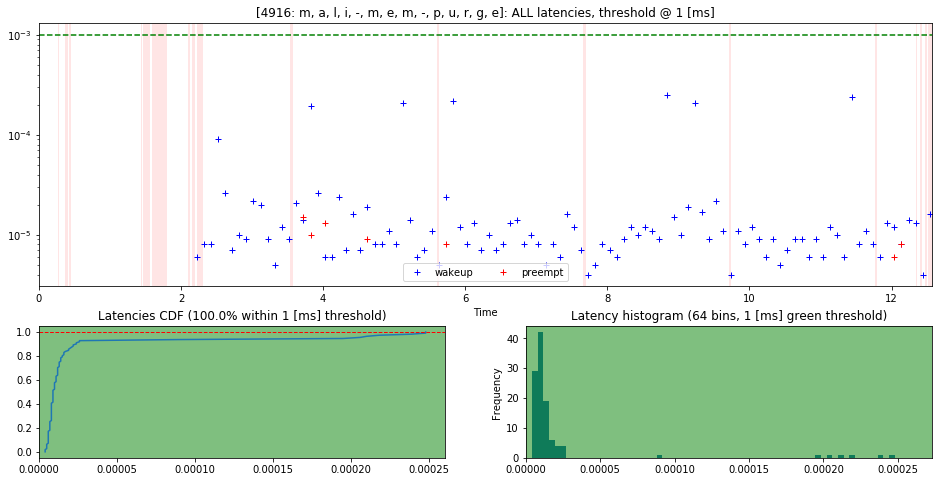

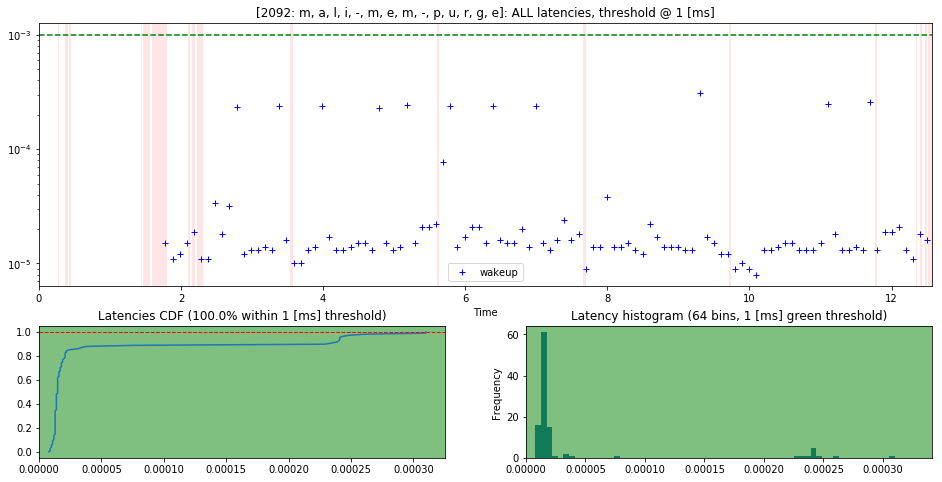

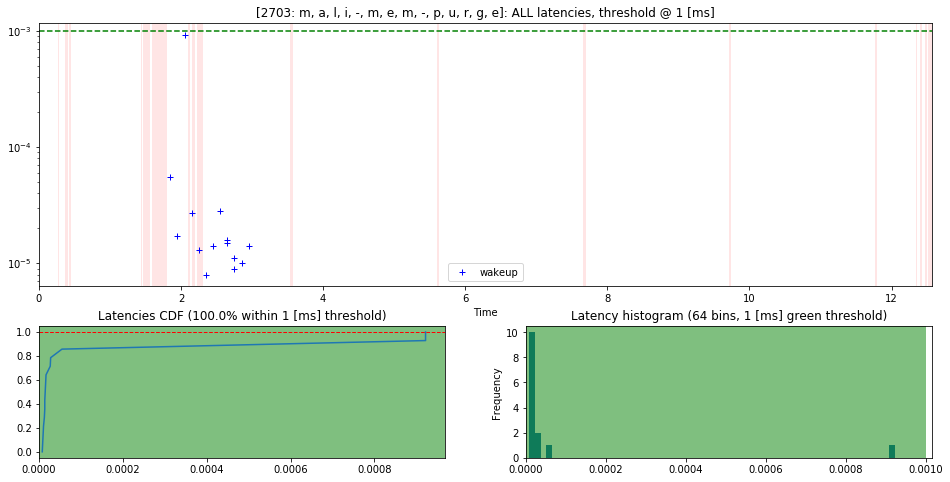

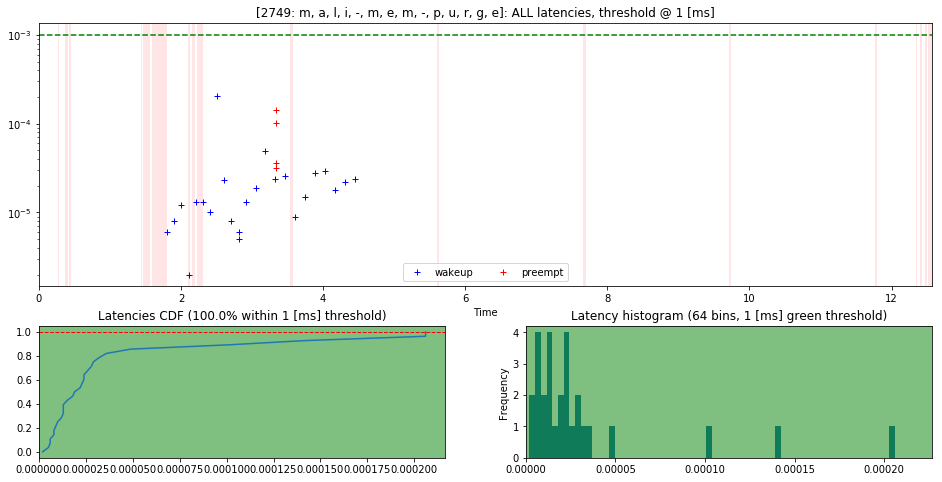

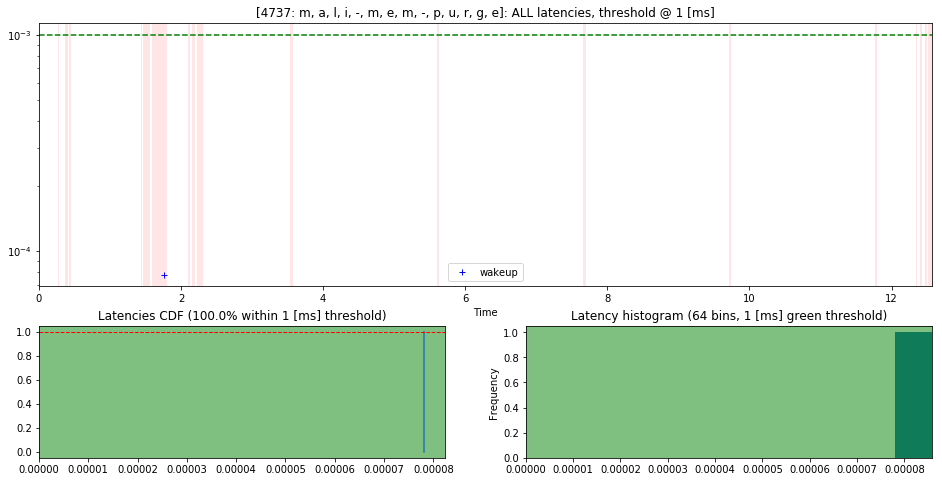

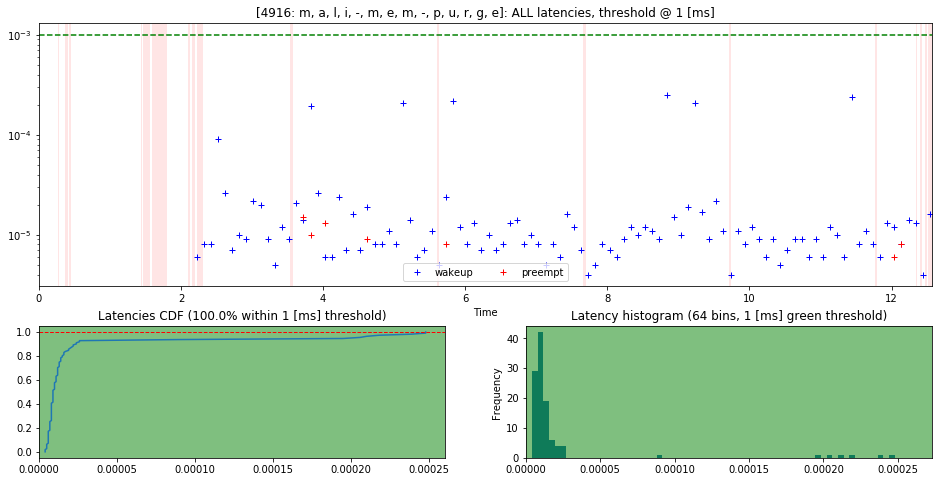

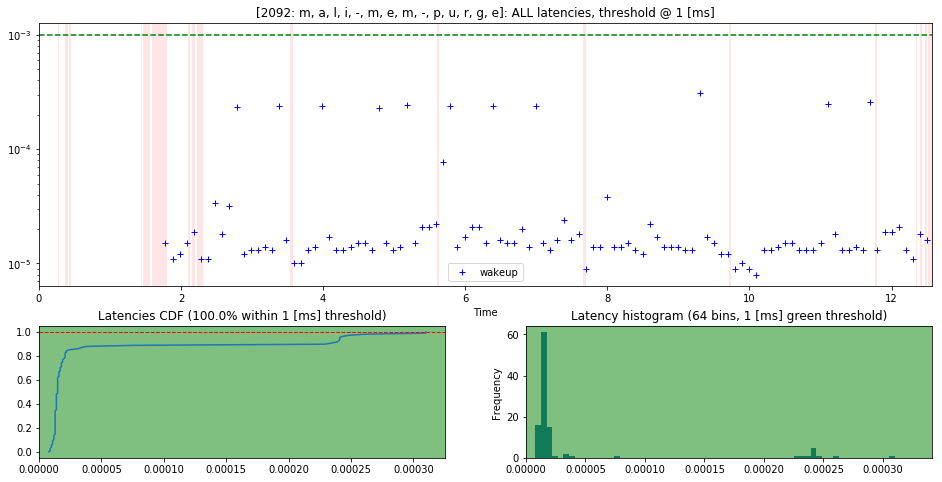

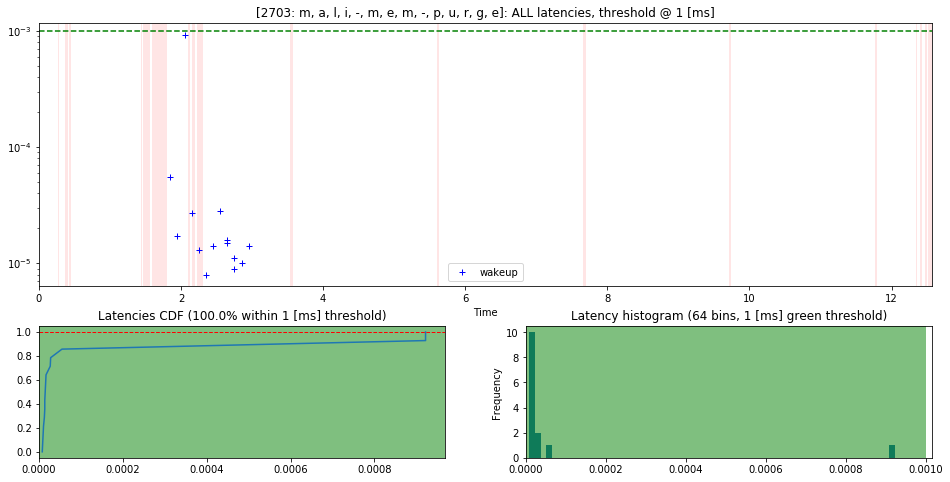

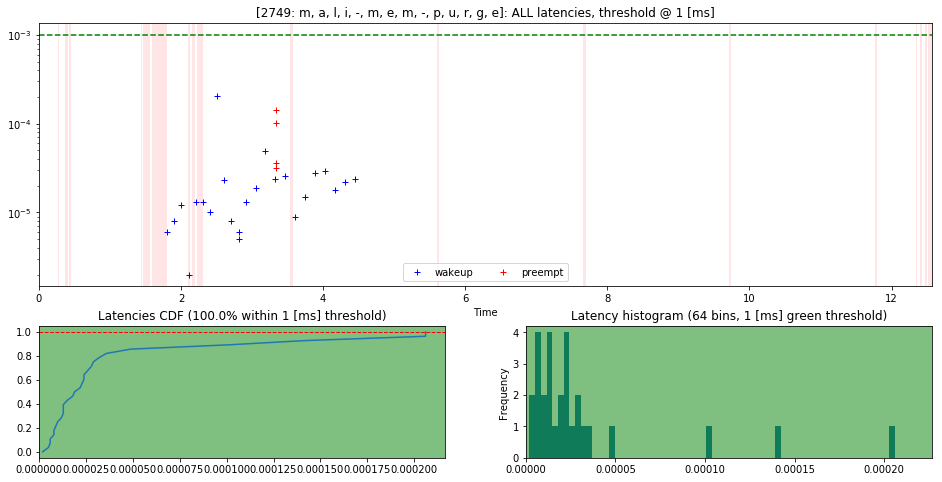

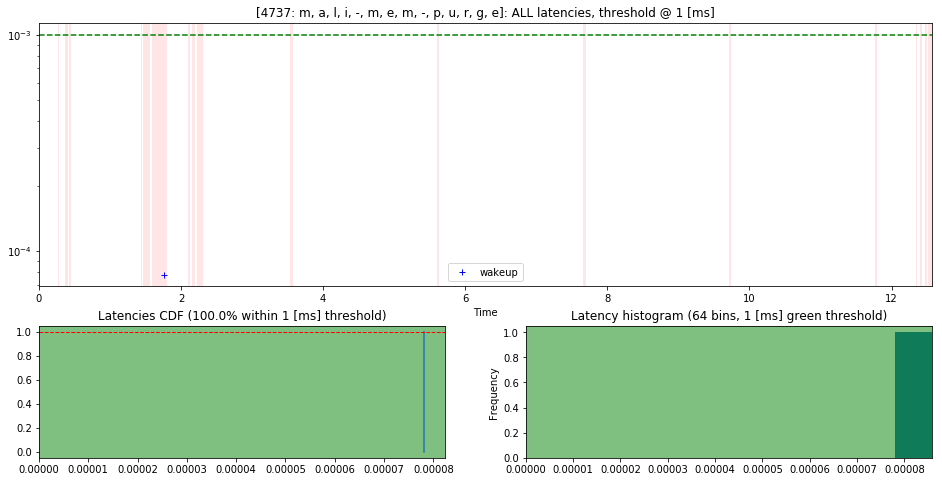

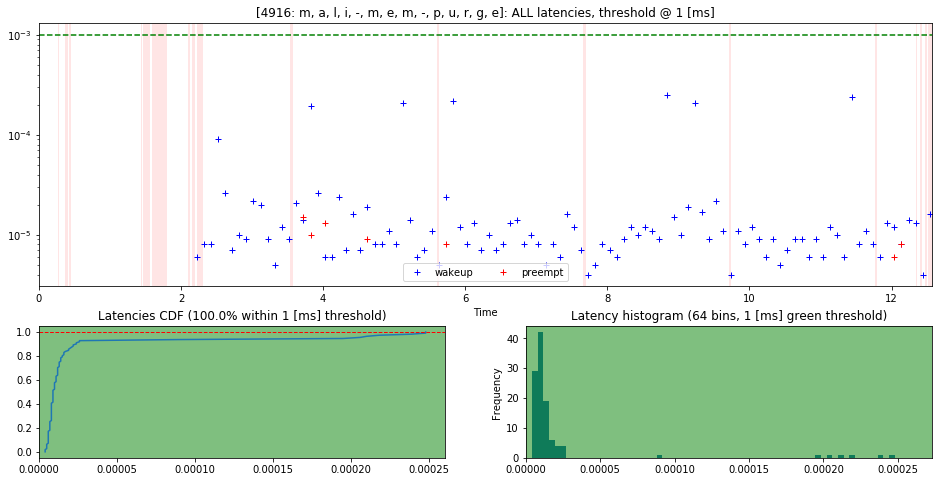

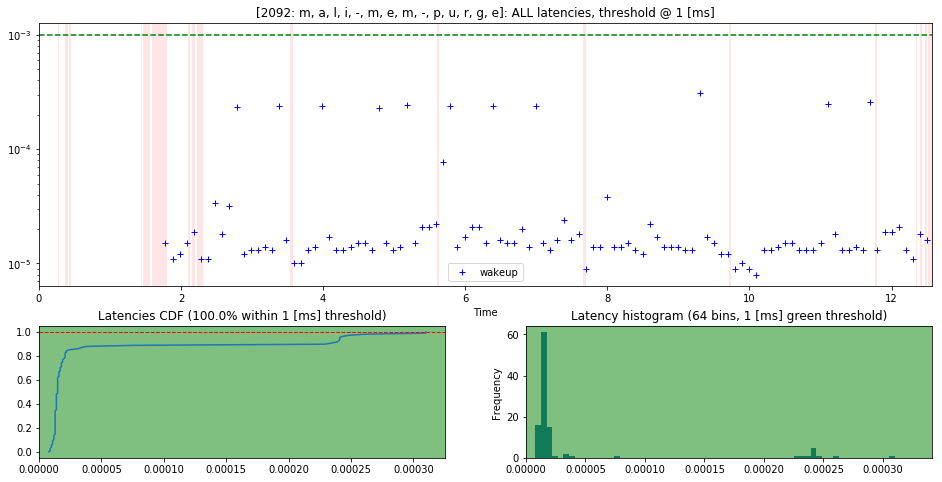

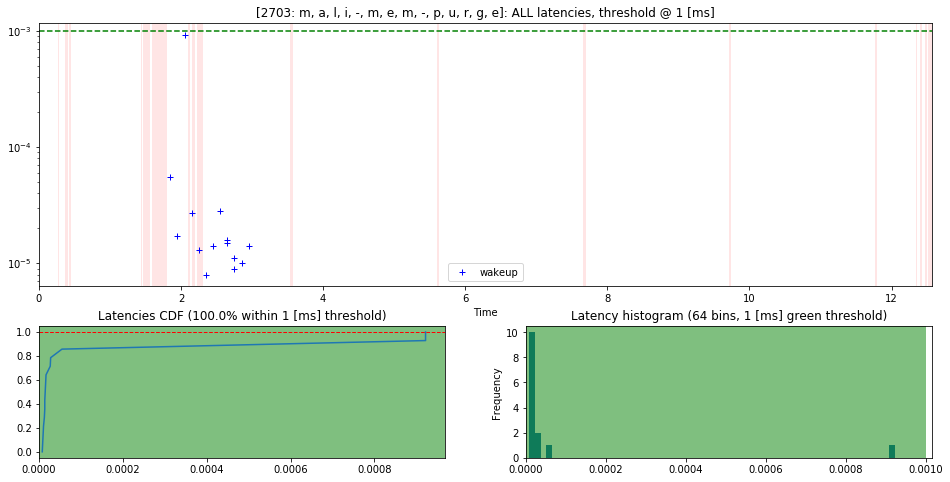

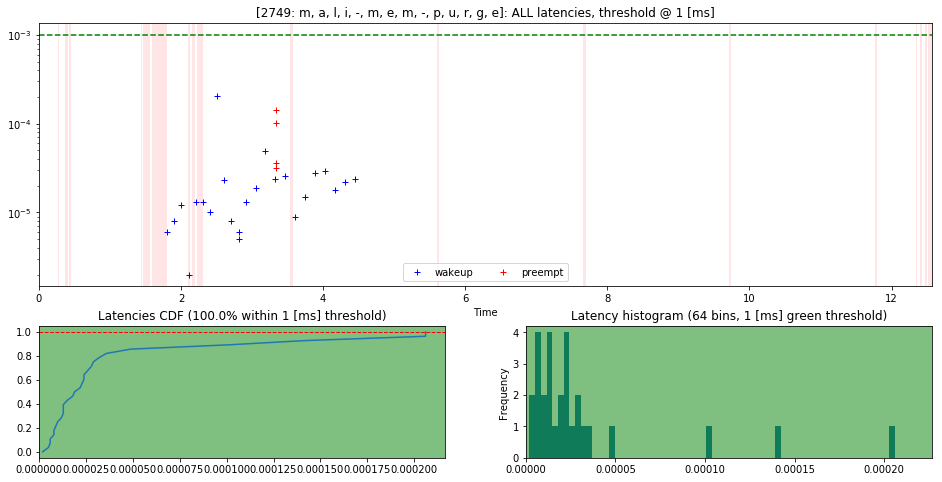

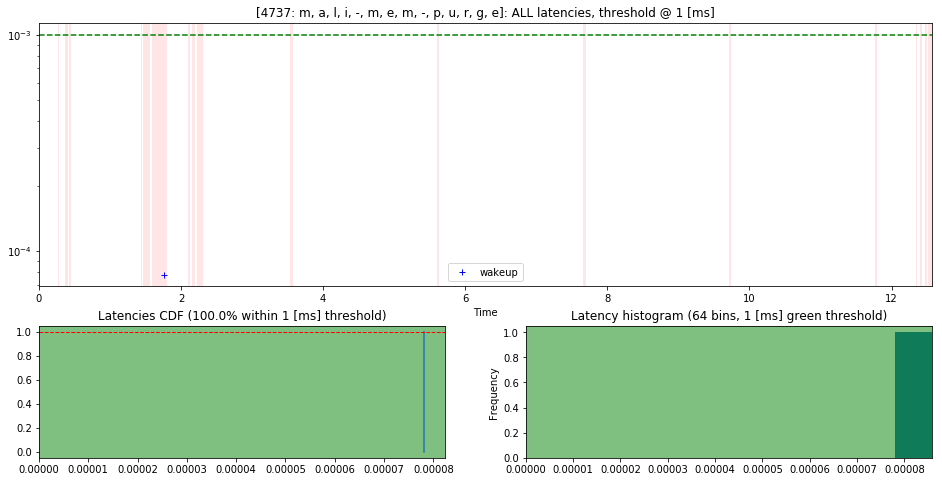

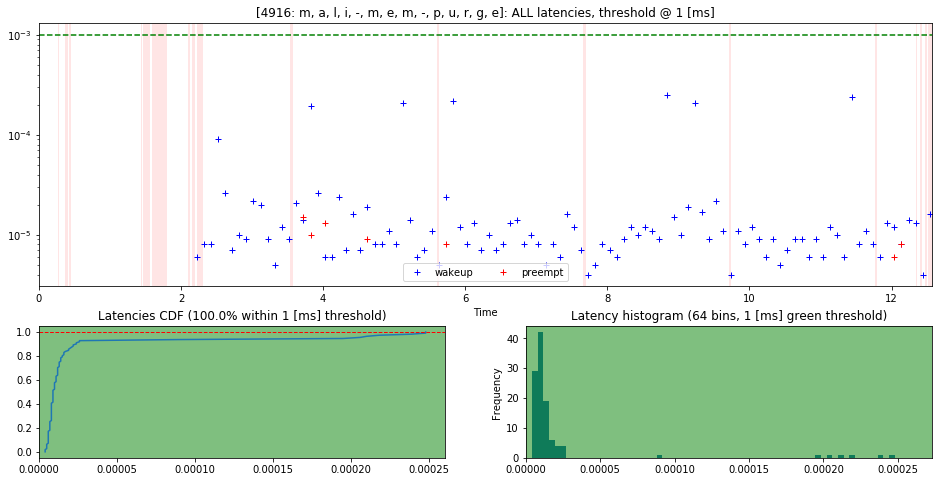

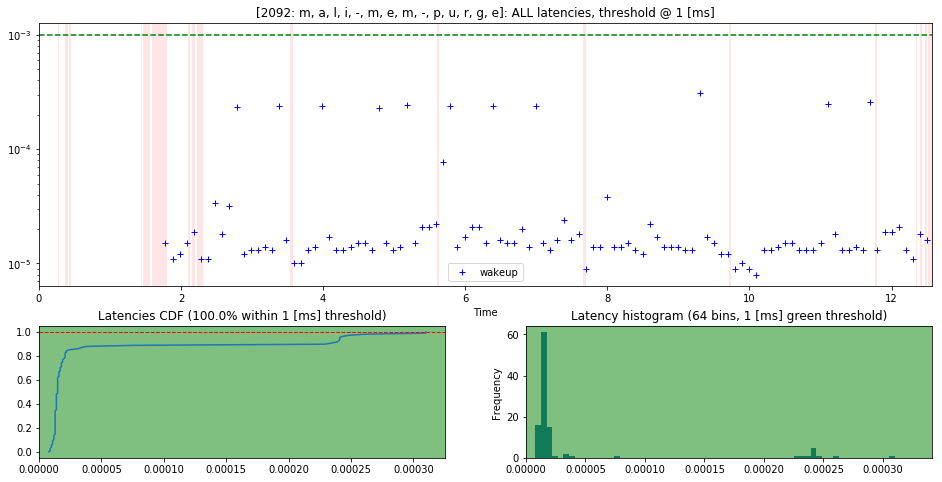

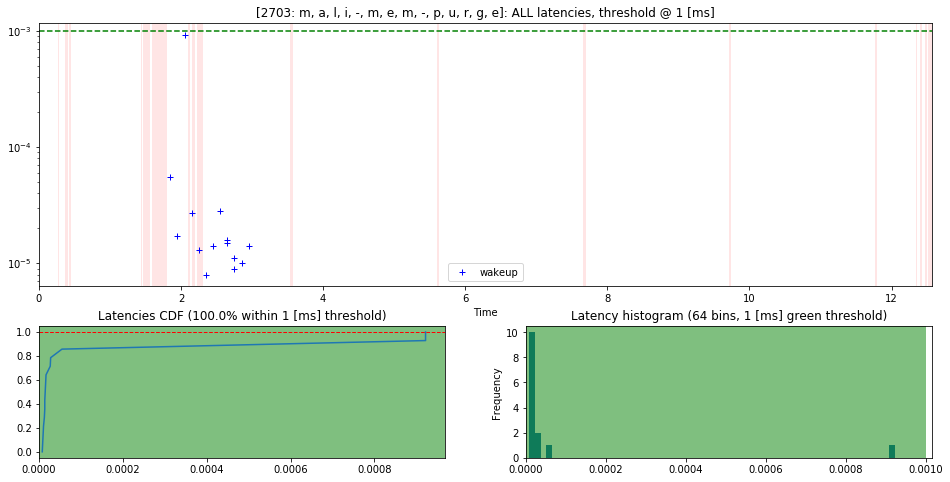

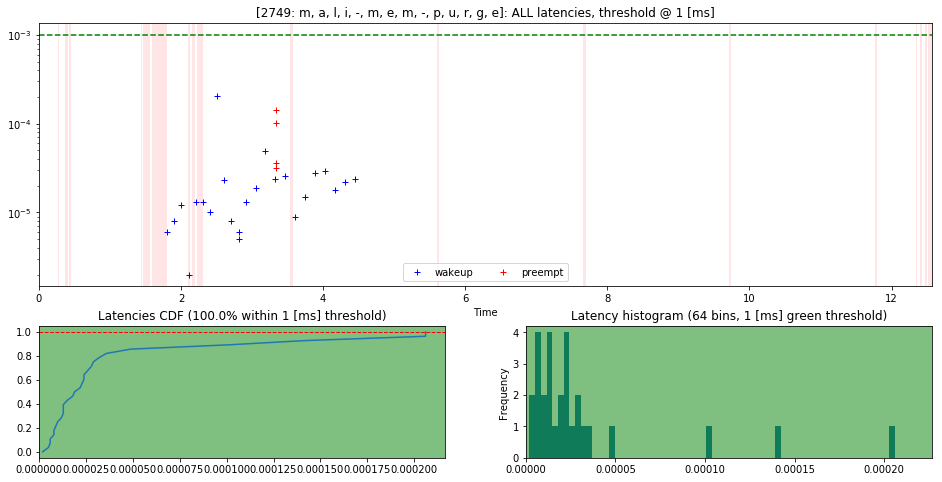

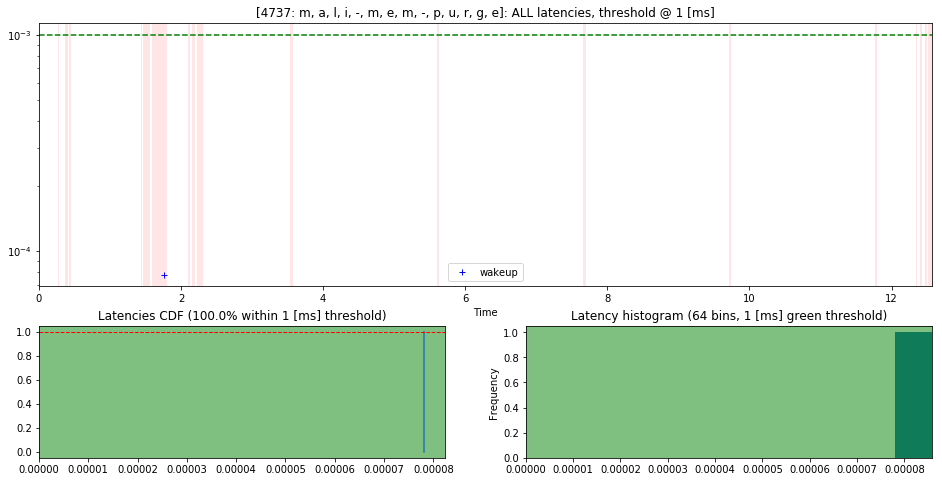

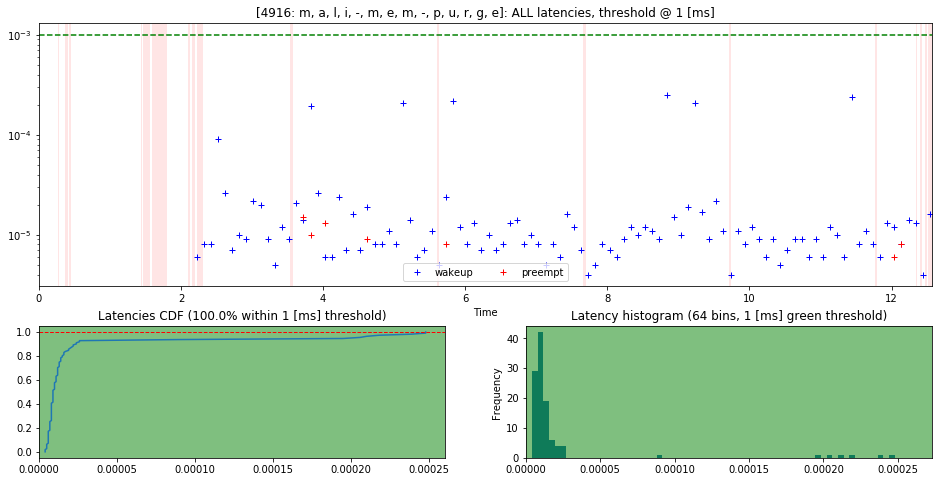

In [17]:
plot_task_scheduling_latency("mali-mem-purge")

2017-11-08 14:32:27,455 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:27,456 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:27,467 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:27,470 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:28,075 INFO    : Analysis     : Found:  2523 WAKEUP latencies
2017-11-08 14:32:28,126 INFO    : Analysis     : Found:    36 PREEMPT latencies
2017-11-08 14:32:28,129 INFO    : Analysis     : Total:  2559 latency events
2017-11-08 14:32:28,131 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:32:29,378 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:29,380 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:29,571 INFO    : Analysis     : Found:     9 WAKEUP latencies
2017-11-0

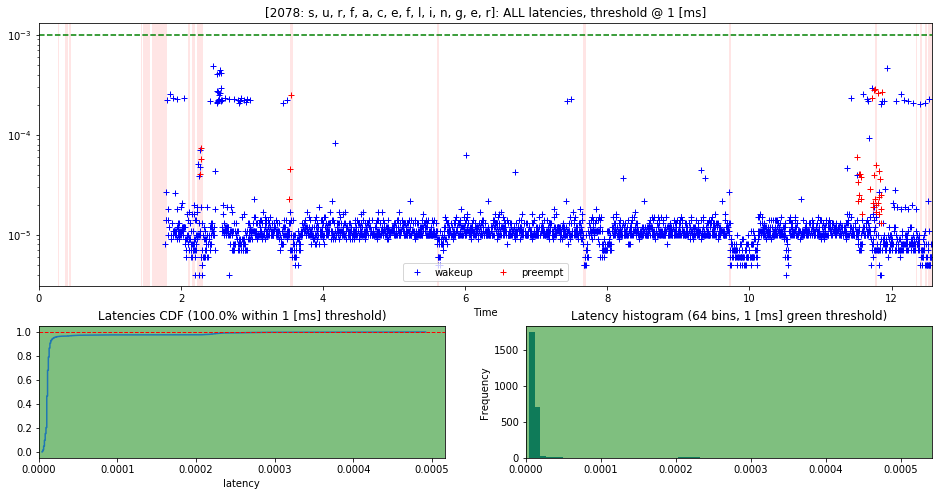

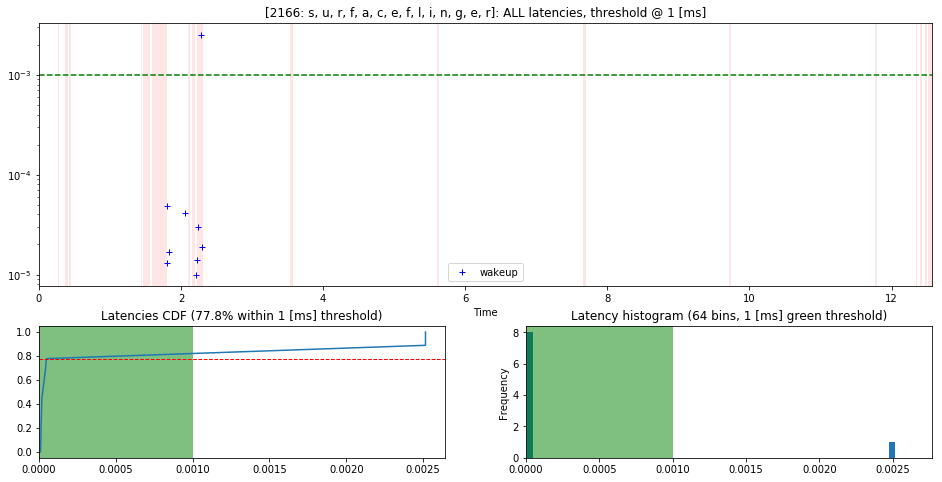

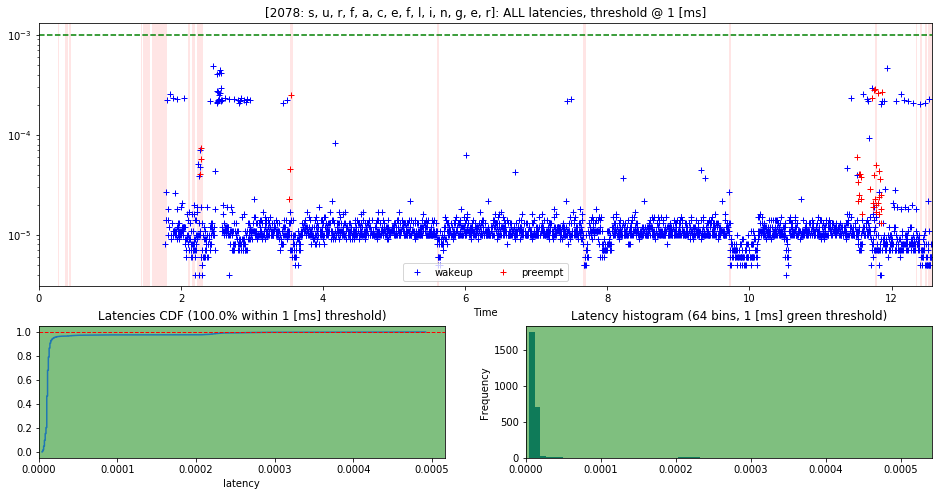

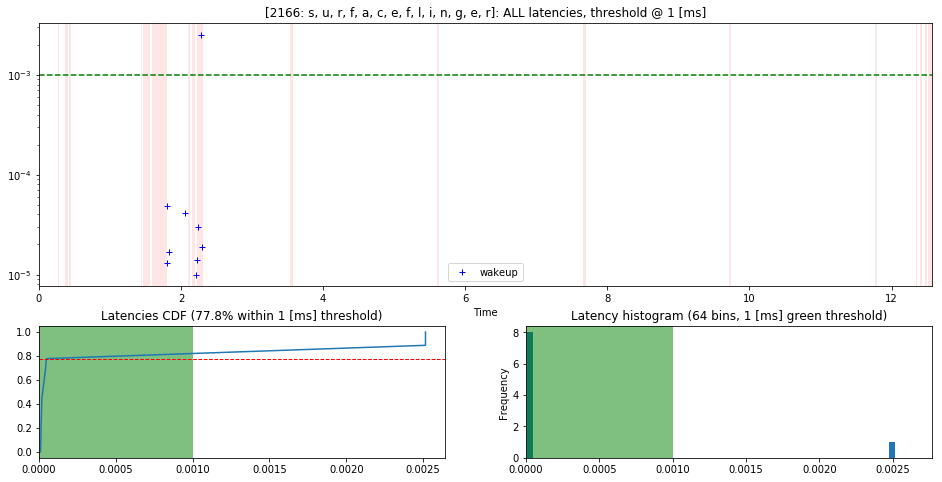

In [18]:
plot_task_scheduling_latency("surfaceflinger")

2017-11-08 14:32:36,397 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:36,401 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:36,405 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:36,410 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:36,637 INFO    : Analysis     : Found:   136 WAKEUP latencies
2017-11-08 14:32:36,687 INFO    : Analysis     : Found:    73 PREEMPT latencies
2017-11-08 14:32:36,689 INFO    : Analysis     : Total:   209 latency events
2017-11-08 14:32:36,695 INFO    : Analysis     : 99.0 % samples below 1 [ms] threshold
2017-11-08 14:32:37,777 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:37,779 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:37,781 INFO    : Analysis     : Parsing sched_switch states assuming ker

2017-11-08 14:32:57,733 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:58,213 INFO    : Analysis     : Found:   136 WAKEUP latencies
2017-11-08 14:32:58,366 INFO    : Analysis     : Found:    73 PREEMPT latencies
2017-11-08 14:32:58,368 INFO    : Analysis     : Total:   209 latency events
2017-11-08 14:32:58,373 INFO    : Analysis     : 99.0 % samples below 1 [ms] threshold
2017-11-08 14:32:59,756 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:59,758 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:59,774 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:32:59,775 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:00,328 INFO    : Analysis     : Found:    49 WAKEUP latencies
2017-11-08 14:33:00,501 INFO    : Analysis     : Found:    17 PREEMPT latencies
2017-11-08 14:33:00,503 INFO

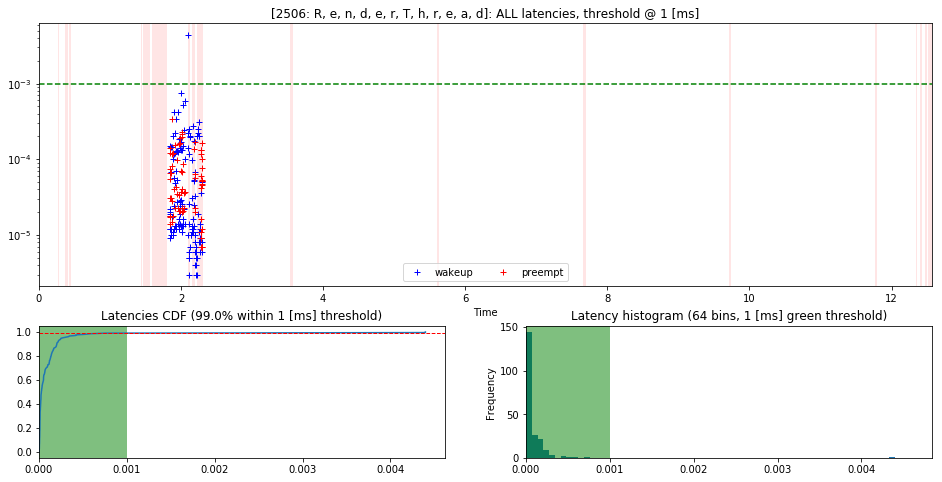

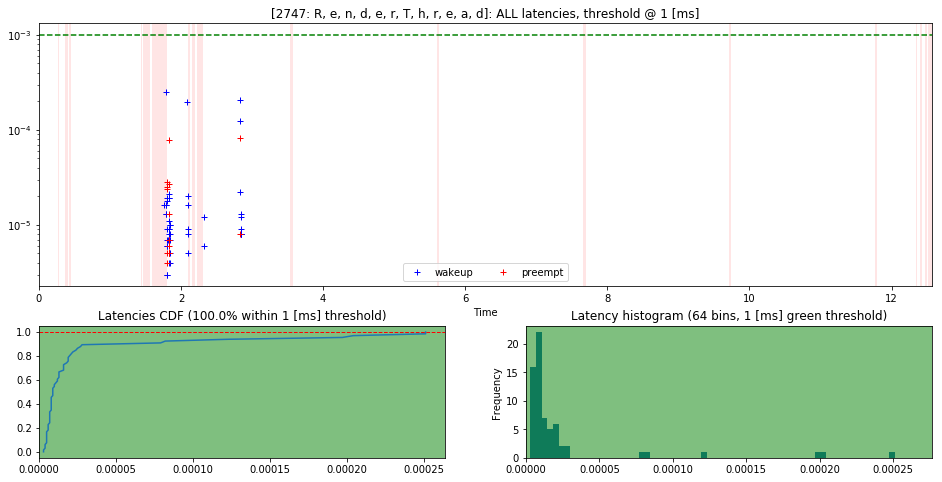

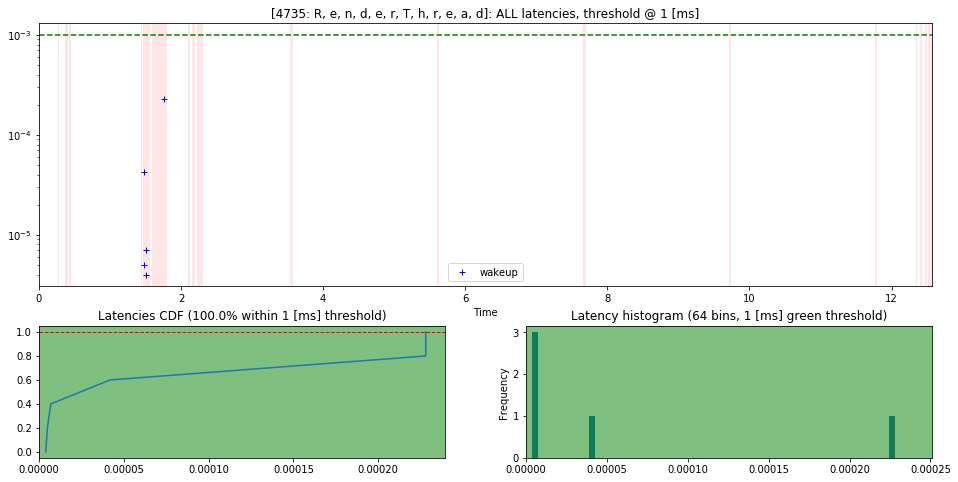

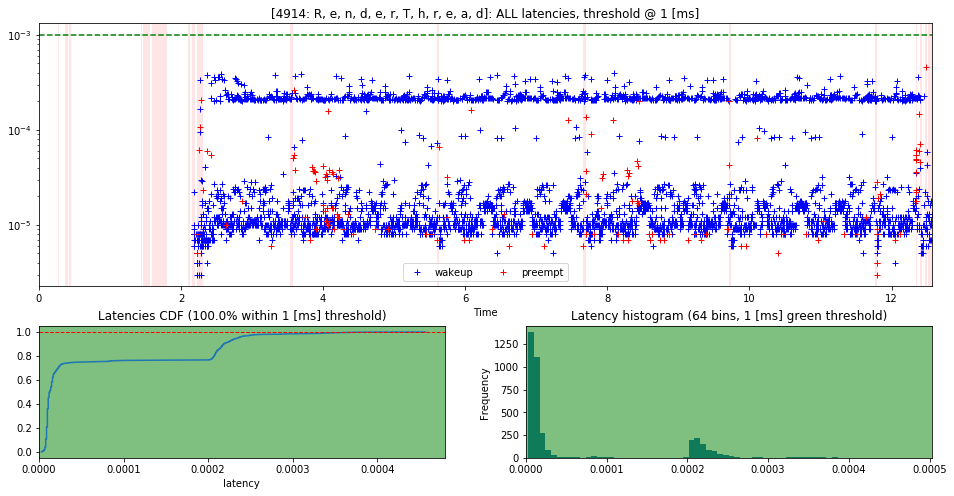

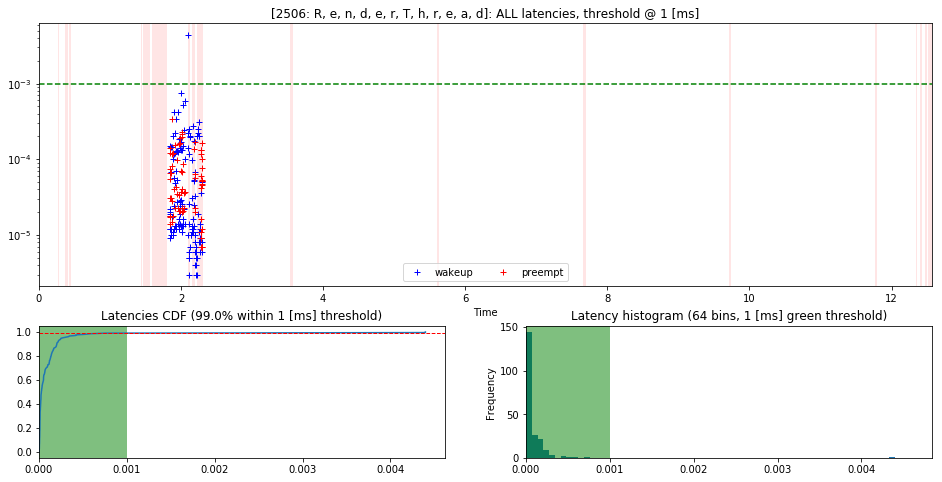

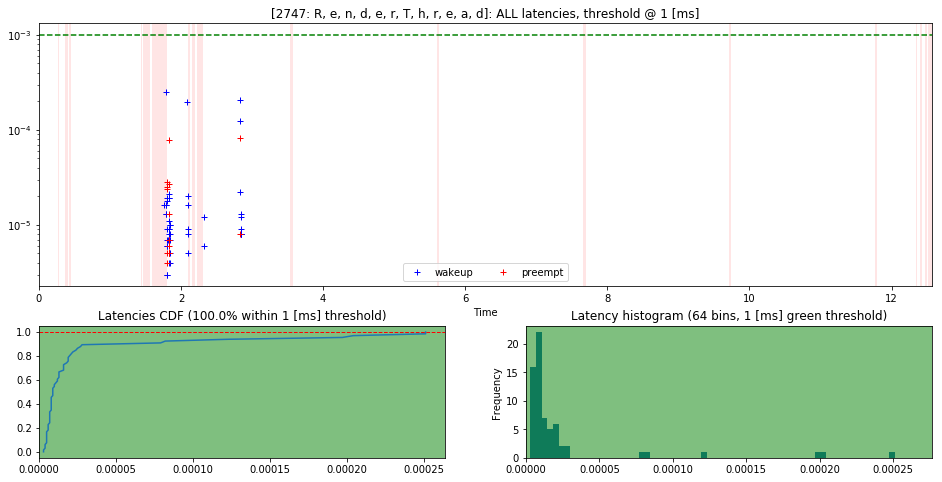

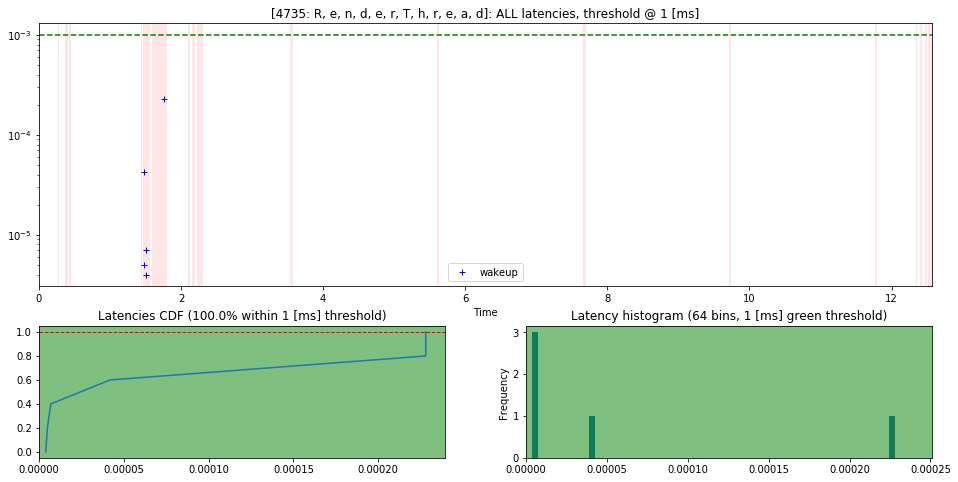

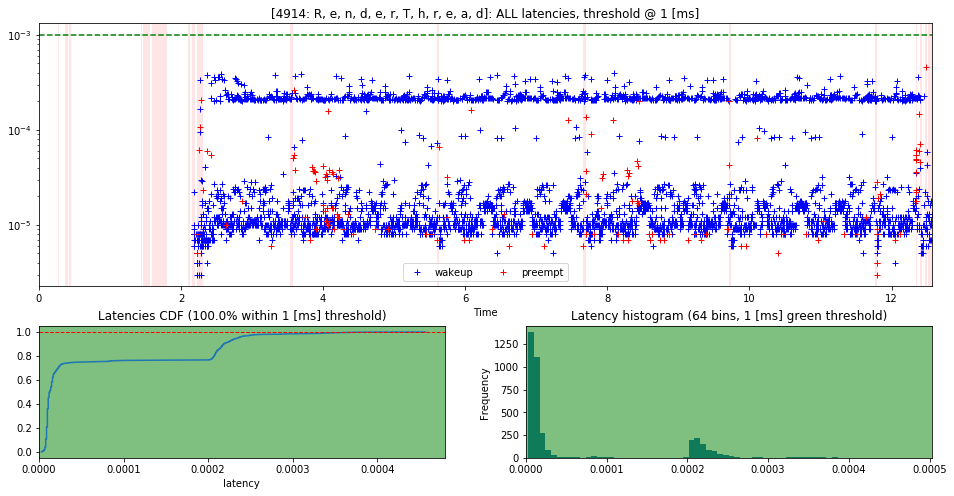

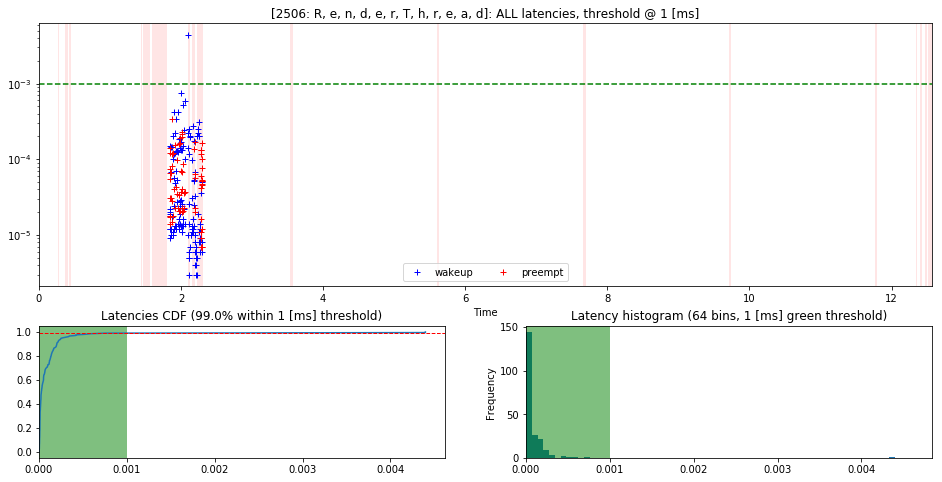

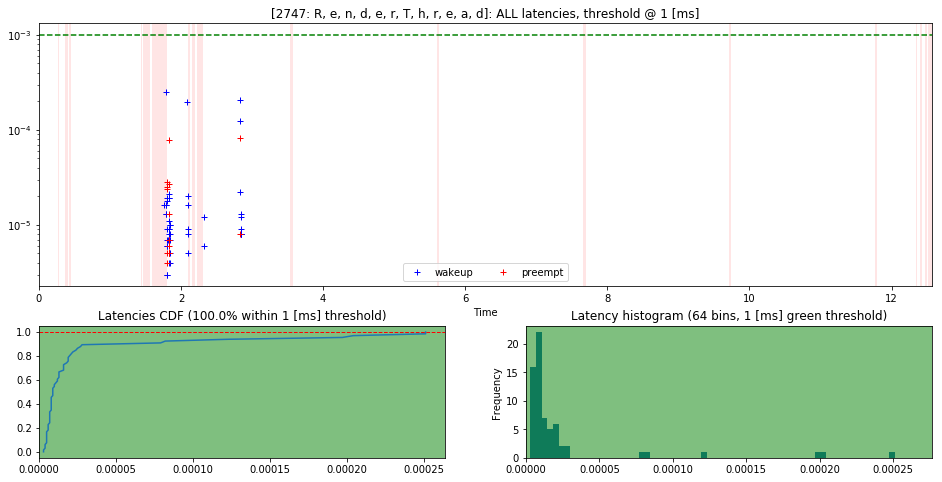

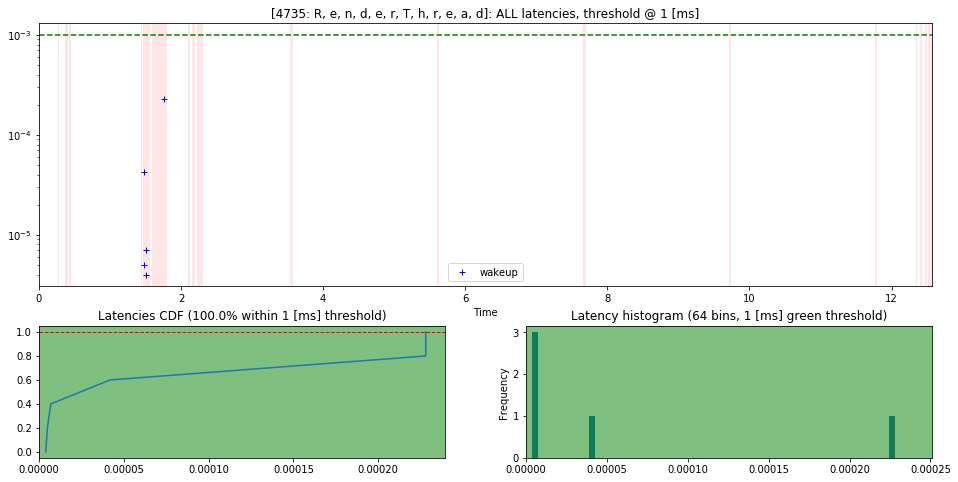

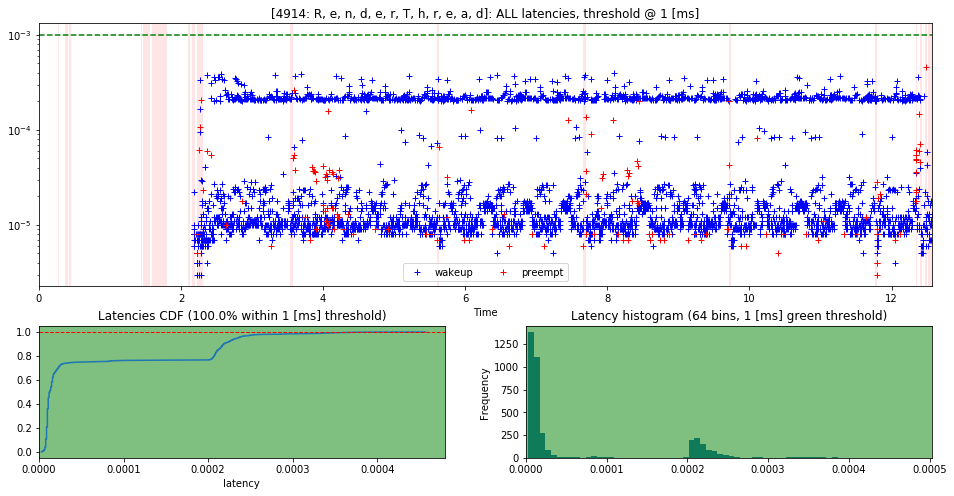

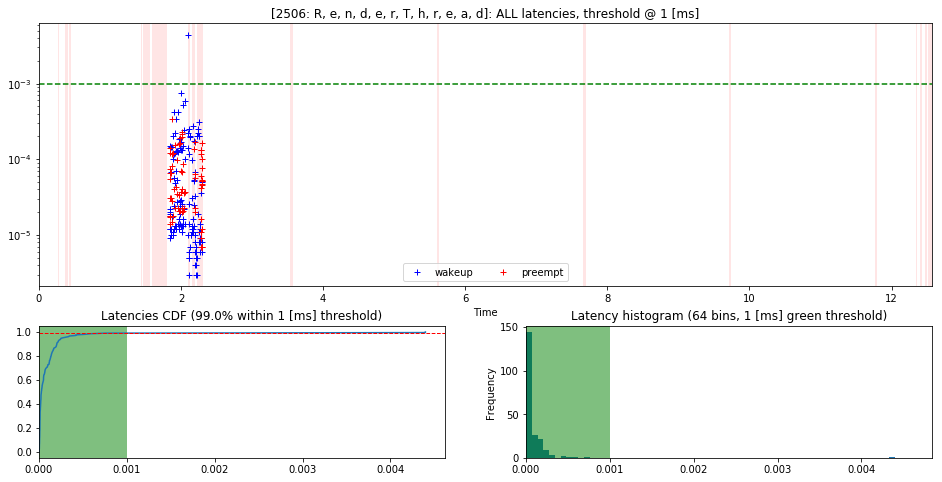

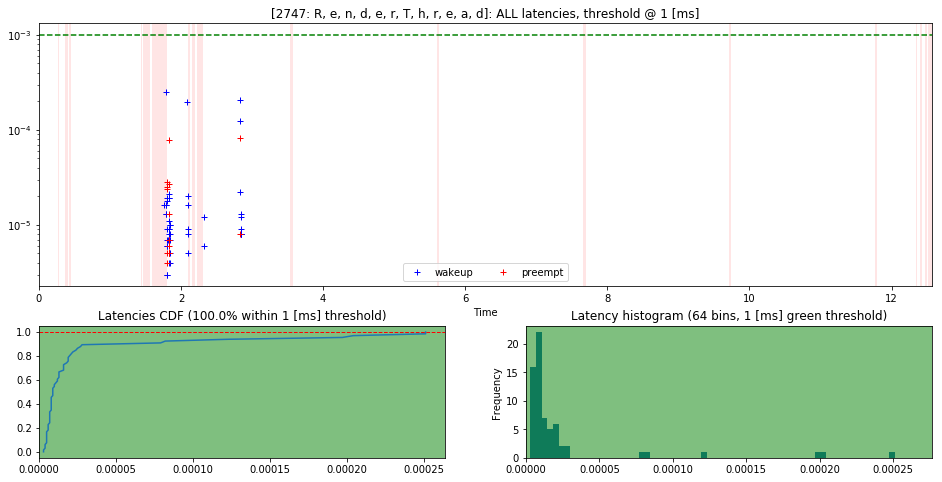

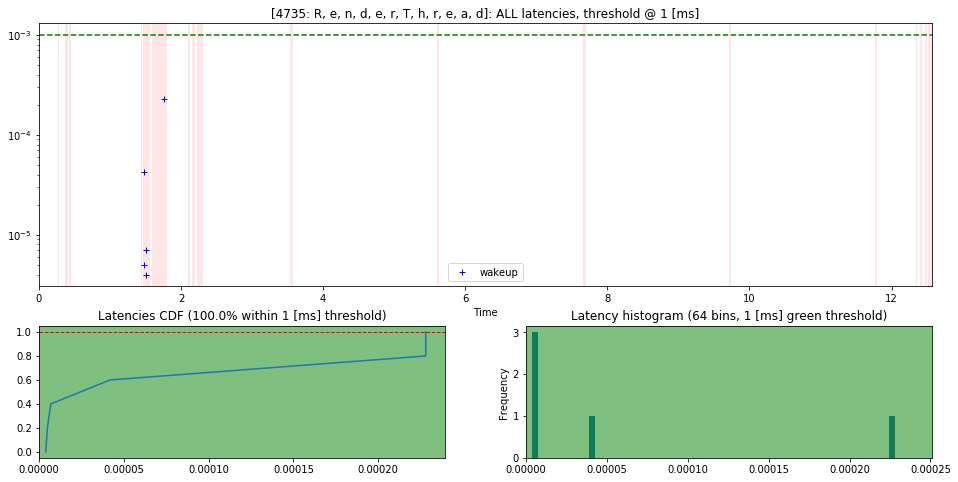

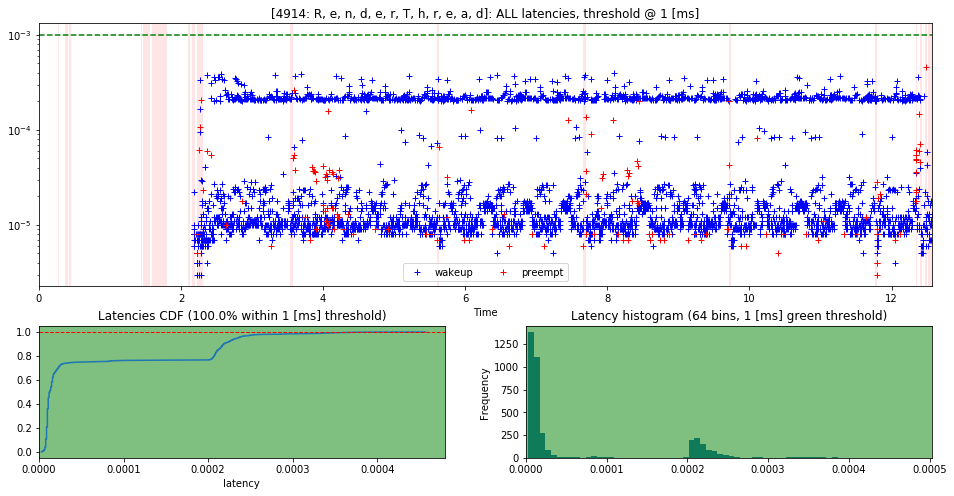

In [19]:
plot_task_scheduling_latency("RenderThread")

2017-11-08 14:33:16,915 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:17,303 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:33:17,364 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:33:17,367 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:33:17,372 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:33:18,936 INFO    : Analysis     : Found:    36 WAKEUP latencies
2017-11-08 14:33:19,000 INFO    : Analysis     : Found:     7 PREEMPT latencies
2017-11-08 14:33:19,003 INFO    : Analysis     : Total:    43 latency events
2017-11-08 14:33:19,007 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:33:20,431 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:20,434 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:20,442 INFO    : Analysis     : Parsing s

2017-11-08 14:33:49,769 INFO    : Analysis     : Total:    36 latency events
2017-11-08 14:33:49,772 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:33:51,727 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:33:51,937 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:33:51,940 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:33:51,943 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:33:53,378 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:53,382 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:53,384 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:33:54,101 INFO    : Analysis     : Found:    26 WAKEUP latencies
2017-11-08 14:33:54,363 INFO    : Analysis     : Found:    11 PREEMPT latencies
2017-11-08 14:33:54,366 INFO    : Analysis     : Total:   

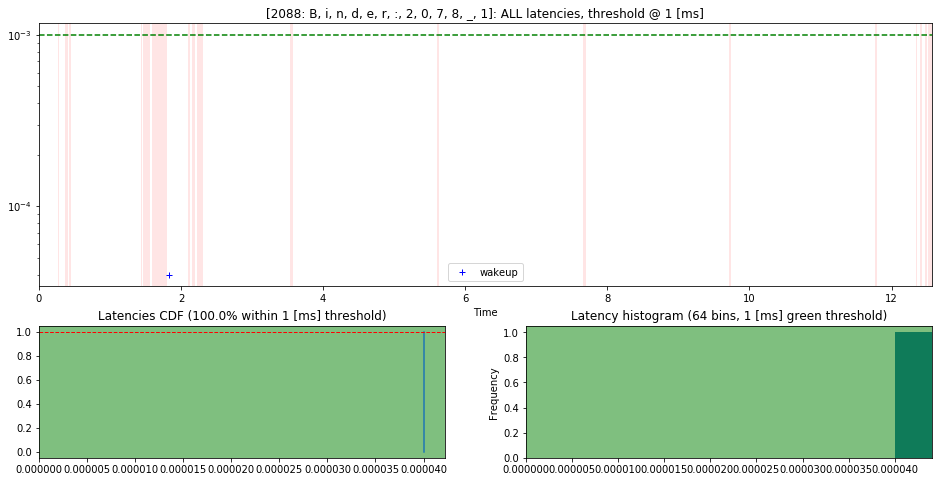

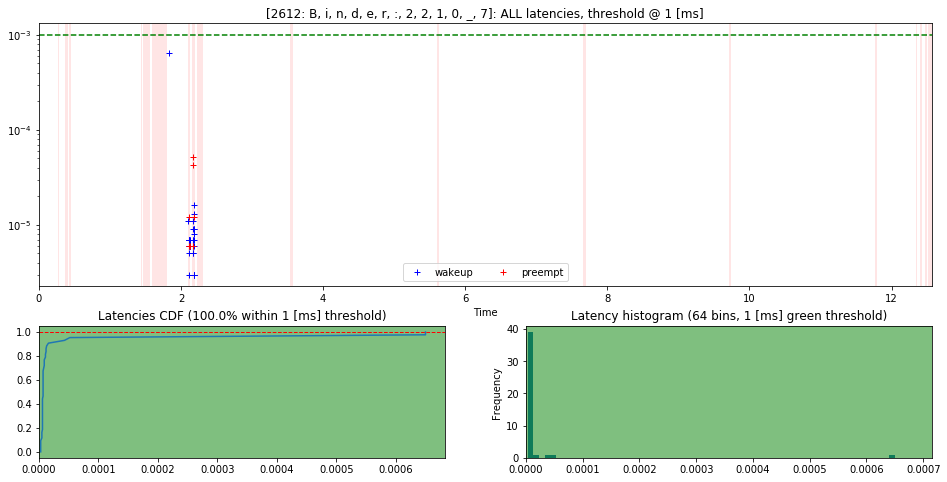

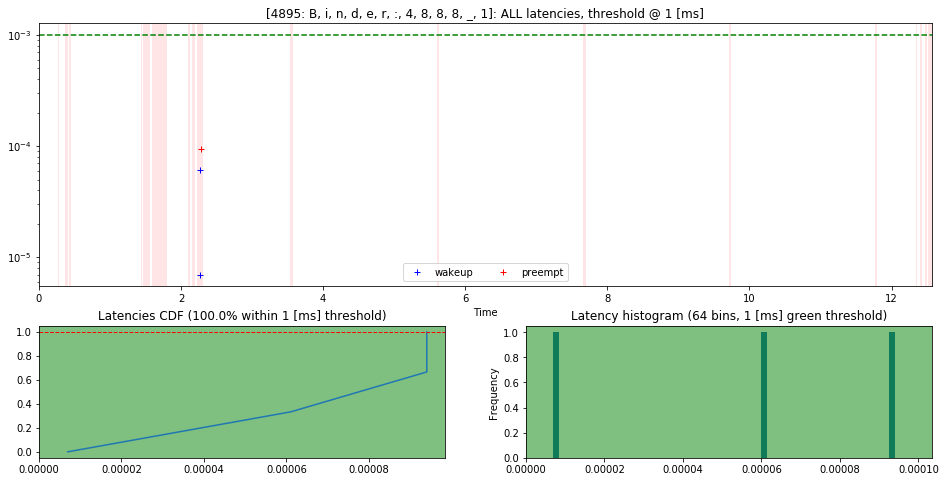

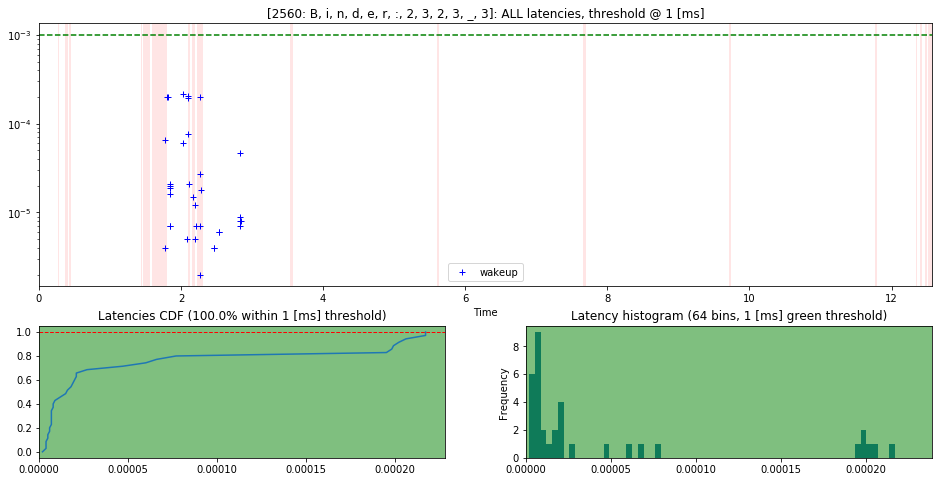

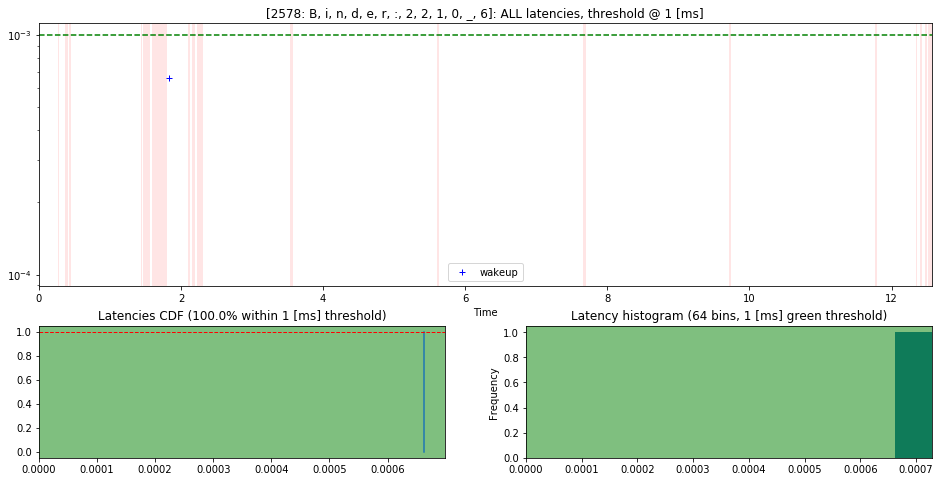

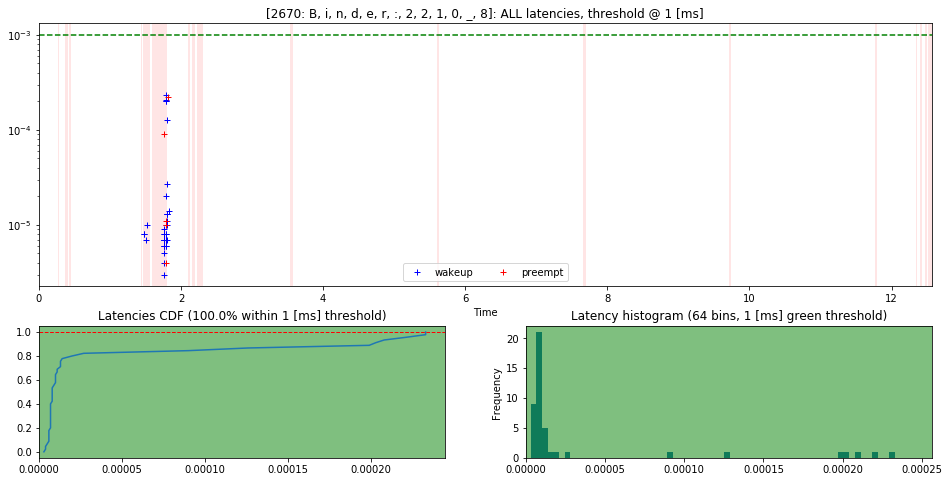

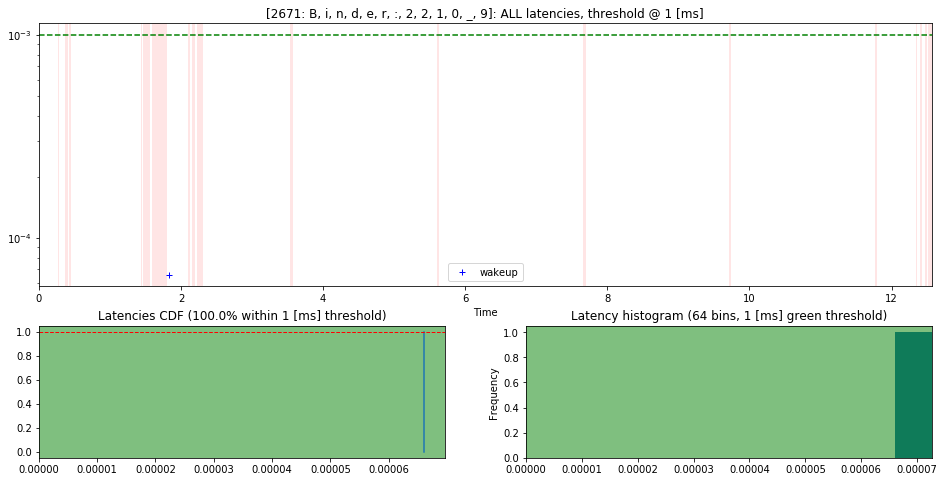

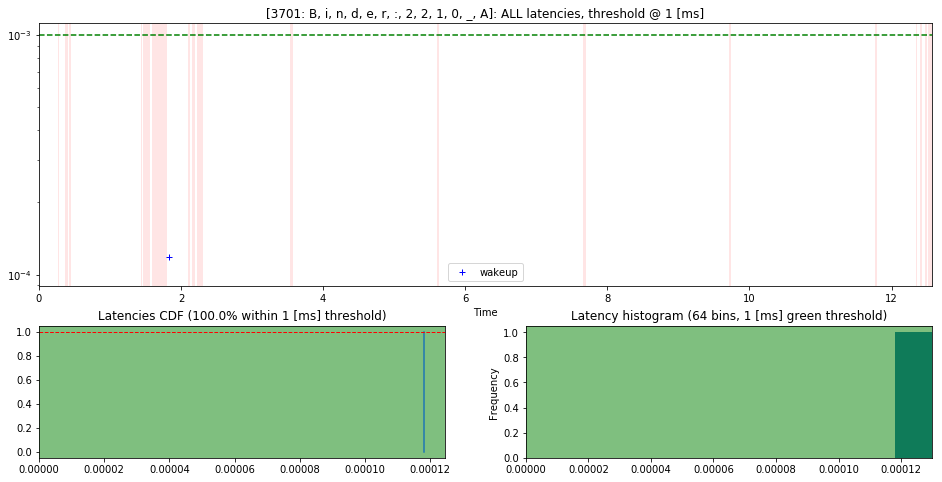

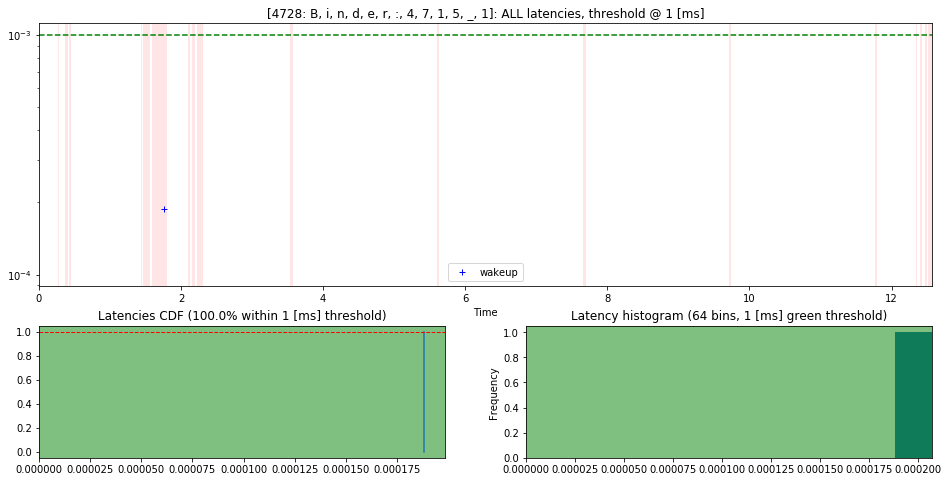

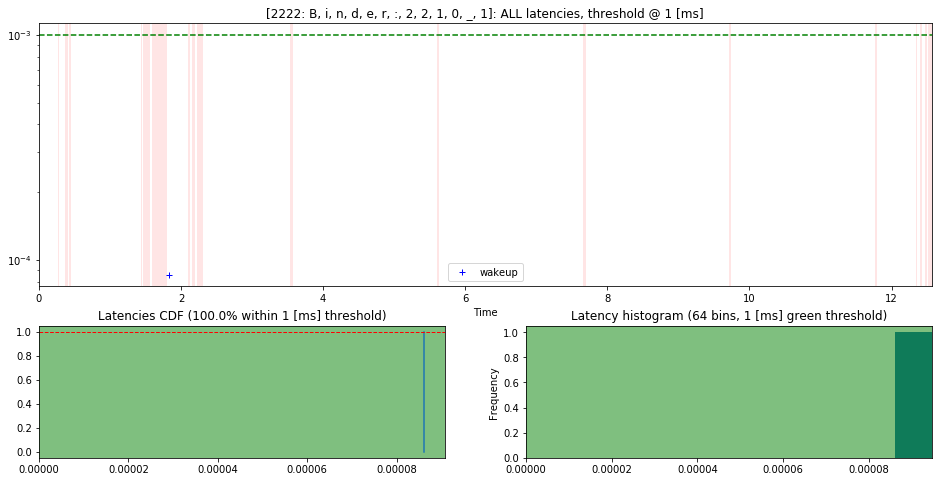

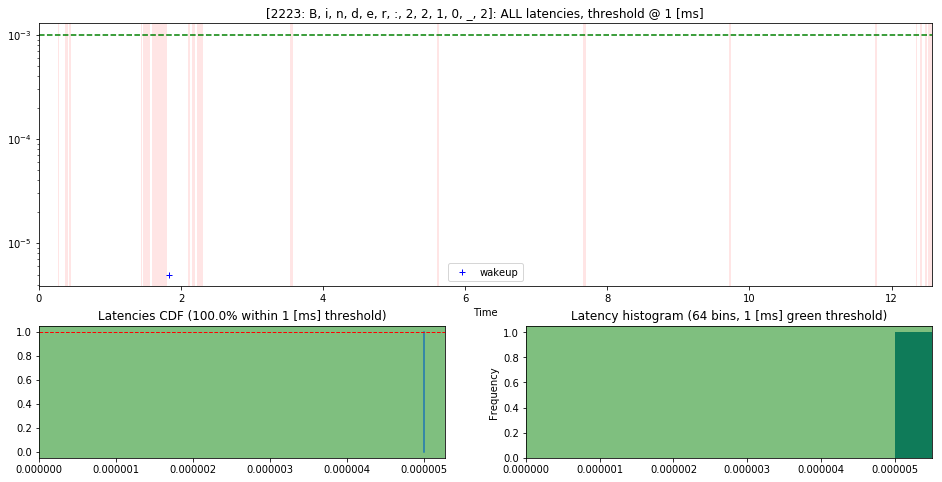

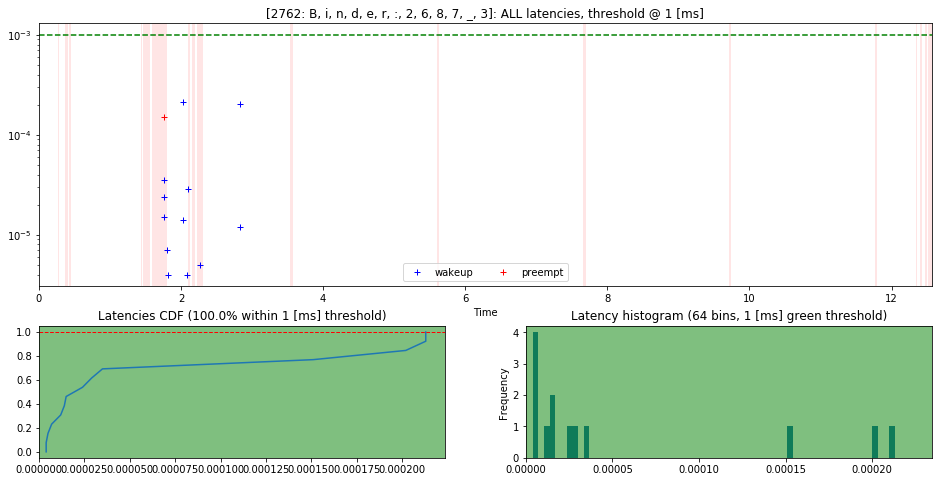

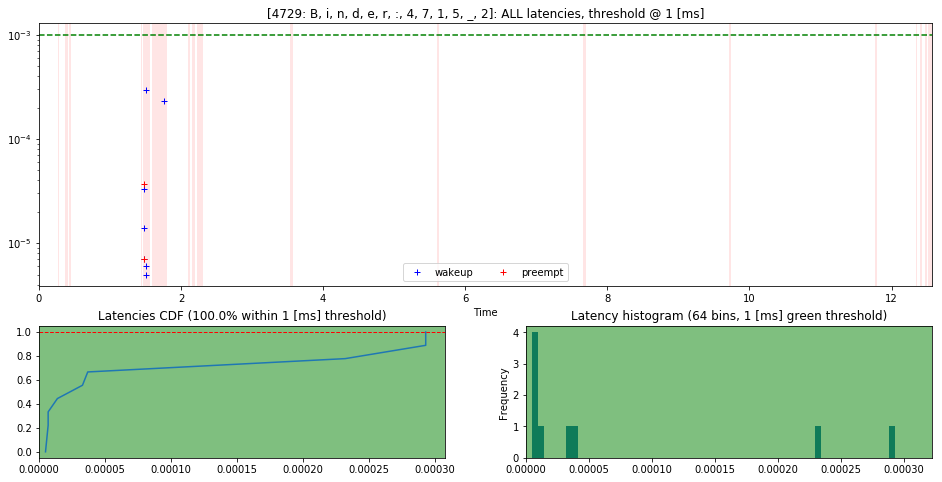

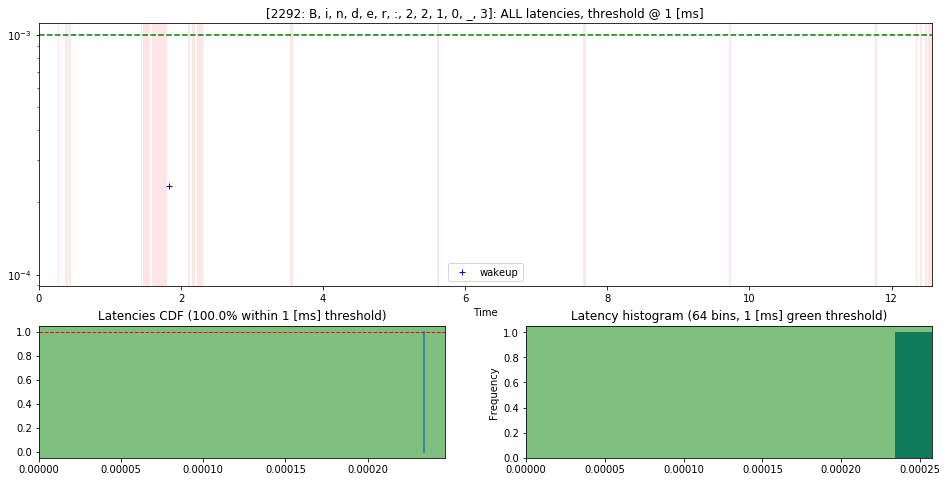

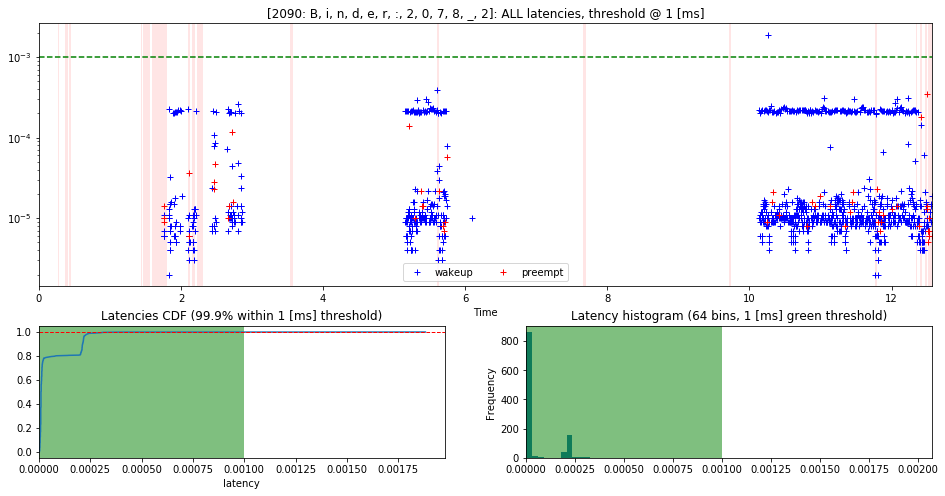

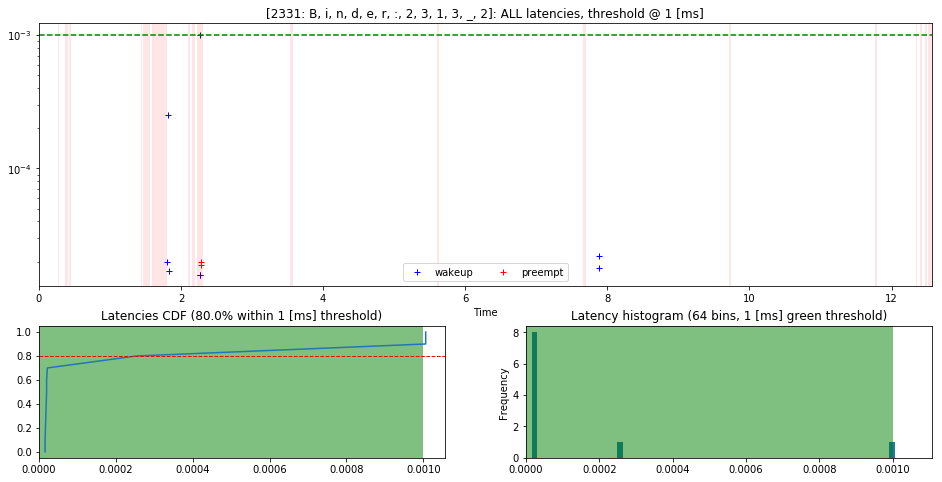

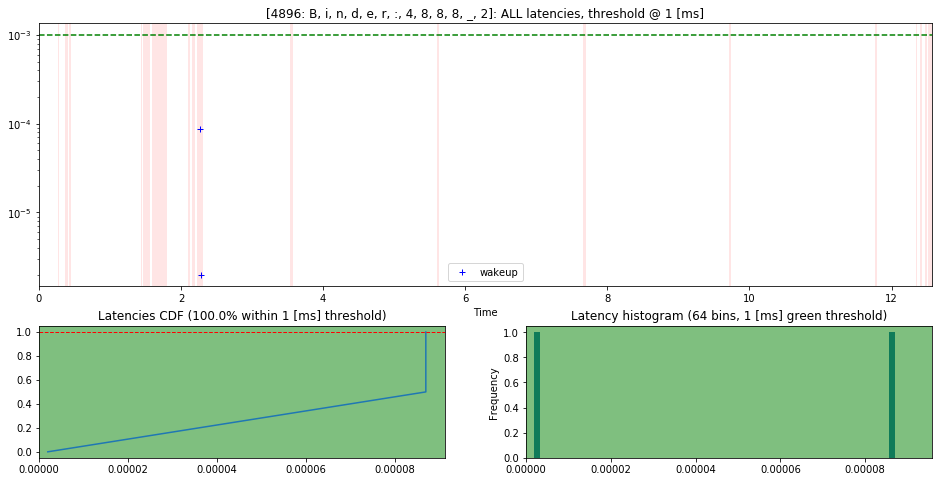

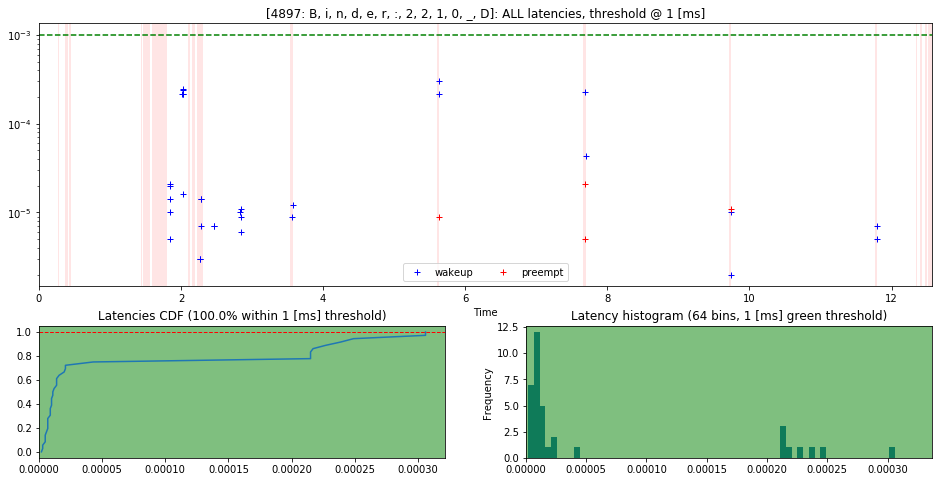

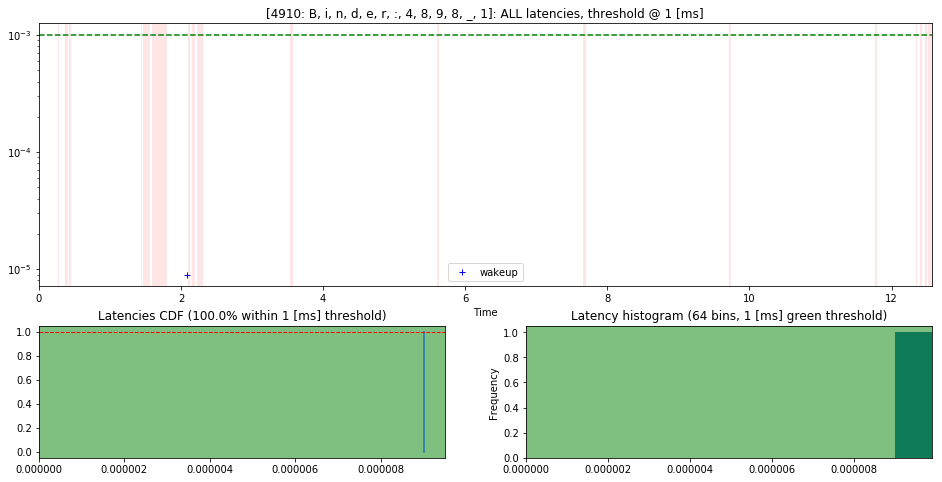

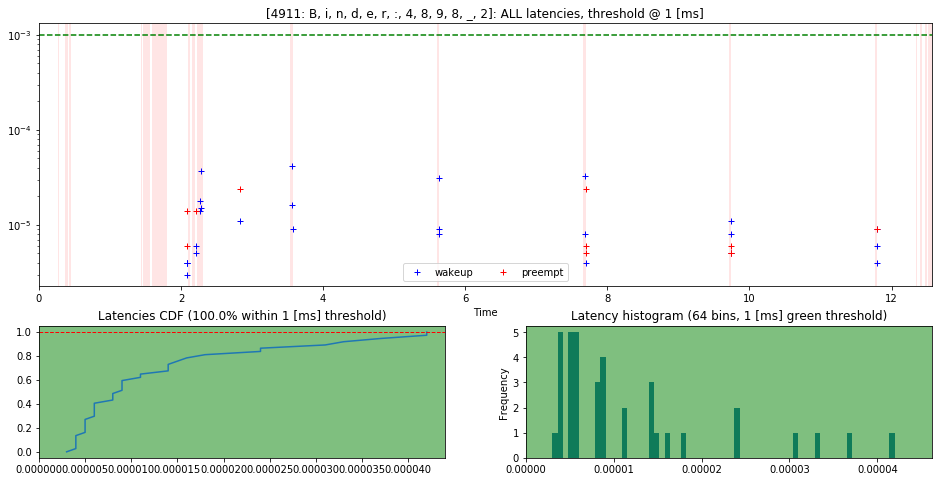

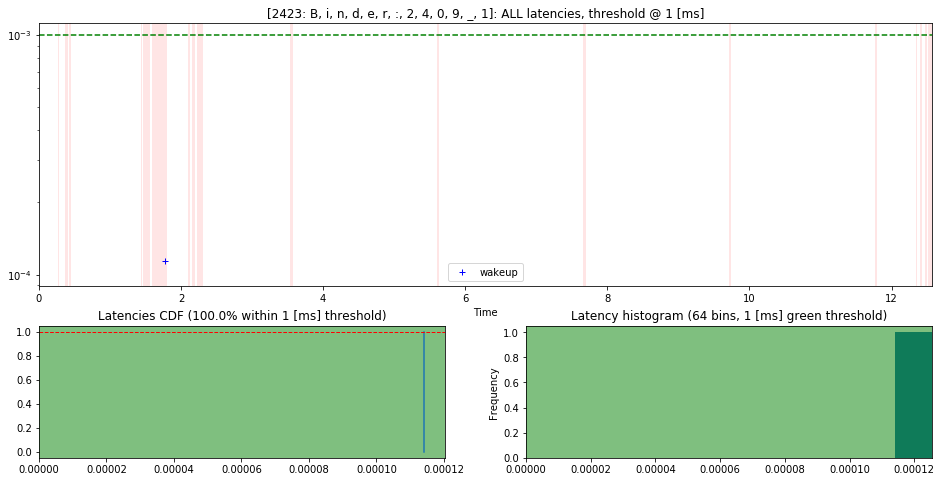

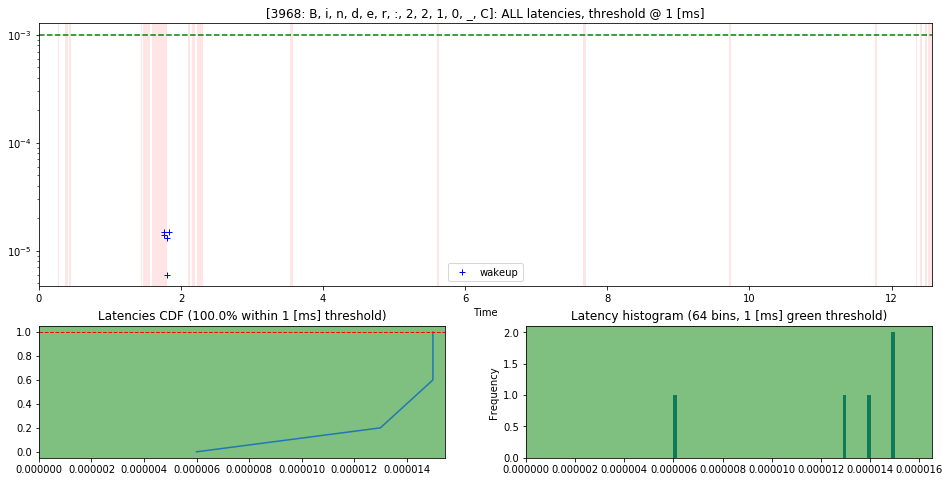

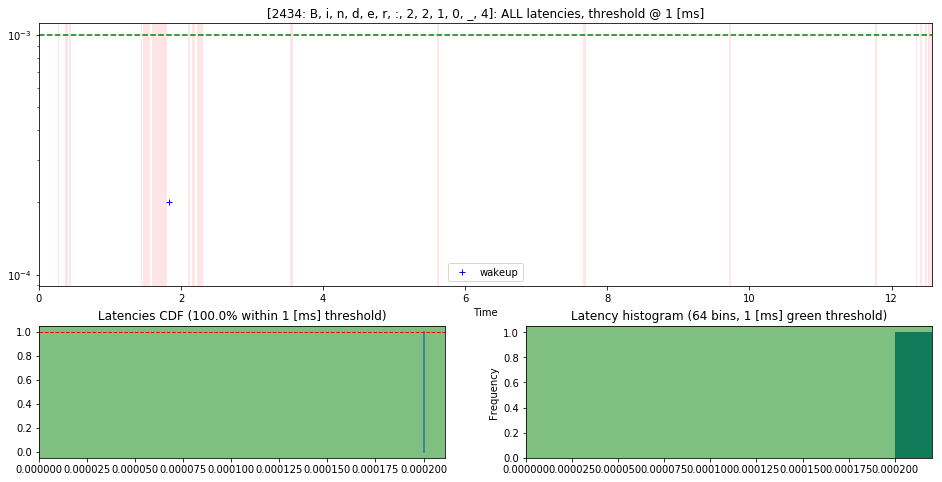

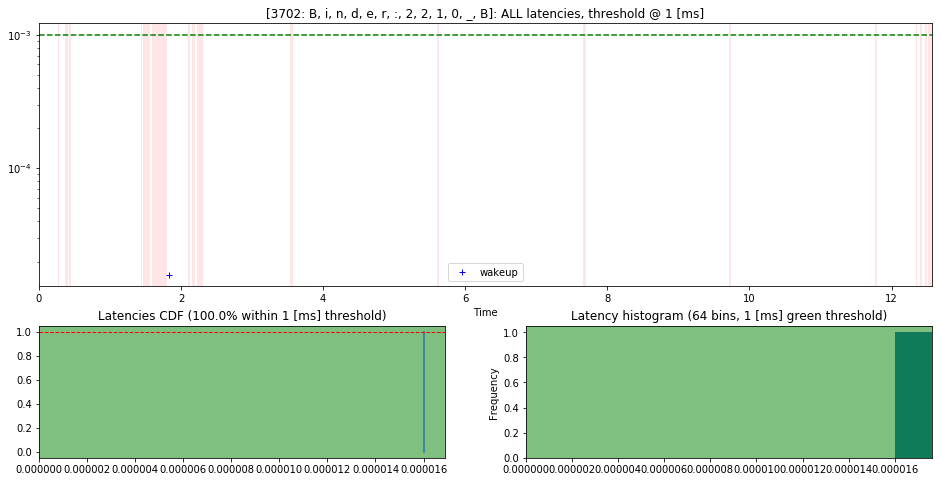

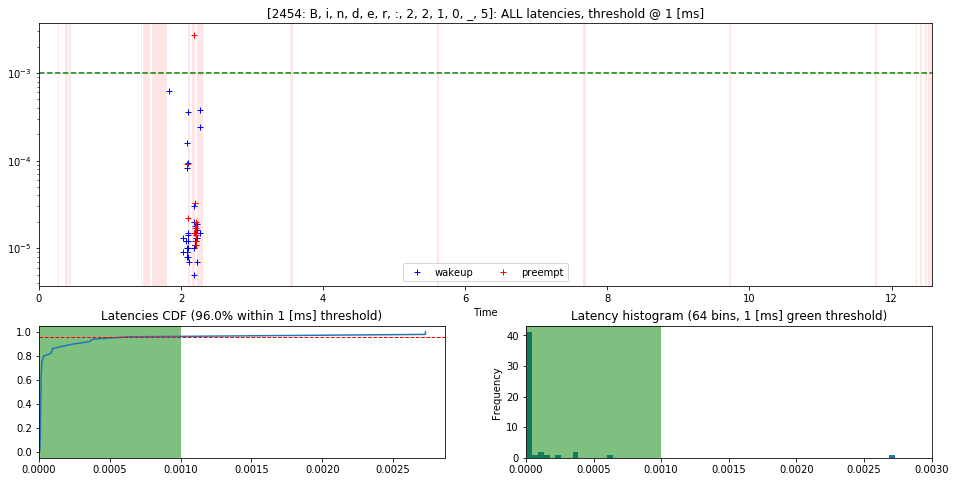

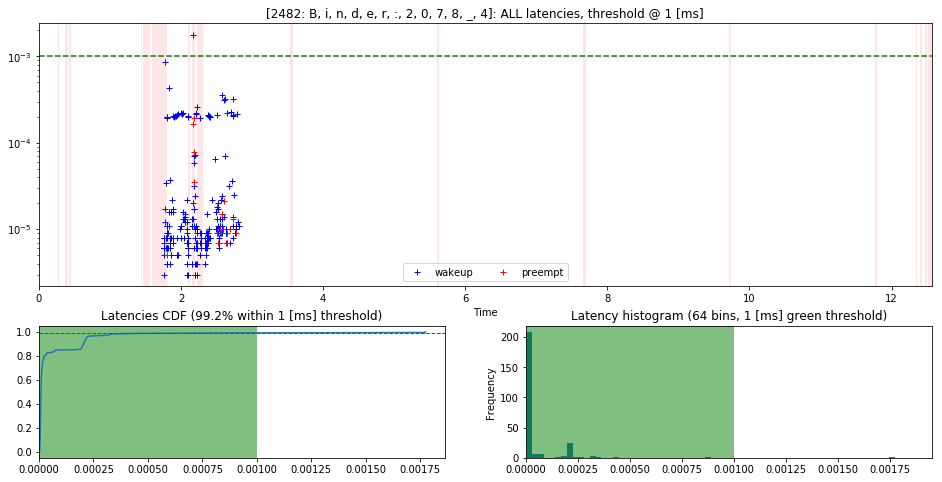

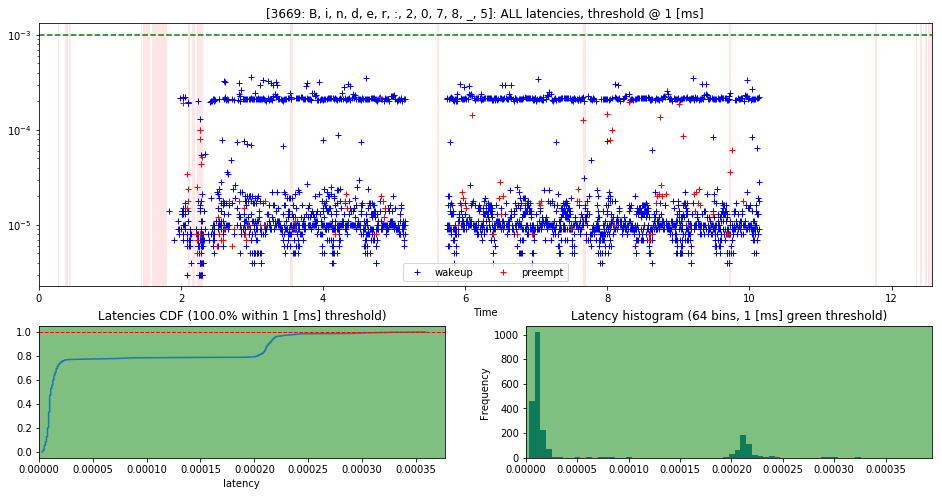

In [20]:
plot_task_scheduling_latency("Binder")

2017-11-08 14:34:26,615 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:27,093 INFO    : Analysis     : Found:     1 WAKEUP latencies
2017-11-08 14:34:27,141 INFO    : Analysis     : Found:     0 PREEMPT latencies
2017-11-08 14:34:27,143 INFO    : Analysis     : Total:     1 latency events
2017-11-08 14:34:27,149 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-11-08 14:34:28,546 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:28,548 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:28,555 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:28,784 INFO    : Analysis     : Found:   601 WAKEUP latencies
2017-11-08 14:34:28,859 INFO    : Analysis     : Found:     2 PREEMPT latencies
2017-11-08 14:34:28,861 INFO    : Analysis     : Total:   603 latency events
2017-11-08 14:34:28,866 INFO    : Analysis     :

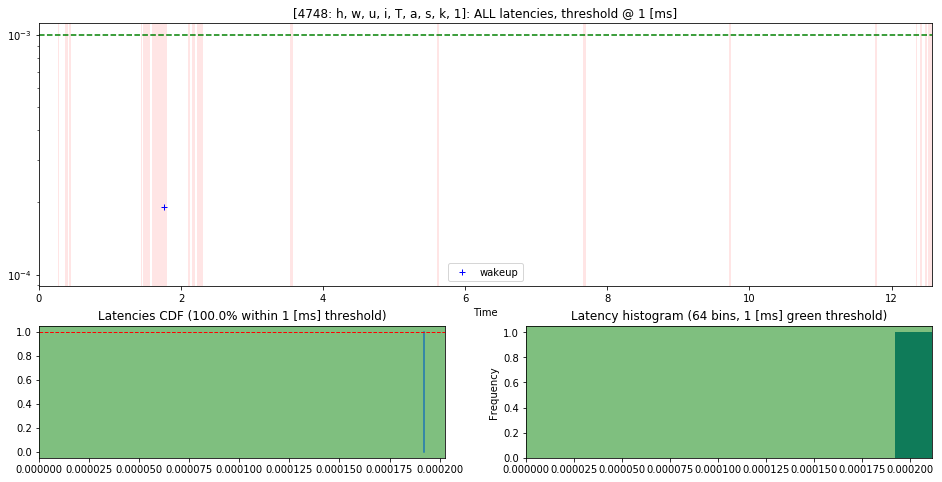

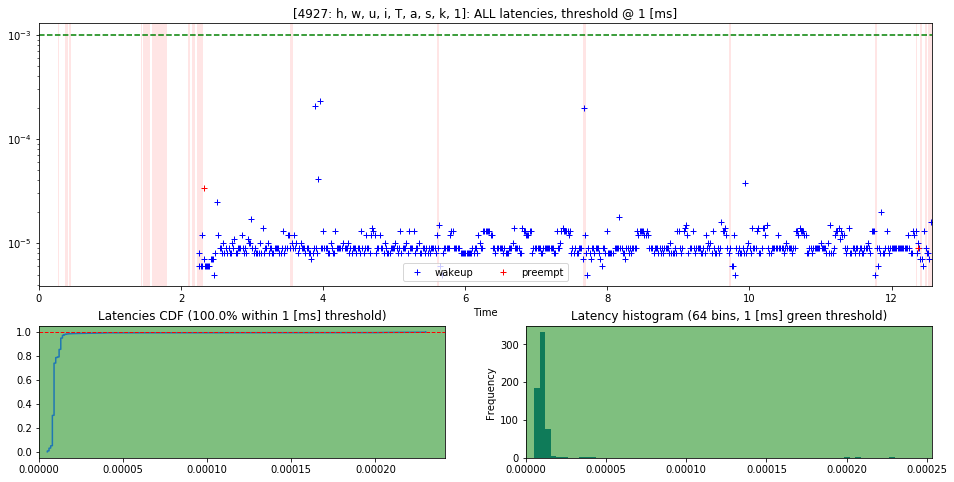

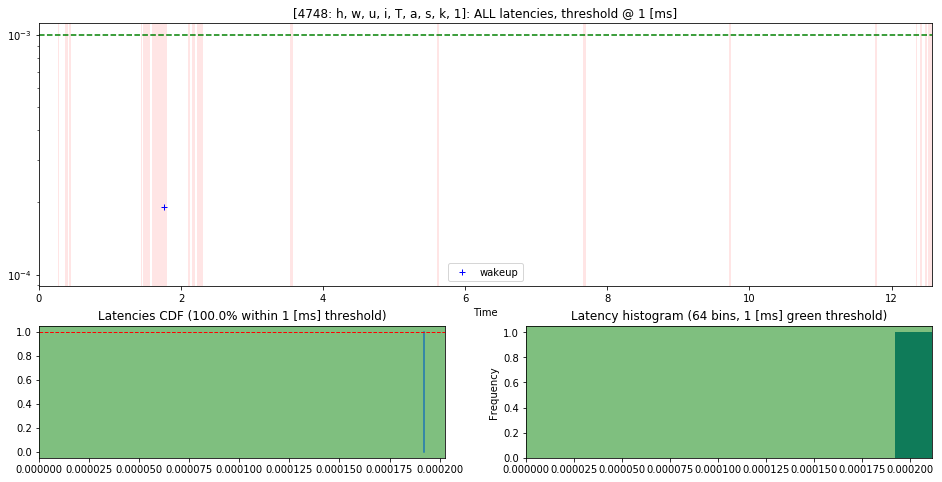

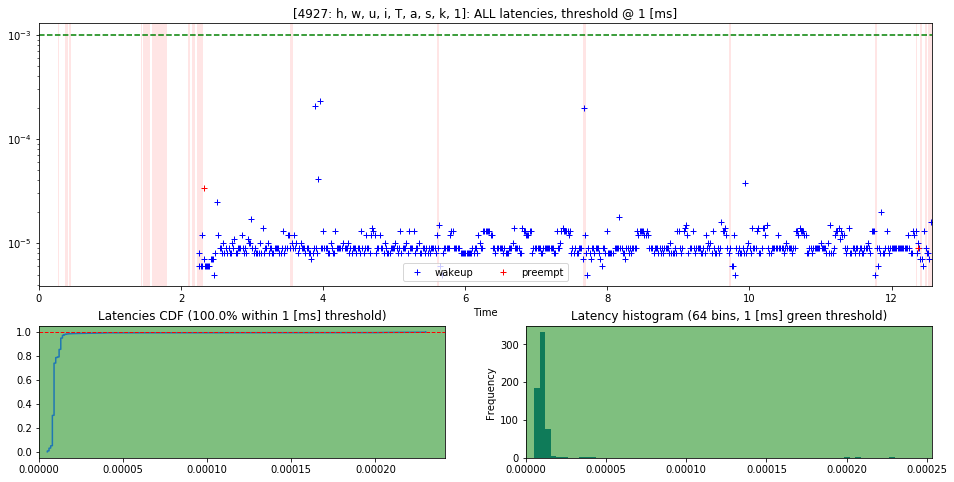

In [21]:
plot_task_scheduling_latency("hwuiTask1")

# Task Runtime Analysis

In [22]:
def plot_task_runtime(task_name):
    for name in trace.getTasks().values():
        if task_name in name:
            for pid in trace.getTaskByName(name):    
                trace.analysis.latency.plotRuntimes(pid)

2017-11-08 14:34:36,095 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:36,286 INFO    : Analysis     : Found:     1 activations for [4748: h, w, u, i, T, a, s, k, 1]
2017-11-08 14:34:36,290 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:34:37,339 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:37,340 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:37,342 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:37,603 INFO    : Analysis     : Found:   600 activations for [4927: h, w, u, i, T, a, s, k, 1]
2017-11-08 14:34:37,607 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:34:38,727 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:38,863 INFO    : Analysis     : Found:     1 activations for [4748: h, w, u, i, T, a, s, k, 1

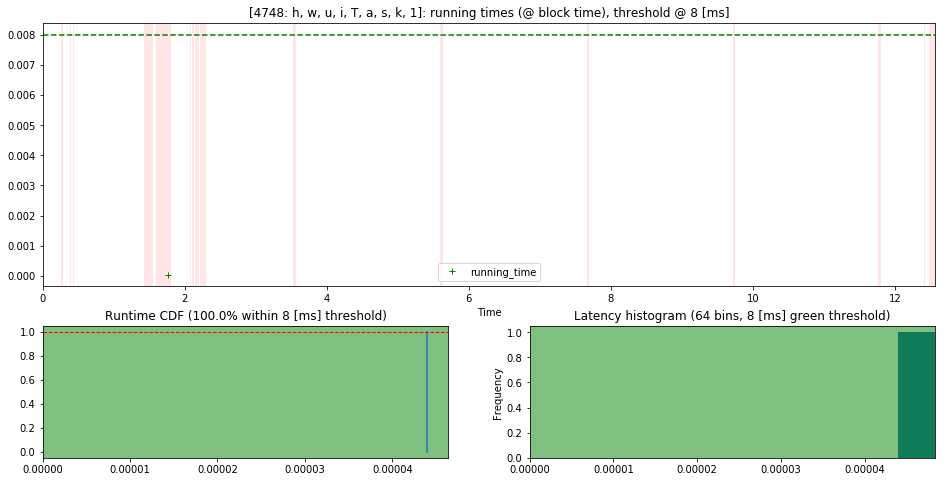

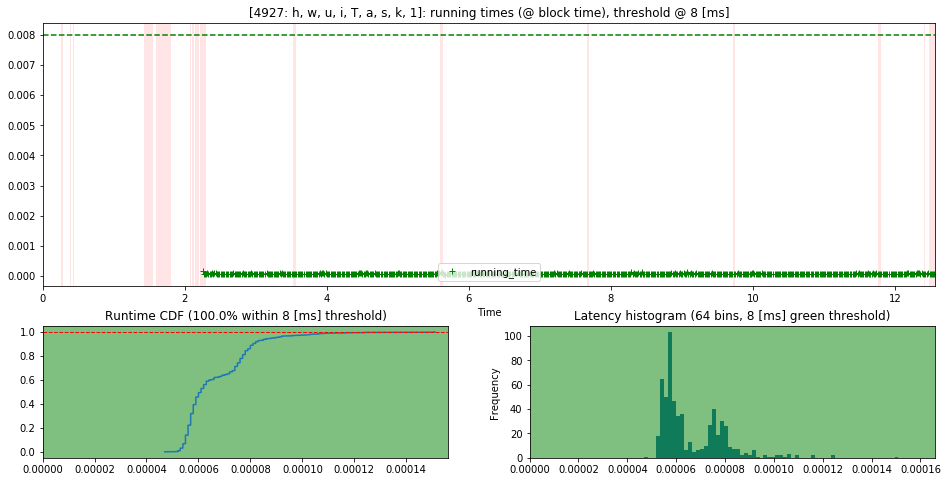

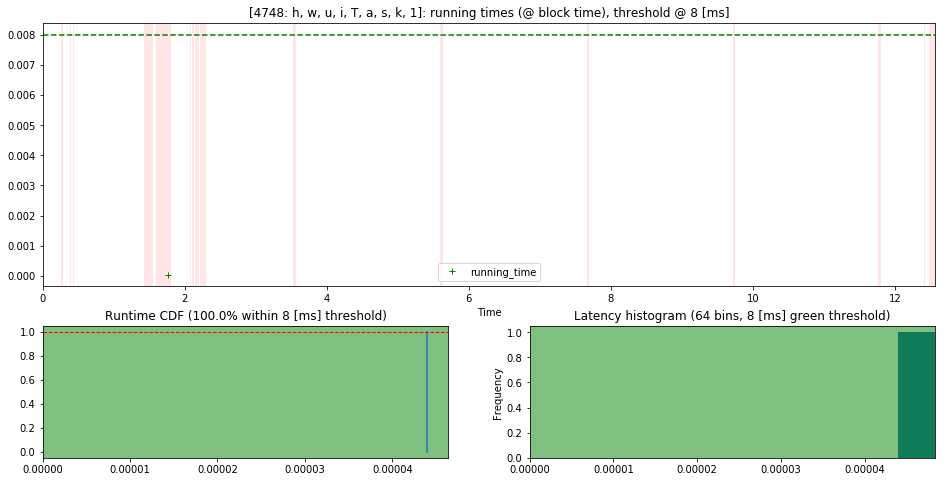

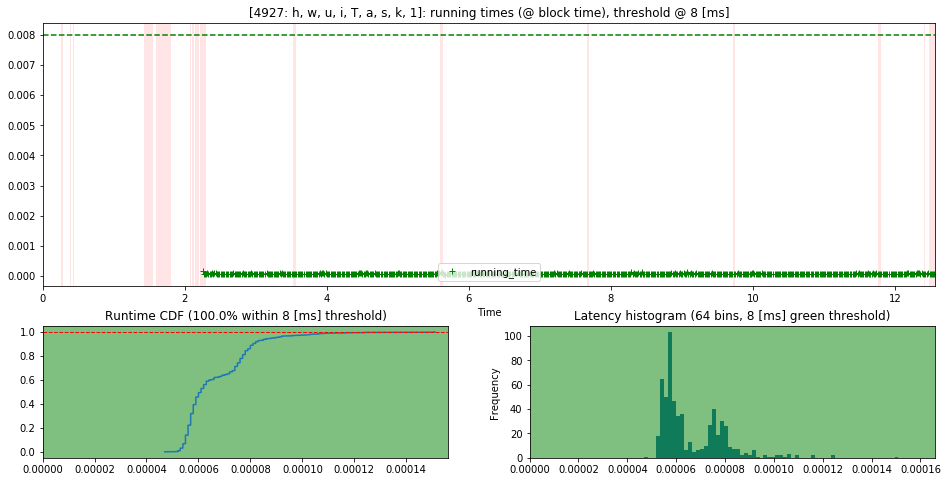

In [23]:
plot_task_runtime("hwuiTask1")

2017-11-08 14:34:43,375 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:43,377 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:43,385 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:43,387 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:43,927 WARNING : Analysis     : Unexpected next state: nan @ 12.564536
2017-11-08 14:34:43,932 INFO    : Analysis     : Found:  2519 activations for [2078: s, u, r, f, a, c, e, f, l, i, n, g, e, r]
2017-11-08 14:34:43,936 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:34:45,090 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:45,092 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:45,215 INFO    : Analysis     : Found:     8 activations for [2166: s, u, r, f, a, c, e, f, 

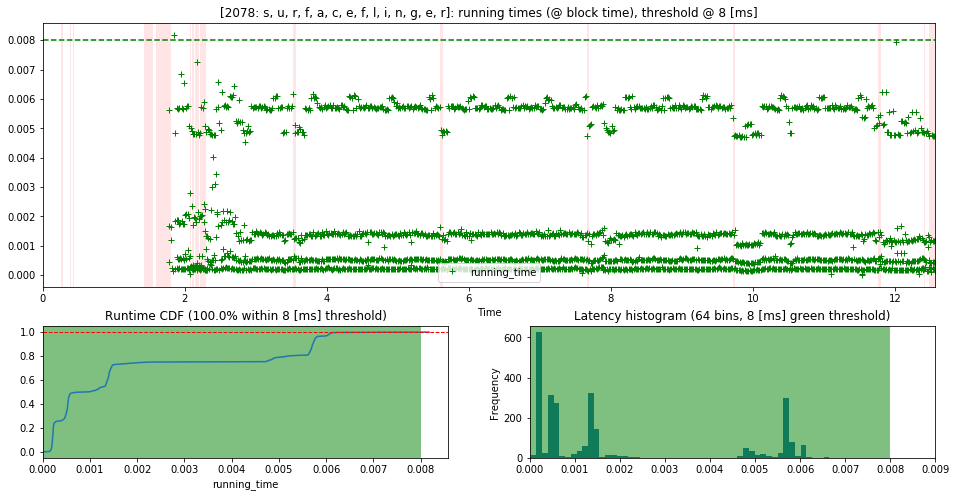

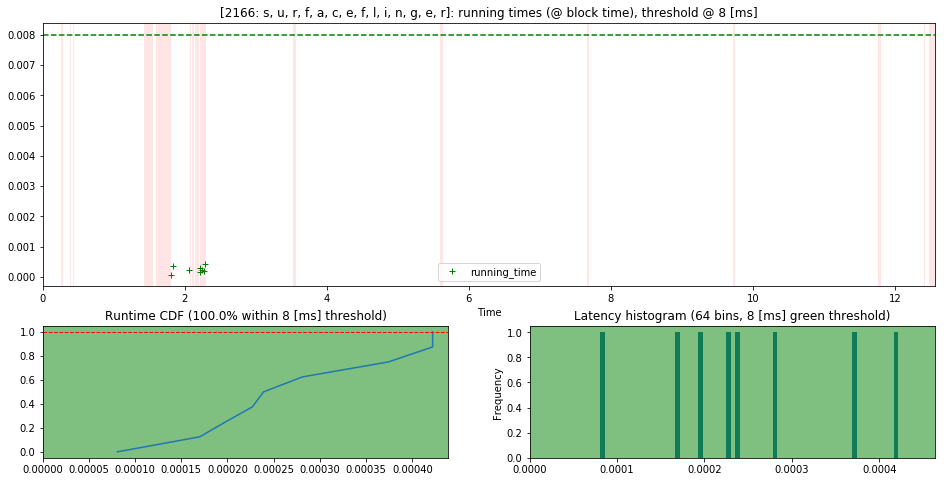

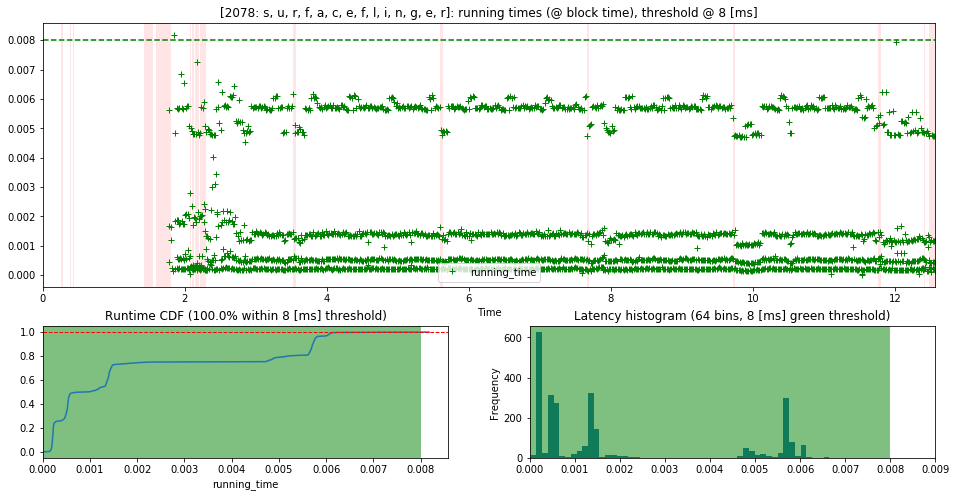

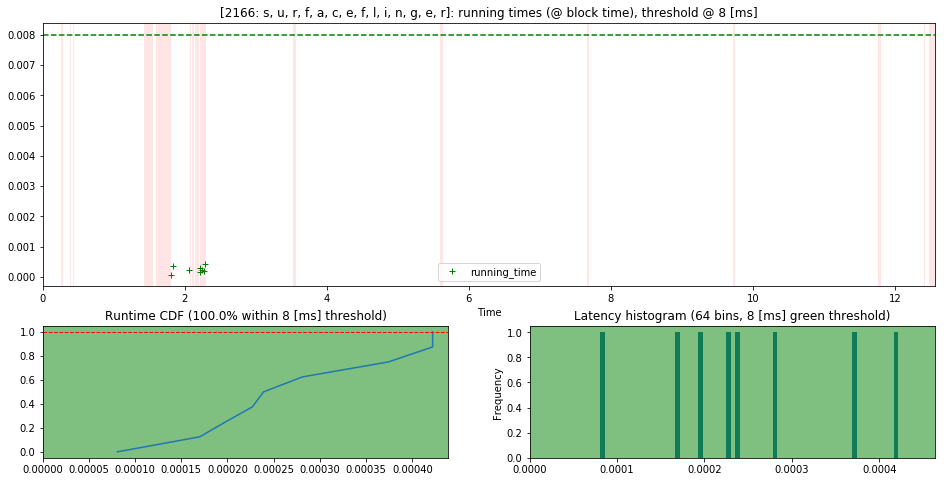

In [24]:
plot_task_runtime("surfaceflinger")

2017-11-08 14:34:51,487 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:51,659 INFO    : Analysis     : Found:     1 activations for [2088: B, i, n, d, e, r, :, 2, 0, 7, 8, _, 1]
2017-11-08 14:34:51,664 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:34:52,940 INFO    : Analysis     : Found:    36 activations for [2612: B, i, n, d, e, r, :, 2, 2, 1, 0, _, 7]
2017-11-08 14:34:52,944 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:34:54,114 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:54,115 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:54,117 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:54,118 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:34:54,299 INFO    : Analysis     : Found:     2 activations for [4895: B

2017-11-08 14:35:19,691 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:35:21,195 INFO    : Analysis     : Found:     1 activations for [2434: B, i, n, d, e, r, :, 2, 2, 1, 0, _, 4]
2017-11-08 14:35:21,199 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:35:22,213 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:35:22,719 INFO    : Analysis     : Found:     1 activations for [3702: B, i, n, d, e, r, :, 2, 2, 1, 0, _, B]
2017-11-08 14:35:22,723 INFO    : Analysis     : 100.0 % samples below 8 [ms] threshold
2017-11-08 14:35:23,678 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:35:23,680 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:35:23,683 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-11-08 14:35:24,155 INFO    : Analysis     : Found:    36 activations for [2454: B, i, n, d,

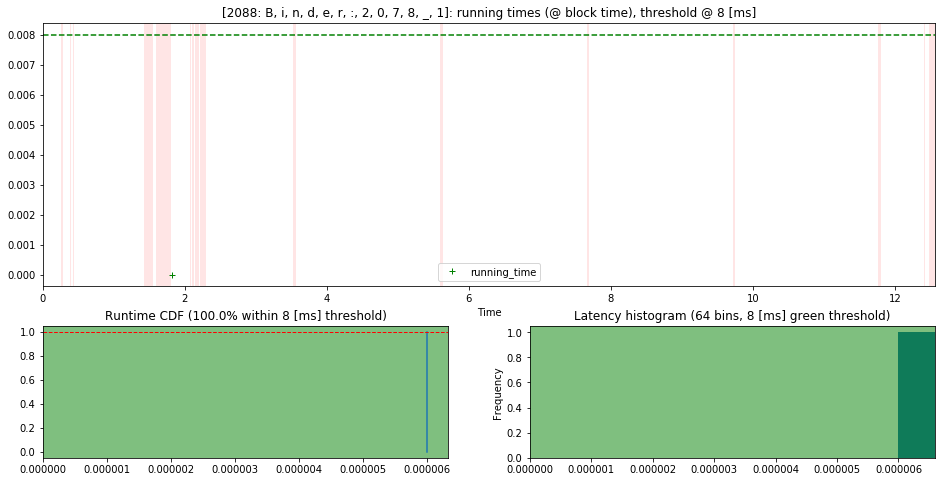

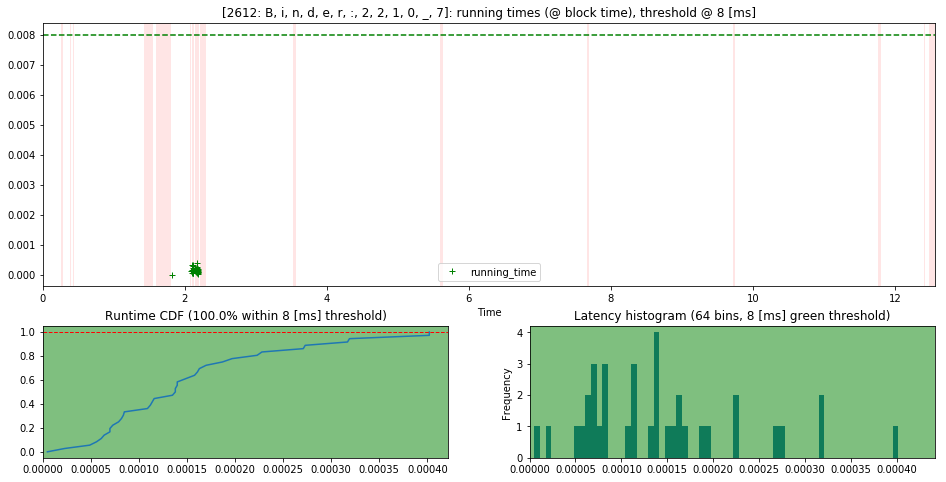

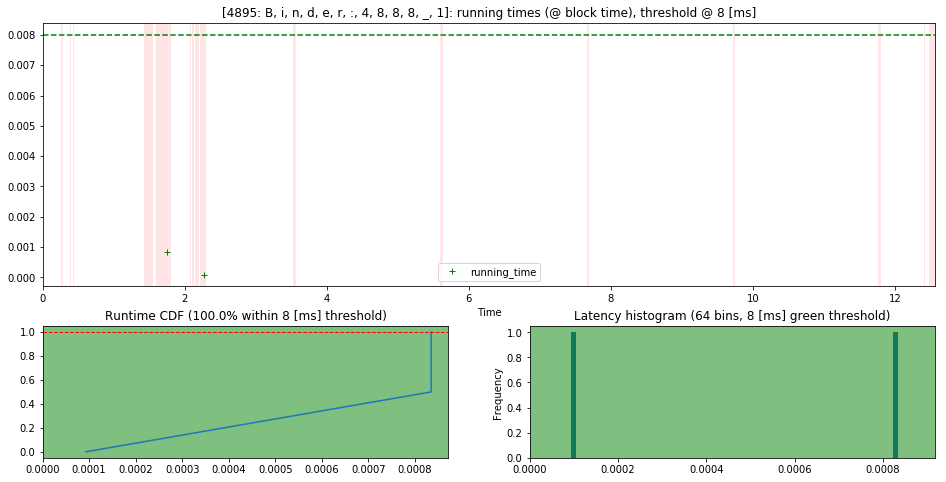

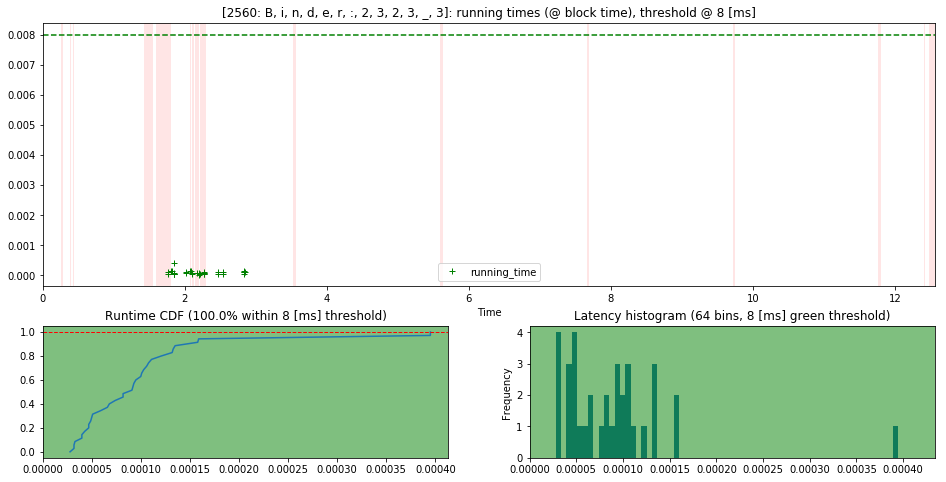

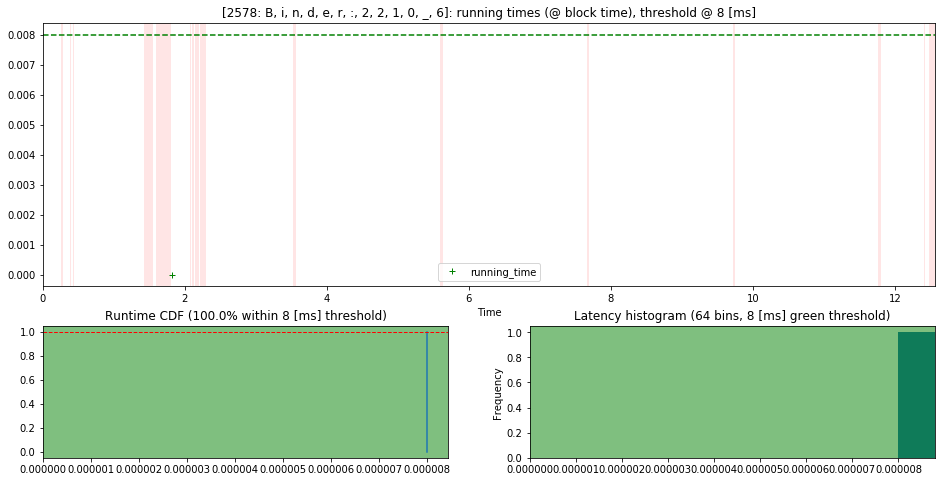

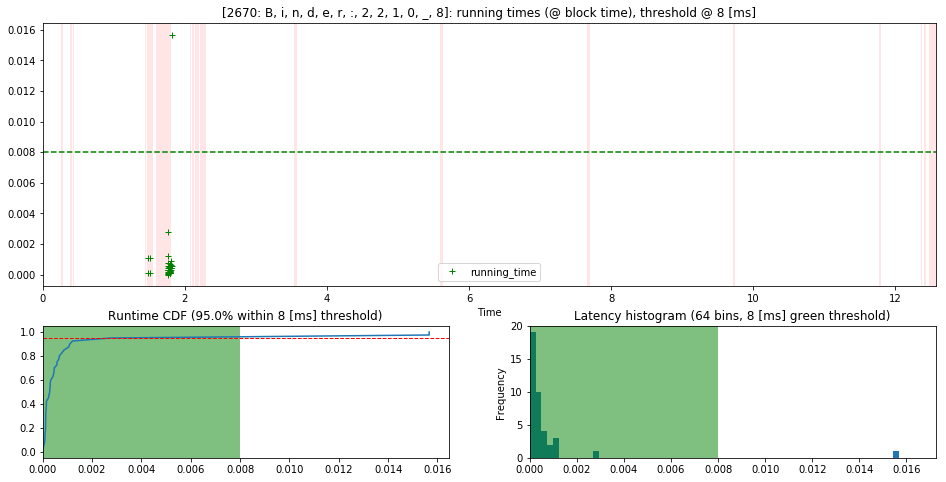

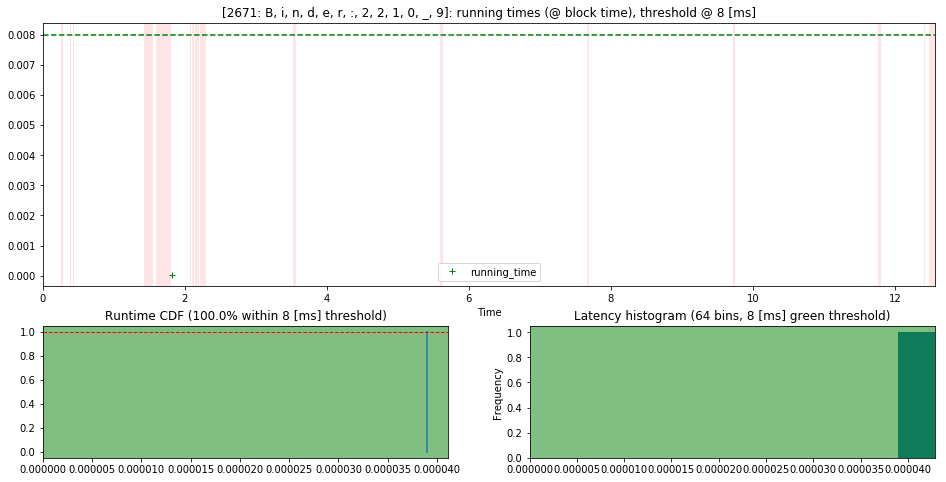

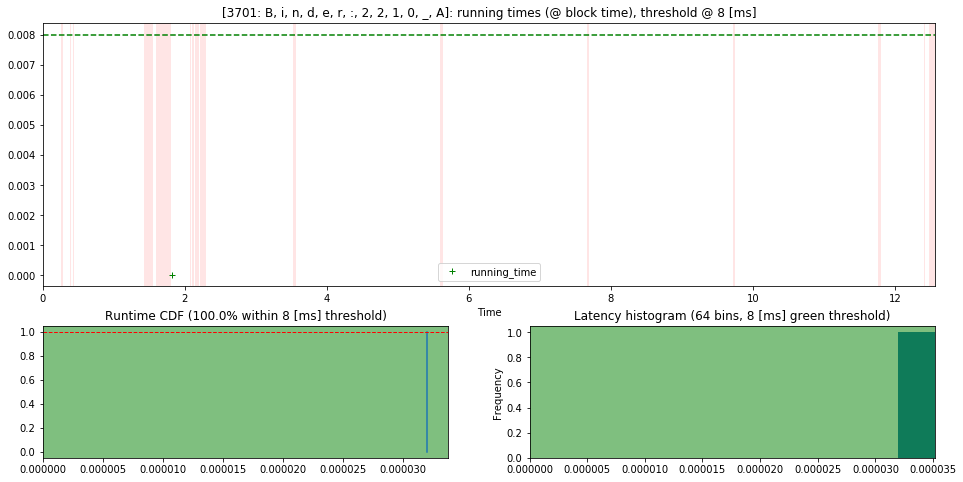

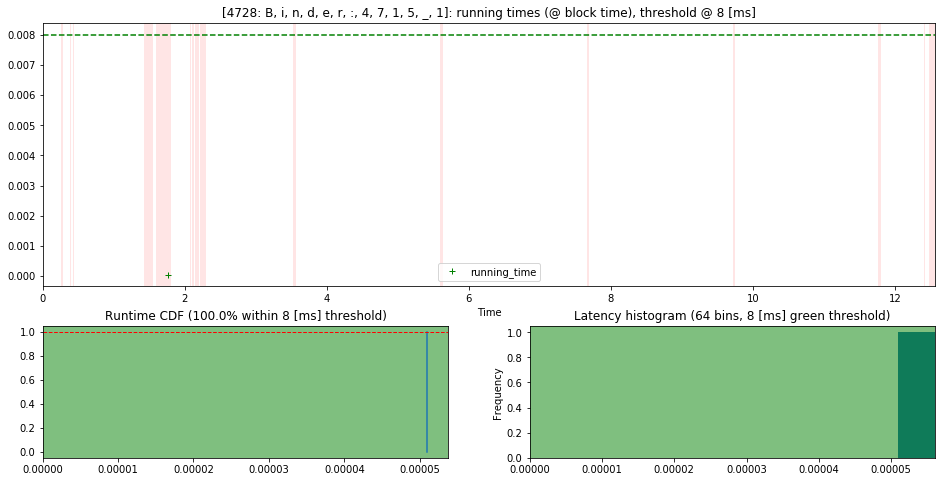

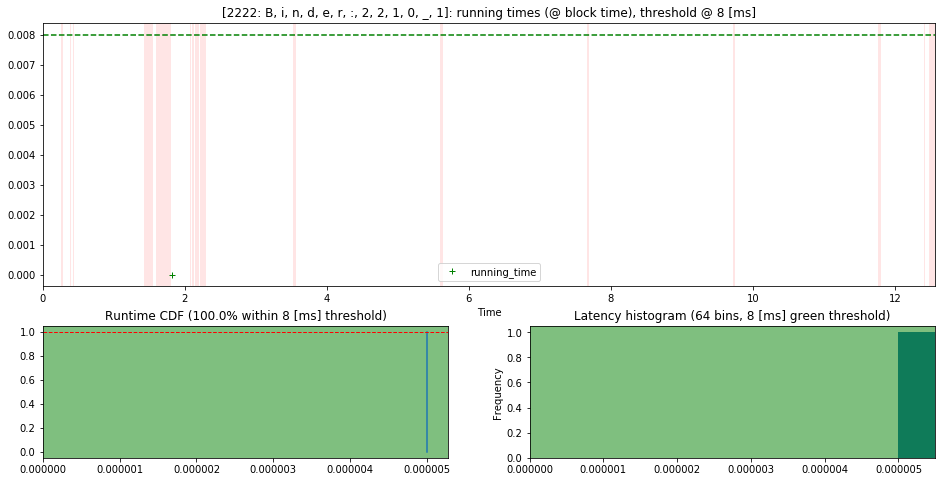

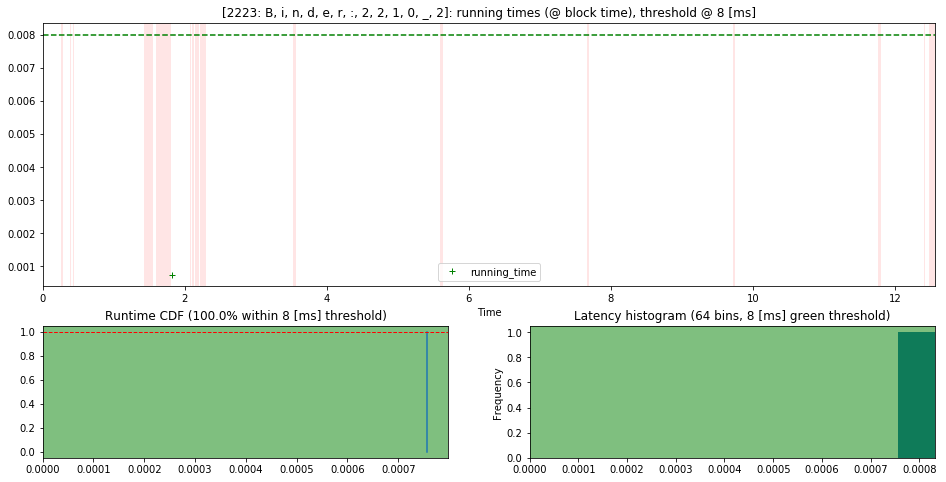

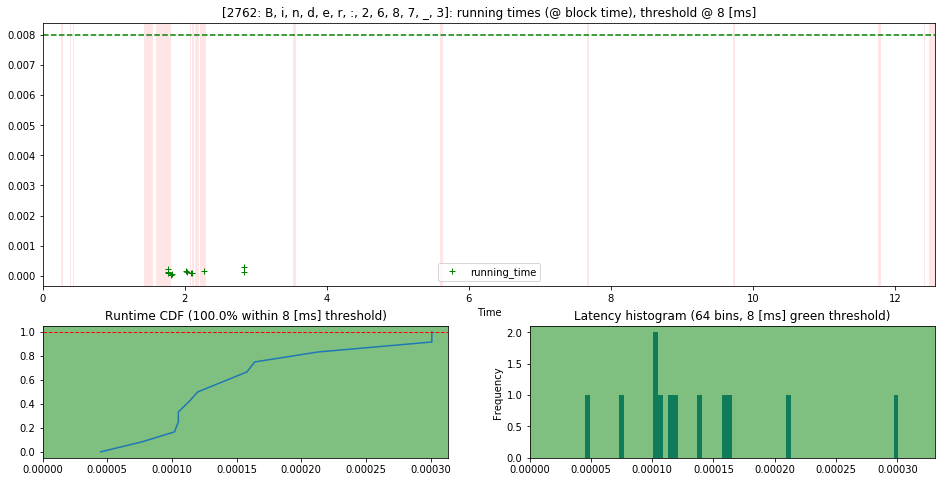

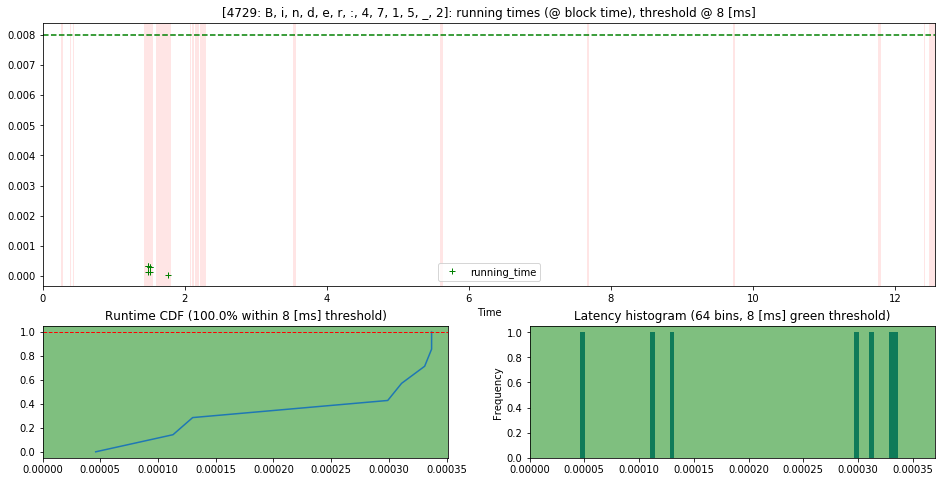

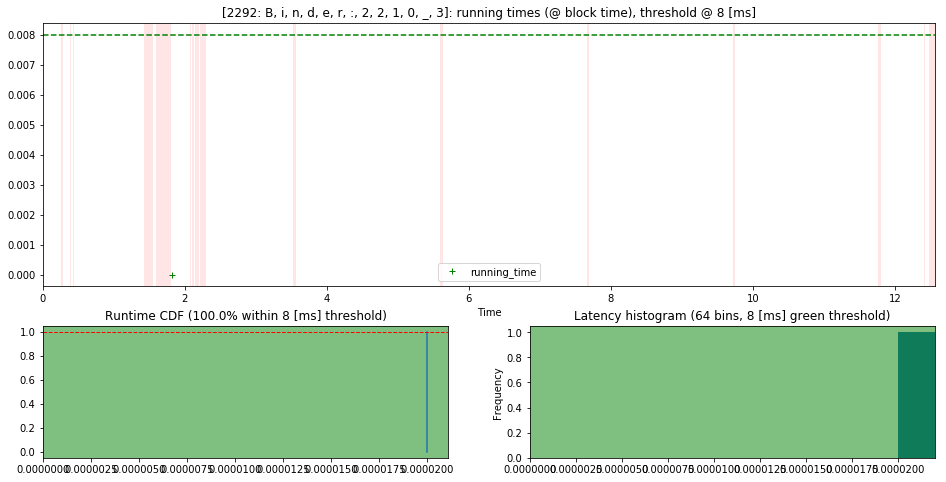

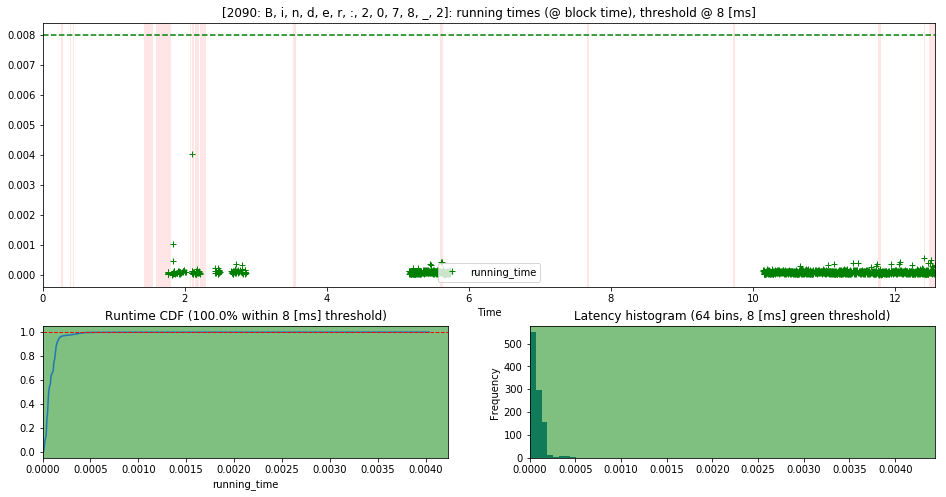

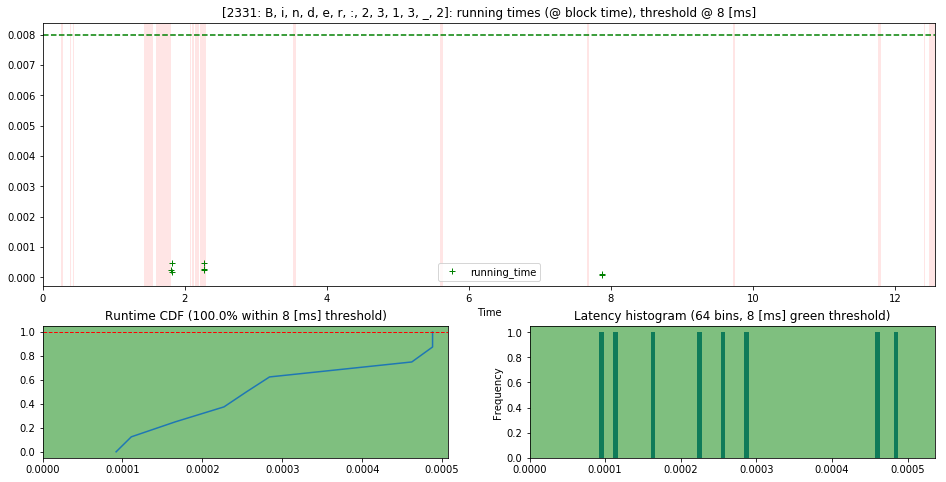

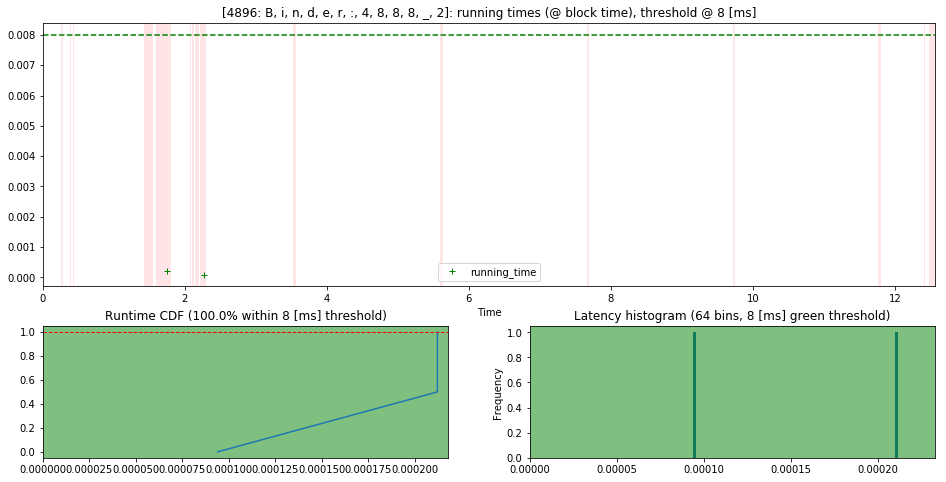

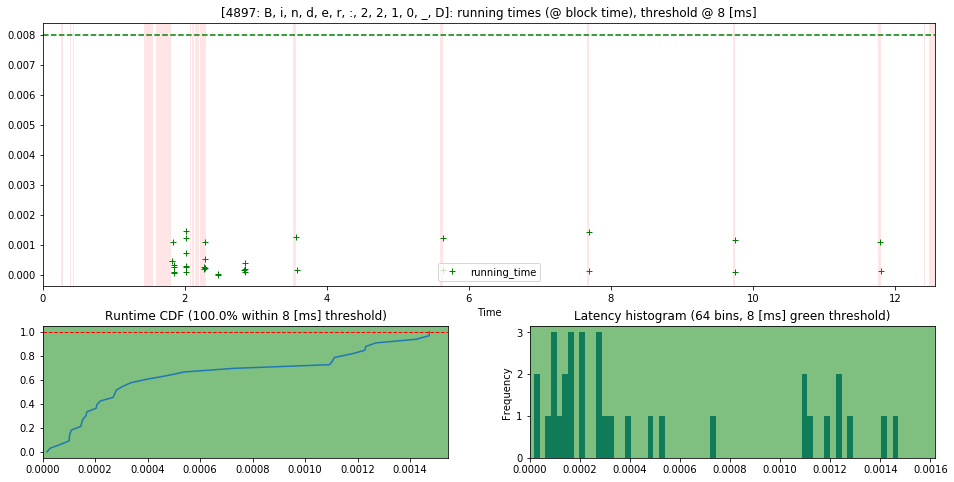

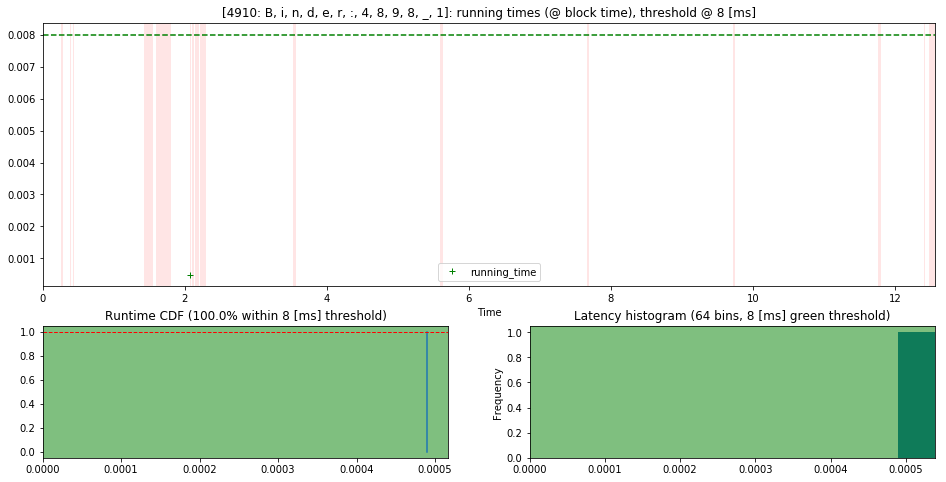

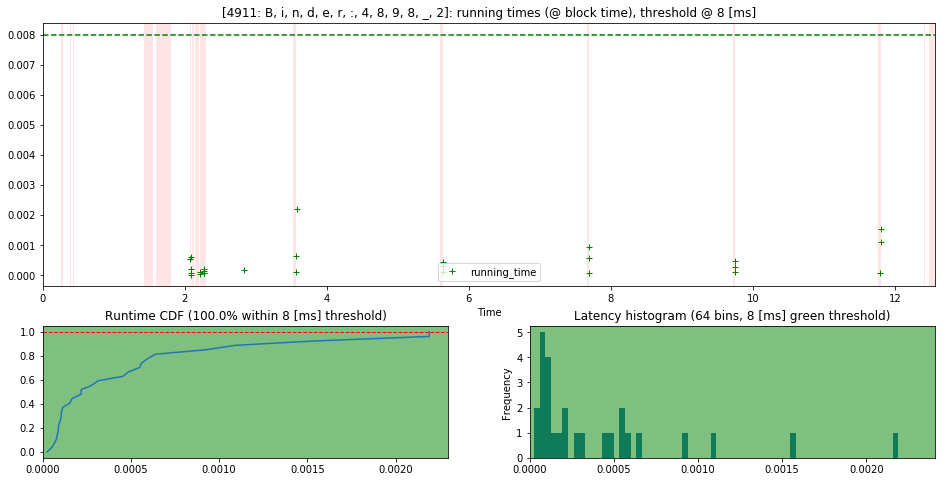

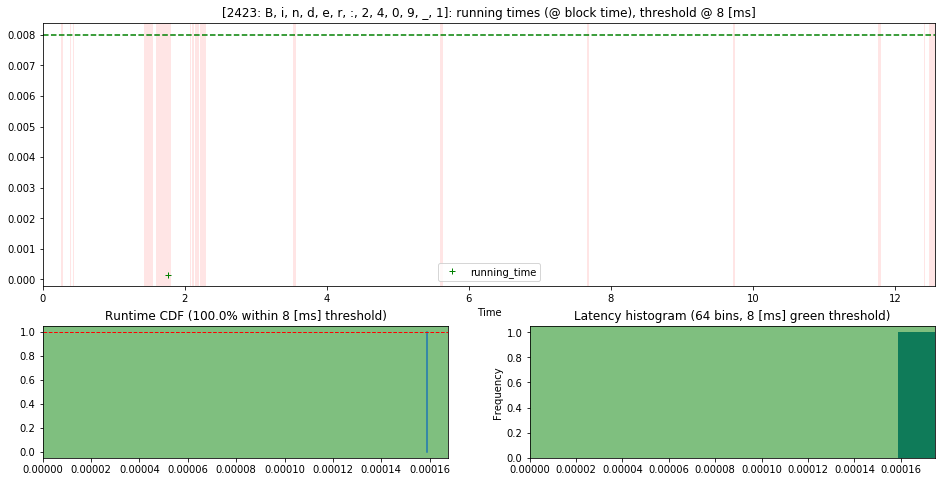

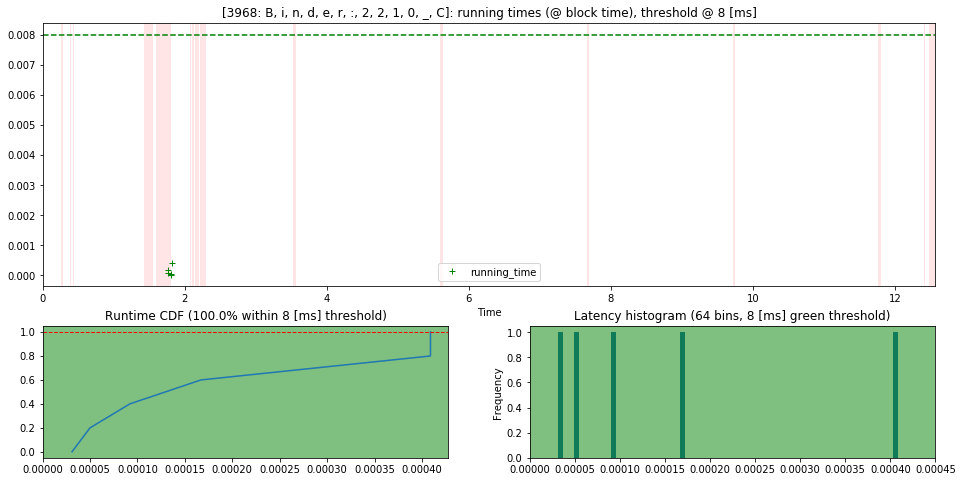

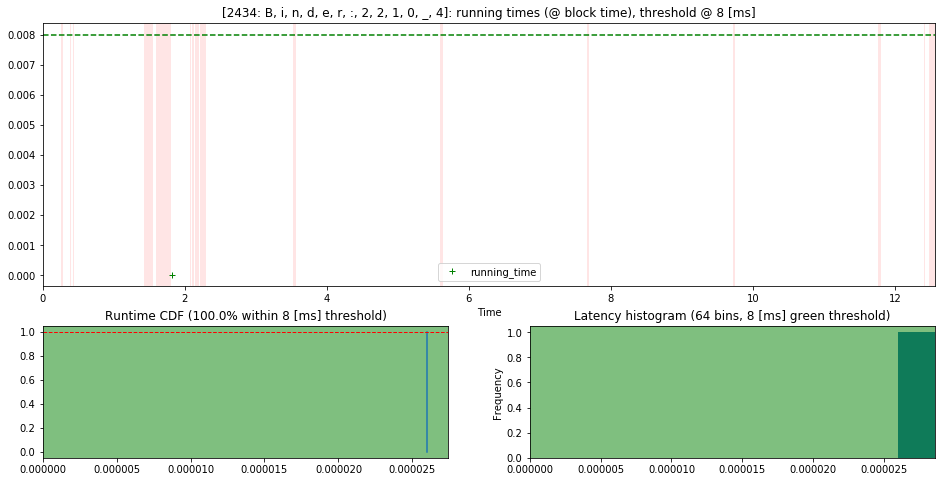

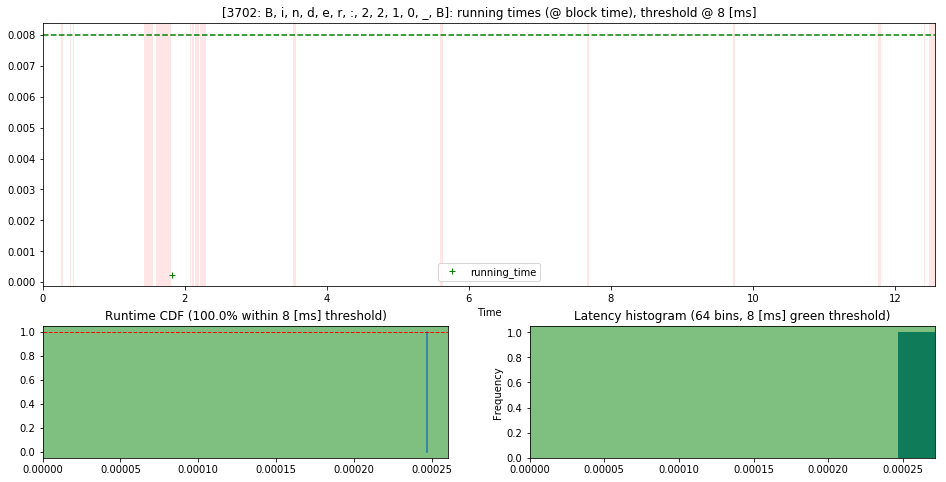

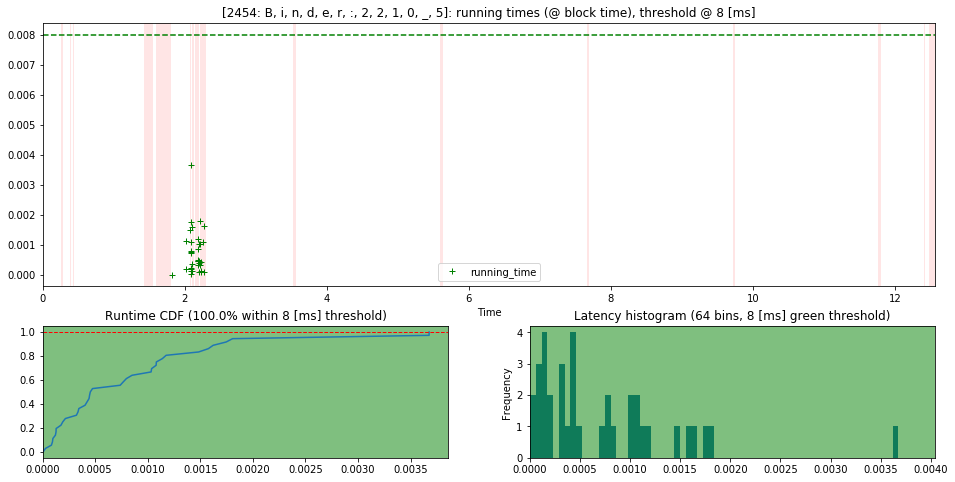

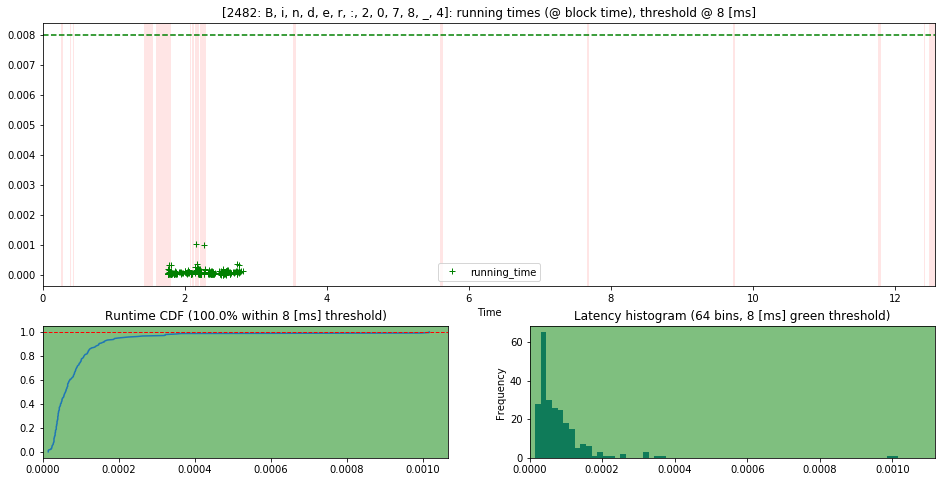

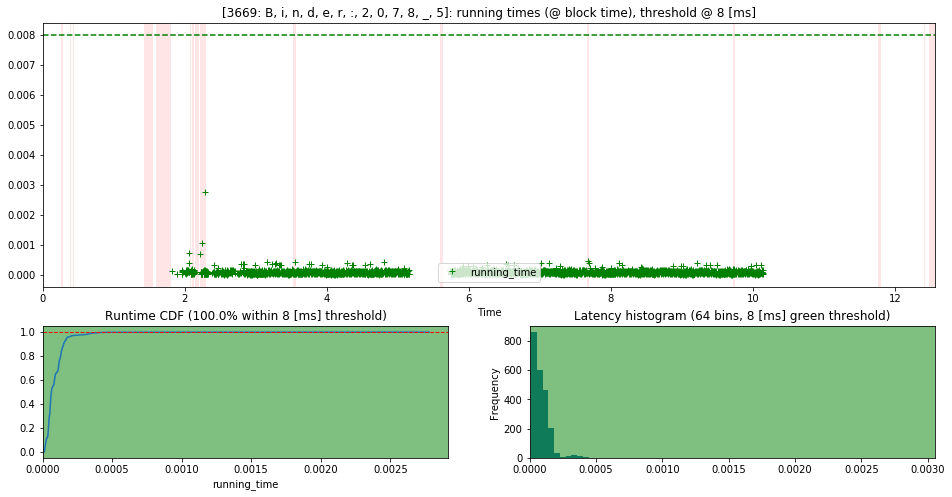

In [25]:
plot_task_runtime("Binder")